# Step1: Person-only detection

In [3]:
import torch

from utils.dataloader import VOCDataLoaderPerson
loader = VOCDataLoaderPerson(train=False, batch_size=1)

Target vector: tensor([[ 0.1450,  0.5986,  0.0420,  0.1060,  1.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -1.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -1.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -1.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -1.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -1.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -1.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -1.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -1.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -1.0000]])


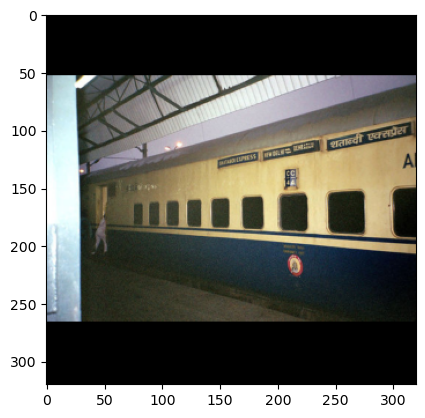

In [4]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# Visualization to check if the data are correct loaded
for img, target in loader:
    img = F.to_pil_image(img[0])
    print("Target vector:", target[0])
    plt.imshow(img)
    plt.show()

    break  

In [4]:
# Retrain the model

model.train()

# ratio_min, ratio_max = float('inf'), 0.0
# ratio_sum, ratio_count = 0.0, 0
epoch_count = 0

count = 100
for epoch in range(count):
    
    epoch_loss_sum = 0.0
    epoch_loss_count = 0
    
    ratio_epoch_min, ratio_epoch_max = float('inf'), 0.0
    ratio_epoch_sum, ratio_epoch_count = 0.0, 0
    
    for _, (img, target) in tqdm.tqdm(enumerate(loader), total=len(loader)):
        optimizer.zero_grad()
        output = model(img)
        loss, (loss_coord, loss_conf, loss_cls) = criterion(output, target) # To check which part of loss dominate and maybe hinder the optimization.
        loss.backward()

        # debug: print some gradient stats
        # if count % 50 == 0:
        #     with torch.no_grad():
        #         model.eval()
        #         pred = output[0]
        #         # flatten to [num_anchors * H * W, 6]
        #         pred_flat = pred.view(-1, pred.shape[-1])
        #         # Only print confidence > threshold or the first ten
        #         high_conf_mask = (pred_flat[..., 4] > 0.6)
        #         print("High conf predictions (x,y,w,h,conf):")
        #         print(pred_flat[high_conf_mask][..., :5])  #Only shows x,y,w,h,conf
        #         print()
                
        # debug: check if the anchors suit for this dataset.
        # with torch.no_grad():
        #     model.eval()
        #     # Get vaild ground truth
        #     valid_mask = (target[..., -1] >= 0)
        #     gt_valid = target[valid_mask]  # [n, 6]
        #     if gt_valid.shape[0] > 0:
        #         w = gt_valid[:, 2]  # [n]
        #         h = gt_valid[:, 3]
                
        #         # anchors: shape [num_anchors, 2], e.g. criterion.anchors
        #         for (aw, ah) in criterion.anchors:
        #             ratio_w = (w / aw).cpu().numpy()
        #             ratio_h = (h / ah).cpu().numpy()
                    
        #             curr_min = ratio_w.min() if ratio_w.size>0 else None
        #             curr_max = ratio_w.max() if ratio_w.size>0 else None
        #             if curr_min is not None:
        #                 ratio_epoch_min = min(ratio_epoch_min, float(curr_min))
        #                 ratio_min = min(ratio_min, float(curr_min))
        #             if curr_max is not None:
        #                 ratio_epoch_max = max(ratio_epoch_max, float(curr_max))
        #                 ratio_max = max(ratio_max, float(curr_max))
                    
        #             ratio_epoch_sum += ratio_w.sum() + ratio_h.sum()
        #             ratio_epoch_count += ratio_w.size + ratio_h.size
        #             ratio_sum += ratio_w.sum() + ratio_h.sum()
        #             ratio_count += ratio_w.size + ratio_h.size
        
        # Check the norm
        with torch.no_grad():
            model.eval()
            total_norm = 0
            for param in model.parameters():
                if param.grad is not None:
                    param_norm = param.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** 0.5
            
        
        model.train() 

        # print(f"Total Gradient Norm: {total_norm}")
        dynamic_max_norm = total_norm * 0.8  # 动态设置为当前梯度范数的 80%
        # print(f"dynamic_max_norm: {dynamic_max_norm}")
        torch.nn.utils.clip_grad_norm_(model.conv9.parameters(), max_norm=dynamic_max_norm)
        optimizer.step()

        epoch_loss_sum += loss.item()
        epoch_loss_count += 1
        
    # debug: check if the anchors suit for this dataset.   
    # if ratio_epoch_count > 0:
    #     mean_epoch = ratio_epoch_sum / ratio_epoch_count
    #     print(f"Epoch={epoch}, ratio_min={ratio_epoch_min:.4f}, ratio_max={ratio_epoch_max:.4f}, ratio_mean={mean_epoch:.4f}")
    # else:
    #     print(f"Epoch={epoch}, no valid GT found")
        
    if epoch_loss_count > 0:
        avg_epoch_loss = epoch_loss_sum / epoch_loss_count
    else:
        avg_epoch_loss = 0.0
        
    # scheduler.step()
    print(f"Average epoch loss: {avg_epoch_loss}")
    scheduler.step(avg_epoch_loss)
    print("Current LR:", optimizer.param_groups[0]['lr'])
    
    print(f"Coord Loss: {loss_coord}, Conf Loss: {loss_conf}, Class Loss: {loss_cls}")
    
    count -= 1
    print(f"-------------------------------------------------------------------Epoch [{epoch+1}/{count}], Loss: {loss.item():.4f}-------------------------------------------------------------------")

# if ratio_count > 0:
#     ratio_overall_mean = ratio_sum / ratio_count
#     print(f"Global ratio min={ratio_min}, max={ratio_max}, mean={ratio_overall_mean}")

  0%|                                               | 0/215 [00:00<?, ?it/s]/Users/yezeling/miniforge3/envs/myenv/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729647065806/work/aten/src/ATen/native/TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|█████████████████████████████████████| 215/215 [01:10<00:00,  3.07it/s]


Average epoch loss: 66.12570868203807
Current LR: 0.0001
Coord Loss: 21.18494987487793, Conf Loss: 46.07978057861328, Class Loss: 0.0
-------------------------------------------------------------------Epoch [1/100], Loss: 67.2647-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:15<00:00,  2.85it/s]


Average epoch loss: 64.53967709208644
Current LR: 0.0001
Coord Loss: 20.776042938232422, Conf Loss: 45.897682189941406, Class Loss: 0.0
-------------------------------------------------------------------Epoch [2/100], Loss: 66.6737-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:15<00:00,  2.87it/s]


Average epoch loss: 64.29958863369254
Current LR: 0.0001
Coord Loss: 20.36724853515625, Conf Loss: 45.80683898925781, Class Loss: 0.0
-------------------------------------------------------------------Epoch [3/100], Loss: 66.1741-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:15<00:00,  2.84it/s]


Average epoch loss: 64.16602176400119
Current LR: 0.0001
Coord Loss: 19.954954147338867, Conf Loss: 45.733367919921875, Class Loss: 0.0
-------------------------------------------------------------------Epoch [4/100], Loss: 65.6883-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:15<00:00,  2.86it/s]


Average epoch loss: 64.08418213600336
Current LR: 0.0001
Coord Loss: 19.646617889404297, Conf Loss: 45.664432525634766, Class Loss: 0.0
-------------------------------------------------------------------Epoch [5/100], Loss: 65.3111-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:15<00:00,  2.85it/s]


Average epoch loss: 63.56477863400482
Current LR: 0.0001
Coord Loss: 5.622525215148926, Conf Loss: 45.52818298339844, Class Loss: 0.0
-------------------------------------------------------------------Epoch [6/100], Loss: 51.1507-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:17<00:00,  2.79it/s]


Average epoch loss: 50.0538516199866
Current LR: 0.0001
Coord Loss: 4.648178577423096, Conf Loss: 45.341766357421875, Class Loss: 0.0
-------------------------------------------------------------------Epoch [7/100], Loss: 49.9899-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:15<00:00,  2.83it/s]


Average epoch loss: 49.736282579288925
Current LR: 0.0001
Coord Loss: 4.598872661590576, Conf Loss: 45.35455322265625, Class Loss: 0.0
-------------------------------------------------------------------Epoch [8/100], Loss: 49.9534-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:16<00:00,  2.82it/s]


Average epoch loss: 49.57794106062069
Current LR: 0.0001
Coord Loss: 4.330419540405273, Conf Loss: 45.27088165283203, Class Loss: 0.0
-------------------------------------------------------------------Epoch [9/100], Loss: 49.6013-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:16<00:00,  2.83it/s]


Average epoch loss: 49.446533664437226
Current LR: 0.0001
Coord Loss: 4.259349346160889, Conf Loss: 45.17230987548828, Class Loss: 0.0
-------------------------------------------------------------------Epoch [10/100], Loss: 49.4317-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:16<00:00,  2.83it/s]


Average epoch loss: 49.3323781213095
Current LR: 0.0001
Coord Loss: 4.23758602142334, Conf Loss: 45.209503173828125, Class Loss: 0.0
-------------------------------------------------------------------Epoch [11/100], Loss: 49.4471-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:16<00:00,  2.82it/s]


Average epoch loss: 49.26460450638172
Current LR: 0.0001
Coord Loss: 4.296692848205566, Conf Loss: 45.3787727355957, Class Loss: 0.0
-------------------------------------------------------------------Epoch [12/100], Loss: 49.6755-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:16<00:00,  2.82it/s]


Average epoch loss: 49.21210692649664
Current LR: 0.0001
Coord Loss: 4.2315168380737305, Conf Loss: 45.23647689819336, Class Loss: 0.0
-------------------------------------------------------------------Epoch [13/100], Loss: 49.4680-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:16<00:00,  2.80it/s]


Average epoch loss: 49.171366367783655
Current LR: 0.0001
Coord Loss: 4.202072620391846, Conf Loss: 45.22637939453125, Class Loss: 0.0
-------------------------------------------------------------------Epoch [14/100], Loss: 49.4285-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:15<00:00,  2.85it/s]


Average epoch loss: 49.130265683906025
Current LR: 0.0001
Coord Loss: 4.351990222930908, Conf Loss: 45.21580123901367, Class Loss: 0.0
-------------------------------------------------------------------Epoch [15/100], Loss: 49.5678-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:15<00:00,  2.85it/s]


Average epoch loss: 49.09272441420444
Current LR: 0.0001
Coord Loss: 4.132283687591553, Conf Loss: 45.17616271972656, Class Loss: 0.0
-------------------------------------------------------------------Epoch [16/100], Loss: 49.3084-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:16<00:00,  2.82it/s]


Average epoch loss: 49.06087163880814
Current LR: 0.0001
Coord Loss: 4.206303596496582, Conf Loss: 45.31127166748047, Class Loss: 0.0
-------------------------------------------------------------------Epoch [17/100], Loss: 49.5176-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:15<00:00,  2.83it/s]


Average epoch loss: 49.030517542639444
Current LR: 0.0001
Coord Loss: 4.296873092651367, Conf Loss: 45.19266891479492, Class Loss: 0.0
-------------------------------------------------------------------Epoch [18/100], Loss: 49.4895-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:15<00:00,  2.84it/s]


Average epoch loss: 49.004217777695764
Current LR: 0.0001
Coord Loss: 4.080108642578125, Conf Loss: 45.1318359375, Class Loss: 0.0
-------------------------------------------------------------------Epoch [19/100], Loss: 49.2119-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:15<00:00,  2.83it/s]


Average epoch loss: 48.96837958402412
Current LR: 0.0001
Coord Loss: 4.084228038787842, Conf Loss: 45.08197784423828, Class Loss: 0.0
-------------------------------------------------------------------Epoch [20/100], Loss: 49.1662-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:13<00:00,  2.94it/s]


Average epoch loss: 48.95813935745594
Current LR: 0.0001
Coord Loss: 4.113114833831787, Conf Loss: 45.13737487792969, Class Loss: 0.0
-------------------------------------------------------------------Epoch [21/100], Loss: 49.2505-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:10<00:00,  3.05it/s]


Average epoch loss: 48.91519837490348
Current LR: 0.0001
Coord Loss: 4.088780403137207, Conf Loss: 45.092323303222656, Class Loss: 0.0
-------------------------------------------------------------------Epoch [22/100], Loss: 49.1811-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:09<00:00,  3.11it/s]


Average epoch loss: 48.91049235144327
Current LR: 0.0001
Coord Loss: 4.076822280883789, Conf Loss: 45.091819763183594, Class Loss: 0.0
-------------------------------------------------------------------Epoch [23/100], Loss: 49.1686-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:10<00:00,  3.05it/s]


Average epoch loss: 48.88749854509221
Current LR: 0.0001
Coord Loss: 4.115046501159668, Conf Loss: 45.03950881958008, Class Loss: 0.0
-------------------------------------------------------------------Epoch [24/100], Loss: 49.1546-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:10<00:00,  3.05it/s]


Average epoch loss: 48.885074367079625
Current LR: 0.0001
Coord Loss: 4.0383172035217285, Conf Loss: 45.10189437866211, Class Loss: 0.0
-------------------------------------------------------------------Epoch [25/100], Loss: 49.1402-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:11<00:00,  3.00it/s]


Average epoch loss: 48.855800877061
Current LR: 0.0001
Coord Loss: 4.206518173217773, Conf Loss: 45.227638244628906, Class Loss: 0.0
-------------------------------------------------------------------Epoch [26/100], Loss: 49.4342-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:10<00:00,  3.05it/s]


Average epoch loss: 48.84875319724859
Current LR: 0.0001
Coord Loss: 4.036379337310791, Conf Loss: 45.103065490722656, Class Loss: 0.0
-------------------------------------------------------------------Epoch [27/100], Loss: 49.1394-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:10<00:00,  3.04it/s]


Average epoch loss: 48.81970333720363
Current LR: 0.0001
Coord Loss: 4.202273368835449, Conf Loss: 45.24940490722656, Class Loss: 0.0
-------------------------------------------------------------------Epoch [28/100], Loss: 49.4517-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:12<00:00,  2.96it/s]


Average epoch loss: 48.81121728586596
Current LR: 0.0001
Coord Loss: 4.052370548248291, Conf Loss: 45.08443069458008, Class Loss: 0.0
-------------------------------------------------------------------Epoch [29/100], Loss: 49.1368-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:11<00:00,  3.01it/s]


Average epoch loss: 48.78848825499069
Current LR: 0.0001
Coord Loss: 4.031866073608398, Conf Loss: 45.06272506713867, Class Loss: 0.0
-------------------------------------------------------------------Epoch [30/100], Loss: 49.0946-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:13<00:00,  2.93it/s]


Average epoch loss: 48.7772153987441
Current LR: 0.0001
Coord Loss: 4.148350715637207, Conf Loss: 45.21988296508789, Class Loss: 0.0
-------------------------------------------------------------------Epoch [31/100], Loss: 49.3682-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:11<00:00,  3.01it/s]


Average epoch loss: 48.7668034043423
Current LR: 0.0001
Coord Loss: 4.059653282165527, Conf Loss: 45.01133346557617, Class Loss: 0.0
-------------------------------------------------------------------Epoch [32/100], Loss: 49.0710-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:12<00:00,  2.98it/s]


Average epoch loss: 48.76339629417242
Current LR: 5e-05
Coord Loss: 4.021693229675293, Conf Loss: 45.0607795715332, Class Loss: 0.0
-------------------------------------------------------------------Epoch [33/100], Loss: 49.0825-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:11<00:00,  3.01it/s]


Average epoch loss: 48.73737571184025
Current LR: 5e-05
Coord Loss: 4.051285266876221, Conf Loss: 45.14371871948242, Class Loss: 0.0
-------------------------------------------------------------------Epoch [34/100], Loss: 49.1950-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:15<00:00,  2.86it/s]


Average epoch loss: 48.71149103918741
Current LR: 5e-05
Coord Loss: 4.046619892120361, Conf Loss: 45.032073974609375, Class Loss: 0.0
-------------------------------------------------------------------Epoch [35/100], Loss: 49.0787-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:14<00:00,  2.89it/s]


Average epoch loss: 48.71266763376635
Current LR: 5e-05
Coord Loss: 4.128485679626465, Conf Loss: 45.178279876708984, Class Loss: 0.0
-------------------------------------------------------------------Epoch [36/100], Loss: 49.3068-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:15<00:00,  2.85it/s]


Average epoch loss: 48.72056652335233
Current LR: 5e-05
Coord Loss: 4.030933380126953, Conf Loss: 45.113609313964844, Class Loss: 0.0
-------------------------------------------------------------------Epoch [37/100], Loss: 49.1445-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:15<00:00,  2.86it/s]


Average epoch loss: 48.71559398562409
Current LR: 5e-05
Coord Loss: 4.020972728729248, Conf Loss: 45.108741760253906, Class Loss: 0.0
-------------------------------------------------------------------Epoch [38/100], Loss: 49.1297-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:16<00:00,  2.82it/s]


Average epoch loss: 48.70190521949945
Current LR: 5e-05
Coord Loss: 4.193846702575684, Conf Loss: 45.24919128417969, Class Loss: 0.0
-------------------------------------------------------------------Epoch [39/100], Loss: 49.4430-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:15<00:00,  2.84it/s]


Average epoch loss: 48.705244836141894
Current LR: 5e-05
Coord Loss: 4.218304634094238, Conf Loss: 45.14552307128906, Class Loss: 0.0
-------------------------------------------------------------------Epoch [40/100], Loss: 49.3638-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:15<00:00,  2.84it/s]


Average epoch loss: 48.69781483494958
Current LR: 5e-05
Coord Loss: 4.017947196960449, Conf Loss: 45.06467056274414, Class Loss: 0.0
-------------------------------------------------------------------Epoch [41/100], Loss: 49.0826-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:15<00:00,  2.86it/s]


Average epoch loss: 48.68522255476131
Current LR: 5e-05
Coord Loss: 4.052083492279053, Conf Loss: 45.133296966552734, Class Loss: 0.0
-------------------------------------------------------------------Epoch [42/100], Loss: 49.1854-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:15<00:00,  2.86it/s]


Average epoch loss: 48.68696564075559
Current LR: 5e-05
Coord Loss: 4.030144691467285, Conf Loss: 45.02311325073242, Class Loss: 0.0
-------------------------------------------------------------------Epoch [43/100], Loss: 49.0533-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:15<00:00,  2.84it/s]


Average epoch loss: 48.68216955495435
Current LR: 2.5e-05
Coord Loss: 4.061409950256348, Conf Loss: 45.09136962890625, Class Loss: 0.0
-------------------------------------------------------------------Epoch [44/100], Loss: 49.1528-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:15<00:00,  2.86it/s]


Average epoch loss: 48.68235237653865
Current LR: 2.5e-05
Coord Loss: 4.1342573165893555, Conf Loss: 45.12810134887695, Class Loss: 0.0
-------------------------------------------------------------------Epoch [45/100], Loss: 49.2624-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:14<00:00,  2.87it/s]


Average epoch loss: 48.664282829816955
Current LR: 2.5e-05
Coord Loss: 4.01550817489624, Conf Loss: 45.063961029052734, Class Loss: 0.0
-------------------------------------------------------------------Epoch [46/100], Loss: 49.0795-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:12<00:00,  2.97it/s]


Average epoch loss: 48.66177644951399
Current LR: 2.5e-05
Coord Loss: 4.016016483306885, Conf Loss: 45.059173583984375, Class Loss: 0.0
-------------------------------------------------------------------Epoch [47/100], Loss: 49.0752-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:12<00:00,  2.97it/s]


Average epoch loss: 48.67235456954601
Current LR: 2.5e-05
Coord Loss: 4.051719665527344, Conf Loss: 45.073333740234375, Class Loss: 0.0
-------------------------------------------------------------------Epoch [48/100], Loss: 49.1251-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:12<00:00,  2.96it/s]


Average epoch loss: 48.66841629383176
Current LR: 2.5e-05
Coord Loss: 4.188233852386475, Conf Loss: 45.23748016357422, Class Loss: 0.0
-------------------------------------------------------------------Epoch [49/100], Loss: 49.4257-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:10<00:00,  3.05it/s]


Average epoch loss: 48.66072400115257
Current LR: 2.5e-05
Coord Loss: 4.016876697540283, Conf Loss: 45.054264068603516, Class Loss: 0.0
-------------------------------------------------------------------Epoch [50/100], Loss: 49.0711-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:10<00:00,  3.03it/s]


Average epoch loss: 48.64917740932731
Current LR: 2.5e-05
Coord Loss: 4.060271739959717, Conf Loss: 45.09144973754883, Class Loss: 0.0
-------------------------------------------------------------------Epoch [51/100], Loss: 49.1517-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:13<00:00,  2.92it/s]


Average epoch loss: 48.65830998975177
Current LR: 2.5e-05
Coord Loss: 4.057056427001953, Conf Loss: 45.08966064453125, Class Loss: 0.0
-------------------------------------------------------------------Epoch [52/100], Loss: 49.1467-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:12<00:00,  2.97it/s]


Average epoch loss: 48.64555101616438
Current LR: 2.5e-05
Coord Loss: 4.064679145812988, Conf Loss: 45.05620193481445, Class Loss: 0.0
-------------------------------------------------------------------Epoch [53/100], Loss: 49.1209-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:11<00:00,  3.01it/s]


Average epoch loss: 48.65309416305187
Current LR: 2.5e-05
Coord Loss: 4.25501823425293, Conf Loss: 45.32536315917969, Class Loss: 0.0
-------------------------------------------------------------------Epoch [54/100], Loss: 49.5804-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:11<00:00,  3.02it/s]


Average epoch loss: 48.636454826177555
Current LR: 2.5e-05
Coord Loss: 4.0282721519470215, Conf Loss: 45.034217834472656, Class Loss: 0.0
-------------------------------------------------------------------Epoch [55/100], Loss: 49.0625-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:12<00:00,  2.97it/s]


Average epoch loss: 48.65371714747229
Current LR: 2.5e-05
Coord Loss: 4.013427257537842, Conf Loss: 45.06222152709961, Class Loss: 0.0
-------------------------------------------------------------------Epoch [56/100], Loss: 49.0756-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:13<00:00,  2.91it/s]


Average epoch loss: 48.64940364748933
Current LR: 1.25e-05
Coord Loss: 4.178284168243408, Conf Loss: 45.21706771850586, Class Loss: 0.0
-------------------------------------------------------------------Epoch [57/100], Loss: 49.3954-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:13<00:00,  2.91it/s]


Average epoch loss: 48.6327984832054
Current LR: 1.25e-05
Coord Loss: 4.025876522064209, Conf Loss: 45.03030014038086, Class Loss: 0.0
-------------------------------------------------------------------Epoch [58/100], Loss: 49.0562-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:12<00:00,  2.96it/s]


Average epoch loss: 48.64982214639353
Current LR: 1.25e-05
Coord Loss: 4.130077838897705, Conf Loss: 45.16523361206055, Class Loss: 0.0
-------------------------------------------------------------------Epoch [59/100], Loss: 49.2953-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:12<00:00,  2.96it/s]


Average epoch loss: 48.63458956341411
Current LR: 1.25e-05
Coord Loss: 4.016386032104492, Conf Loss: 45.04978561401367, Class Loss: 0.0
-------------------------------------------------------------------Epoch [60/100], Loss: 49.0662-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:13<00:00,  2.92it/s]


Average epoch loss: 48.63363131146098
Current LR: 1.25e-05
Coord Loss: 4.027843475341797, Conf Loss: 45.057518005371094, Class Loss: 0.0
-------------------------------------------------------------------Epoch [61/100], Loss: 49.0854-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:12<00:00,  2.99it/s]


Average epoch loss: 48.63356349856355
Current LR: 1.25e-05
Coord Loss: 4.12239933013916, Conf Loss: 45.221778869628906, Class Loss: 0.0
-------------------------------------------------------------------Epoch [62/100], Loss: 49.3442-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:10<00:00,  3.06it/s]


Average epoch loss: 48.6392097118289
Current LR: 1.25e-05
Coord Loss: 4.028386116027832, Conf Loss: 45.06509017944336, Class Loss: 0.0
-------------------------------------------------------------------Epoch [63/100], Loss: 49.0935-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:10<00:00,  3.04it/s]


Average epoch loss: 48.63750321144281
Current LR: 1.25e-05
Coord Loss: 4.068572998046875, Conf Loss: 45.10840606689453, Class Loss: 0.0
-------------------------------------------------------------------Epoch [64/100], Loss: 49.1770-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:10<00:00,  3.04it/s]


Average epoch loss: 48.64252723871275
Current LR: 1.25e-05
Coord Loss: 4.042675495147705, Conf Loss: 45.00785827636719, Class Loss: 0.0
-------------------------------------------------------------------Epoch [65/100], Loss: 49.0505-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:10<00:00,  3.06it/s]


Average epoch loss: 48.62155699619027
Current LR: 1.25e-05
Coord Loss: 4.017909049987793, Conf Loss: 45.04151153564453, Class Loss: 0.0
-------------------------------------------------------------------Epoch [66/100], Loss: 49.0594-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:10<00:00,  3.04it/s]


Average epoch loss: 48.62750806586687
Current LR: 1.25e-05
Coord Loss: 4.031682968139648, Conf Loss: 44.983177185058594, Class Loss: 0.0
-------------------------------------------------------------------Epoch [67/100], Loss: 49.0149-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:10<00:00,  3.05it/s]


Average epoch loss: 48.62884108077648
Current LR: 1e-05
Coord Loss: 4.045808792114258, Conf Loss: 44.98418426513672, Class Loss: 0.0
-------------------------------------------------------------------Epoch [68/100], Loss: 49.0300-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:10<00:00,  3.04it/s]


Average epoch loss: 48.6281021118164
Current LR: 1e-05
Coord Loss: 4.177367210388184, Conf Loss: 45.23639678955078, Class Loss: 0.0
-------------------------------------------------------------------Epoch [69/100], Loss: 49.4138-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:10<00:00,  3.03it/s]


Average epoch loss: 48.62767763359602
Current LR: 1e-05
Coord Loss: 4.033873081207275, Conf Loss: 45.02711868286133, Class Loss: 0.0
-------------------------------------------------------------------Epoch [70/100], Loss: 49.0610-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:10<00:00,  3.05it/s]


Average epoch loss: 48.63250448537428
Current LR: 1e-05
Coord Loss: 4.0239577293396, Conf Loss: 45.06907653808594, Class Loss: 0.0
-------------------------------------------------------------------Epoch [71/100], Loss: 49.0930-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [16:16<00:00,  4.54s/it]


Average epoch loss: 48.61904422848723
Current LR: 1e-05
Coord Loss: 4.236194133758545, Conf Loss: 45.15715026855469, Class Loss: 0.0
-------------------------------------------------------------------Epoch [72/100], Loss: 49.3933-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:09<00:00,  3.10it/s]


Average epoch loss: 48.62549968985624
Current LR: 1e-05
Coord Loss: 4.013050079345703, Conf Loss: 45.05241394042969, Class Loss: 0.0
-------------------------------------------------------------------Epoch [73/100], Loss: 49.0655-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [01:09<00:00,  3.10it/s]


Average epoch loss: 48.6107491958973
Current LR: 1e-05
Coord Loss: 4.01386022567749, Conf Loss: 45.05012130737305, Class Loss: 0.0
-------------------------------------------------------------------Epoch [74/100], Loss: 49.0640-------------------------------------------------------------------


100%|█████████████████████████████████████| 215/215 [16:44<00:00,  4.67s/it]


Average epoch loss: 48.618932448985966
Current LR: 1e-05
Coord Loss: 4.076719284057617, Conf Loss: 45.167640686035156, Class Loss: 0.0
-------------------------------------------------------------------Epoch [75/100], Loss: 49.2444-------------------------------------------------------------------


100%|█████████████████████████████████████████████| 215/215 [01:10<00:00,  3.04it/s]


Average epoch loss: 48.6302567592887
Current LR: 1e-05
Coord Loss: 4.017573356628418, Conf Loss: 45.042396545410156, Class Loss: 0.0
-------------------------------------------------------------------Epoch [76/100], Loss: 49.0600-------------------------------------------------------------------


100%|█████████████████████████████████████████████| 215/215 [01:10<00:00,  3.05it/s]


Average epoch loss: 48.619324120809864
Current LR: 1e-05
Coord Loss: 4.040091514587402, Conf Loss: 45.02758026123047, Class Loss: 0.0
-------------------------------------------------------------------Epoch [77/100], Loss: 49.0677-------------------------------------------------------------------


100%|█████████████████████████████████████████████| 215/215 [01:10<00:00,  3.03it/s]


Average epoch loss: 48.617744250630224
Current LR: 1e-05
Coord Loss: 4.0212812423706055, Conf Loss: 45.00445556640625, Class Loss: 0.0
-------------------------------------------------------------------Epoch [78/100], Loss: 49.0257-------------------------------------------------------------------


100%|█████████████████████████████████████████████| 215/215 [01:10<00:00,  3.07it/s]


Average epoch loss: 48.62192744765171
Current LR: 1e-05
Coord Loss: 4.075895309448242, Conf Loss: 45.1159553527832, Class Loss: 0.0
-------------------------------------------------------------------Epoch [79/100], Loss: 49.1918-------------------------------------------------------------------


100%|█████████████████████████████████████████████| 215/215 [01:09<00:00,  3.08it/s]


Average epoch loss: 48.614426670518036
Current LR: 1e-05
Coord Loss: 4.145525932312012, Conf Loss: 45.036685943603516, Class Loss: 0.0
-------------------------------------------------------------------Epoch [80/100], Loss: 49.1822-------------------------------------------------------------------


100%|█████████████████████████████████████████████| 215/215 [01:08<00:00,  3.12it/s]


Average epoch loss: 48.616231111038566
Current LR: 1e-05
Coord Loss: 4.015185832977295, Conf Loss: 45.015777587890625, Class Loss: 0.0
-------------------------------------------------------------------Epoch [81/100], Loss: 49.0310-------------------------------------------------------------------


100%|█████████████████████████████████████████████| 215/215 [01:09<00:00,  3.11it/s]


Average epoch loss: 48.619559940071994
Current LR: 1e-05
Coord Loss: 4.088143825531006, Conf Loss: 45.200050354003906, Class Loss: 0.0
-------------------------------------------------------------------Epoch [82/100], Loss: 49.2882-------------------------------------------------------------------


100%|█████████████████████████████████████████████| 215/215 [01:08<00:00,  3.12it/s]


Average epoch loss: 48.609622014955036
Current LR: 1e-05
Coord Loss: 4.0272393226623535, Conf Loss: 45.02031707763672, Class Loss: 0.0
-------------------------------------------------------------------Epoch [83/100], Loss: 49.0476-------------------------------------------------------------------


100%|█████████████████████████████████████████████| 215/215 [01:10<00:00,  3.06it/s]


Average epoch loss: 48.62413037322288
Current LR: 1e-05
Coord Loss: 4.036692142486572, Conf Loss: 45.0217170715332, Class Loss: 0.0
-------------------------------------------------------------------Epoch [84/100], Loss: 49.0584-------------------------------------------------------------------


100%|█████████████████████████████████████████████| 215/215 [01:09<00:00,  3.07it/s]


Average epoch loss: 48.6081669474757
Current LR: 1e-05
Coord Loss: 4.037124156951904, Conf Loss: 45.07904052734375, Class Loss: 0.0
-------------------------------------------------------------------Epoch [85/100], Loss: 49.1162-------------------------------------------------------------------


100%|█████████████████████████████████████████████| 215/215 [01:10<00:00,  3.04it/s]


Average epoch loss: 48.612077455742416
Current LR: 1e-05
Coord Loss: 4.025553226470947, Conf Loss: 45.00806427001953, Class Loss: 0.0
-------------------------------------------------------------------Epoch [86/100], Loss: 49.0336-------------------------------------------------------------------


100%|█████████████████████████████████████████████| 215/215 [01:10<00:00,  3.06it/s]


Average epoch loss: 48.6244774751885
Current LR: 1e-05
Coord Loss: 4.211582660675049, Conf Loss: 45.133548736572266, Class Loss: 0.0
-------------------------------------------------------------------Epoch [87/100], Loss: 49.3451-------------------------------------------------------------------


100%|█████████████████████████████████████████████| 215/215 [01:10<00:00,  3.07it/s]


Average epoch loss: 48.61673404782317
Current LR: 1e-05
Coord Loss: 4.034190654754639, Conf Loss: 45.0495719909668, Class Loss: 0.0
-------------------------------------------------------------------Epoch [88/100], Loss: 49.0838-------------------------------------------------------------------


100%|█████████████████████████████████████████████| 215/215 [01:09<00:00,  3.08it/s]


Average epoch loss: 48.618201127163196
Current LR: 1e-05
Coord Loss: 4.017514228820801, Conf Loss: 45.011260986328125, Class Loss: 0.0
-------------------------------------------------------------------Epoch [89/100], Loss: 49.0288-------------------------------------------------------------------


100%|█████████████████████████████████████████████| 215/215 [01:09<00:00,  3.08it/s]


Average epoch loss: 48.60110299753588
Current LR: 1e-05
Coord Loss: 4.042204856872559, Conf Loss: 44.988033294677734, Class Loss: 0.0
-------------------------------------------------------------------Epoch [90/100], Loss: 49.0302-------------------------------------------------------------------


100%|█████████████████████████████████████████████| 215/215 [01:10<00:00,  3.05it/s]


Average epoch loss: 48.60561951038449
Current LR: 1e-05
Coord Loss: 4.036535263061523, Conf Loss: 45.05913162231445, Class Loss: 0.0
-------------------------------------------------------------------Epoch [91/100], Loss: 49.0957-------------------------------------------------------------------


100%|█████████████████████████████████████████████| 215/215 [01:10<00:00,  3.05it/s]


Average epoch loss: 48.61842527167742
Current LR: 1e-05
Coord Loss: 4.025615692138672, Conf Loss: 45.03781509399414, Class Loss: 0.0
-------------------------------------------------------------------Epoch [92/100], Loss: 49.0634-------------------------------------------------------------------


100%|█████████████████████████████████████████████| 215/215 [01:09<00:00,  3.08it/s]


Average epoch loss: 48.60883842290834
Current LR: 1e-05
Coord Loss: 4.039642333984375, Conf Loss: 45.05674743652344, Class Loss: 0.0
-------------------------------------------------------------------Epoch [93/100], Loss: 49.0964-------------------------------------------------------------------


100%|█████████████████████████████████████████████| 215/215 [01:10<00:00,  3.06it/s]


Average epoch loss: 48.60484832053961
Current LR: 1e-05
Coord Loss: 4.014174938201904, Conf Loss: 45.04449462890625, Class Loss: 0.0
-------------------------------------------------------------------Epoch [94/100], Loss: 49.0587-------------------------------------------------------------------


100%|█████████████████████████████████████████████| 215/215 [01:10<00:00,  3.06it/s]


Average epoch loss: 48.606673537853155
Current LR: 1e-05
Coord Loss: 4.043396472930908, Conf Loss: 45.06743240356445, Class Loss: 0.0
-------------------------------------------------------------------Epoch [95/100], Loss: 49.1108-------------------------------------------------------------------


100%|█████████████████████████████████████████████| 215/215 [01:10<00:00,  3.05it/s]


Average epoch loss: 48.59795409801394
Current LR: 1e-05
Coord Loss: 4.011228561401367, Conf Loss: 45.02275848388672, Class Loss: 0.0
-------------------------------------------------------------------Epoch [96/100], Loss: 49.0340-------------------------------------------------------------------


100%|█████████████████████████████████████████████| 215/215 [01:10<00:00,  3.06it/s]


Average epoch loss: 48.605204648749776
Current LR: 1e-05
Coord Loss: 4.092958450317383, Conf Loss: 45.20548629760742, Class Loss: 0.0
-------------------------------------------------------------------Epoch [97/100], Loss: 49.2984-------------------------------------------------------------------


100%|█████████████████████████████████████████████| 215/215 [01:10<00:00,  3.06it/s]


Average epoch loss: 48.59203129258267
Current LR: 1e-05
Coord Loss: 4.080072402954102, Conf Loss: 45.106754302978516, Class Loss: 0.0
-------------------------------------------------------------------Epoch [98/100], Loss: 49.1868-------------------------------------------------------------------


100%|█████████████████████████████████████████████| 215/215 [01:10<00:00,  3.06it/s]


Average epoch loss: 48.60153125496798
Current LR: 1e-05
Coord Loss: 4.1777873039245605, Conf Loss: 45.14630889892578, Class Loss: 0.0
-------------------------------------------------------------------Epoch [99/100], Loss: 49.3241-------------------------------------------------------------------


100%|█████████████████████████████████████████████| 215/215 [01:10<00:00,  3.05it/s]

Average epoch loss: 48.59997986194699
Current LR: 1e-05
Coord Loss: 4.011202812194824, Conf Loss: 45.05394744873047, Class Loss: 0.0
-------------------------------------------------------------------Epoch [100/100], Loss: 49.0652-------------------------------------------------------------------


In [1]:
anchors_9=((0.48963717, 0.7219764),
 (0.12734953, 0.2878153),
 (0.08295543, 0.15192717),
 (0.7726421,  0.73322475),
 (0.18190207, 0.48115298),
 (0.46931577, 0.45483983),
 (0.03759469, 0.07182477),
 (0.30879277, 0.5884212 ),
 (0.26364553, 0.29661068))
print(type(anchors_9))

anchors_5=(
        (0.39765027, 0.5792138),
        (0.04936575, 0.09369813),
        (0.12444213, 0.25251988),
        (0.6931115,  0.72179604),
        (0.22943892, 0.44076216))
print(type(anchors_5))

<class 'tuple'>
<class 'tuple'>


In [2]:
from tinyyolov2 import TinyYoloV2
import torch

# load pretrained model
model = TinyYoloV2(num_classes=1)
sd = torch.load("voc_pretrained_new.pt")
model.load_state_dict({k: v for k, v in sd.items() if not '9' in k}, strict=False)

anchors = torch.tensor(anchors_5)
model.anchors = anchors
# if model.anchors.equal(torch.tensor(anchors_9)) in sd:
#     del sd['anchors']
print(model)
print(model.anchors)
model.eval()


# freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Only retrain the last layer
for param in model.conv9.parameters():
    param.requires_grad = True

/var/folders/3p/yjsjgtxs5w75lv_wclnr3n0c0000gn/T/ipykernel_55296/1848861750.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load("voc_pretrained_new.pt")


TinyYoloV2(
  (pad): ReflectionPad2d((0, 1, 0, 1))
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(256, 512, kernel_size=(3, 3), stride=

In [3]:
from utils.loss import YoloLoss
from torch.optim.lr_scheduler import StepLR
import tqdm
from utils.dataloader import VOCDataLoaderPerson

loader = VOCDataLoaderPerson(train=True, batch_size=32)

threshold = 0.3
lambda_noobj=0.5
lambda_obj=8.0

criterion = YoloLoss(anchors=model.anchors, threshold=threshold, lambda_noobj=lambda_noobj, lambda_obj=lambda_obj)
print(criterion.anchors)
optimizer = torch.optim.Adam(model.conv9.parameters(), lr=1e-4)
# scheduler = StepLR(optimizer, step_size=50, gamma=0.5) # Reduce the learning rate by 50% every 10 epochs
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',   # 'min'， if "loss" is to be minimized
    factor=0.5,   # reduce 50%
    patience=10,  # If the loss does not improve after 10 epochs, reduce lr
    threshold=0.005,
    cooldown=0,
    min_lr=1e-5
)

/Users/yezeling/miniforge3/envs/myenv/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/yezeling/miniforge3/envs/myenv/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/yezeling/miniforge3/envs/myenv/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/yezeling/miniforge3/envs/myenv/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/yezeling/miniforge3/envs/myenv/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/yezeling/miniforge3/envs/myenv/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/yezeling/miniforge3/envs/myenv/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, 

tensor([[0.3977, 0.5792],
        [0.0494, 0.0937],
        [0.1244, 0.2525],
        [0.6931, 0.7218],
        [0.2294, 0.4408]])


In [4]:
# Retrain the model
model.train()

# For visualization
loss_records = []
lr_history = []

count = 500
for epoch in range(count):
    
    epoch_loss_sum = 0.0
    epoch_loss_count = 0

    coord_loss_epoch_sum = 0.0  
    conf_loss_epoch_sum = 0.0  
    
    for _, (img, target) in tqdm.tqdm(enumerate(loader), total=len(loader)):
        optimizer.zero_grad()
        output = model(img)
        loss, (loss_coord, loss_conf, loss_cls) = criterion(output, target) # To check which part of loss dominate and maybe hinder the optimization.
        loss.backward()
        
        # To calculate the dynamic max norm
        with torch.no_grad():
            model.eval()
            total_norm = 0
            for param in model.parameters():
                if param.grad is not None:
                    param_norm = param.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** 0.5
            
        model.train() 

        dynamic_max_norm = total_norm * 0.8 
        torch.nn.utils.clip_grad_norm_(model.conv9.parameters(), max_norm=dynamic_max_norm)
        optimizer.step()

        epoch_loss_sum += loss.item()
        coord_loss_epoch_sum += loss_coord.item()
        conf_loss_epoch_sum += loss_conf.item()
        epoch_loss_count += 1
        
    if epoch_loss_count > 0:
        avg_epoch_loss = epoch_loss_sum / epoch_loss_count
        avg_coord_loss = coord_loss_epoch_sum / epoch_loss_count
        avg_conf_loss = conf_loss_epoch_sum / epoch_loss_count
    else:
        avg_epoch_loss = avg_coord_loss = avg_conf_loss = 0.0

    scheduler.step(avg_epoch_loss)

    loss_records.append({
        'epoch_loss': avg_epoch_loss,
        'coord_loss': avg_coord_loss,
        'conf_loss': avg_conf_loss,
    })
    lr_history.append(optimizer.param_groups[0]['lr'])
    
    
    print(f"Coord Loss: {loss_coord}, Conf Loss: {loss_conf}, Class Loss: {loss_cls}")
    print(f"Epoch [{epoch+1}/{count}], Avg Loss: {avg_epoch_loss:.4f}, Avg Coord Loss: {avg_coord_loss:.4f}, Avg Conf Loss: {avg_conf_loss:.4f}, Current LR: {optimizer.param_groups[0]['lr']:.6f}")
    print(f"-------------------------------------------------------------------Epoch [{epoch+1}/{count}], Loss: {loss.item():.4f}-------------------------------------------------------------------")

  0%|                                                        | 0/67 [00:00<?, ?it/s]/Users/yezeling/miniforge3/envs/myenv/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729647065806/work/aten/src/ATen/native/TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|███████████████████████████████████████████████| 67/67 [01:22<00:00,  1.23s/it]


Coord Loss: 19.162324905395508, Conf Loss: 46.862728118896484, Class Loss: 0.0
Epoch [1/500], Avg Loss: 67.6417, Avg Coord Loss: 19.7526, Avg Conf Loss: 47.8892, Current LR: 0.000100
-------------------------------------------------------------------Epoch [1/500], Loss: 66.0251-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:18<00:00,  1.17s/it]


Coord Loss: 18.742231369018555, Conf Loss: 46.33561706542969, Class Loss: 0.0
Epoch [2/500], Avg Loss: 65.2995, Avg Coord Loss: 18.7394, Avg Conf Loss: 46.5601, Current LR: 0.000100
-------------------------------------------------------------------Epoch [2/500], Loss: 65.0779-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:20<00:00,  1.21s/it]


Coord Loss: 18.66234016418457, Conf Loss: 46.17167663574219, Class Loss: 0.0
Epoch [3/500], Avg Loss: 64.7762, Avg Coord Loss: 18.5117, Avg Conf Loss: 46.2645, Current LR: 0.000100
-------------------------------------------------------------------Epoch [3/500], Loss: 64.8340-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:20<00:00,  1.20s/it]


Coord Loss: 18.536699295043945, Conf Loss: 46.07454299926758, Class Loss: 0.0
Epoch [4/500], Avg Loss: 64.5367, Avg Coord Loss: 18.3977, Avg Conf Loss: 46.1390, Current LR: 0.000100
-------------------------------------------------------------------Epoch [4/500], Loss: 64.6112-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:21<00:00,  1.21s/it]


Coord Loss: 18.482999801635742, Conf Loss: 46.01893615722656, Class Loss: 0.0
Epoch [5/500], Avg Loss: 64.3982, Avg Coord Loss: 18.3287, Avg Conf Loss: 46.0695, Current LR: 0.000100
-------------------------------------------------------------------Epoch [5/500], Loss: 64.5019-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:20<00:00,  1.20s/it]


Coord Loss: 5.167879104614258, Conf Loss: 45.97569274902344, Class Loss: 0.0
Epoch [6/500], Avg Loss: 63.9037, Avg Coord Loss: 17.8802, Avg Conf Loss: 46.0235, Current LR: 0.000100
-------------------------------------------------------------------Epoch [6/500], Loss: 51.1436-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:24<00:00,  1.26s/it]


Coord Loss: 4.488905429840088, Conf Loss: 45.97209167480469, Class Loss: 0.0
Epoch [7/500], Avg Loss: 50.5179, Avg Coord Loss: 4.5194, Avg Conf Loss: 45.9986, Current LR: 0.000100
-------------------------------------------------------------------Epoch [7/500], Loss: 50.4610-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:20<00:00,  1.20s/it]


Coord Loss: 4.315446853637695, Conf Loss: 45.925594329833984, Class Loss: 0.0
Epoch [8/500], Avg Loss: 50.1666, Avg Coord Loss: 4.1415, Avg Conf Loss: 46.0251, Current LR: 0.000100
-------------------------------------------------------------------Epoch [8/500], Loss: 50.2410-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:20<00:00,  1.20s/it]


Coord Loss: 4.112449645996094, Conf Loss: 45.862693786621094, Class Loss: 0.0
Epoch [9/500], Avg Loss: 49.9804, Avg Coord Loss: 3.9864, Avg Conf Loss: 45.9940, Current LR: 0.000100
-------------------------------------------------------------------Epoch [9/500], Loss: 49.9751-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:18<00:00,  1.18s/it]


Coord Loss: 4.103065490722656, Conf Loss: 45.823726654052734, Class Loss: 0.0
Epoch [10/500], Avg Loss: 49.8777, Avg Coord Loss: 3.9177, Avg Conf Loss: 45.9600, Current LR: 0.000100
-------------------------------------------------------------------Epoch [10/500], Loss: 49.9268-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:20<00:00,  1.21s/it]


Coord Loss: 4.036019802093506, Conf Loss: 45.791927337646484, Class Loss: 0.0
Epoch [11/500], Avg Loss: 49.7765, Avg Coord Loss: 3.8507, Avg Conf Loss: 45.9258, Current LR: 0.000100
-------------------------------------------------------------------Epoch [11/500], Loss: 49.8279-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:18<00:00,  1.18s/it]


Coord Loss: 4.020619869232178, Conf Loss: 45.76920700073242, Class Loss: 0.0
Epoch [12/500], Avg Loss: 49.7027, Avg Coord Loss: 3.8068, Avg Conf Loss: 45.8958, Current LR: 0.000100
-------------------------------------------------------------------Epoch [12/500], Loss: 49.7898-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:21<00:00,  1.22s/it]


Coord Loss: 3.9240572452545166, Conf Loss: 45.73683547973633, Class Loss: 0.0
Epoch [13/500], Avg Loss: 49.5968, Avg Coord Loss: 3.7244, Avg Conf Loss: 45.8724, Current LR: 0.000100
-------------------------------------------------------------------Epoch [13/500], Loss: 49.6609-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:20<00:00,  1.20s/it]


Coord Loss: 3.8975830078125, Conf Loss: 45.70814895629883, Class Loss: 0.0
Epoch [14/500], Avg Loss: 49.5230, Avg Coord Loss: 3.6695, Avg Conf Loss: 45.8535, Current LR: 0.000100
-------------------------------------------------------------------Epoch [14/500], Loss: 49.6057-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:18<00:00,  1.18s/it]


Coord Loss: 3.85517954826355, Conf Loss: 45.69562911987305, Class Loss: 0.0
Epoch [15/500], Avg Loss: 49.4701, Avg Coord Loss: 3.6351, Avg Conf Loss: 45.8350, Current LR: 0.000100
-------------------------------------------------------------------Epoch [15/500], Loss: 49.5508-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:19<00:00,  1.19s/it]


Coord Loss: 3.7941486835479736, Conf Loss: 45.66383361816406, Class Loss: 0.0
Epoch [16/500], Avg Loss: 49.4363, Avg Coord Loss: 3.6164, Avg Conf Loss: 45.8199, Current LR: 0.000100
-------------------------------------------------------------------Epoch [16/500], Loss: 49.4580-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:21<00:00,  1.22s/it]


Coord Loss: 3.767913341522217, Conf Loss: 45.629905700683594, Class Loss: 0.0
Epoch [17/500], Avg Loss: 49.3806, Avg Coord Loss: 3.5828, Avg Conf Loss: 45.7978, Current LR: 0.000100
-------------------------------------------------------------------Epoch [17/500], Loss: 49.3978-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:23<00:00,  1.25s/it]


Coord Loss: 3.7544219493865967, Conf Loss: 45.6338005065918, Class Loss: 0.0
Epoch [18/500], Avg Loss: 49.3386, Avg Coord Loss: 3.5558, Avg Conf Loss: 45.7828, Current LR: 0.000100
-------------------------------------------------------------------Epoch [18/500], Loss: 49.3882-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:19<00:00,  1.18s/it]


Coord Loss: 3.7036759853363037, Conf Loss: 45.60239791870117, Class Loss: 0.0
Epoch [19/500], Avg Loss: 49.3025, Avg Coord Loss: 3.5349, Avg Conf Loss: 45.7676, Current LR: 0.000100
-------------------------------------------------------------------Epoch [19/500], Loss: 49.3061-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:20<00:00,  1.20s/it]


Coord Loss: 3.704110860824585, Conf Loss: 45.623313903808594, Class Loss: 0.0
Epoch [20/500], Avg Loss: 49.2852, Avg Coord Loss: 3.5249, Avg Conf Loss: 45.7603, Current LR: 0.000100
-------------------------------------------------------------------Epoch [20/500], Loss: 49.3274-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:21<00:00,  1.22s/it]


Coord Loss: 3.703742027282715, Conf Loss: 45.58895492553711, Class Loss: 0.0
Epoch [21/500], Avg Loss: 49.2571, Avg Coord Loss: 3.5103, Avg Conf Loss: 45.7468, Current LR: 0.000100
-------------------------------------------------------------------Epoch [21/500], Loss: 49.2927-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:20<00:00,  1.20s/it]


Coord Loss: 3.7344934940338135, Conf Loss: 45.61482620239258, Class Loss: 0.0
Epoch [22/500], Avg Loss: 49.2107, Avg Coord Loss: 3.4771, Avg Conf Loss: 45.7336, Current LR: 0.000100
-------------------------------------------------------------------Epoch [22/500], Loss: 49.3493-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:18<00:00,  1.17s/it]


Coord Loss: 3.7315728664398193, Conf Loss: 45.607669830322266, Class Loss: 0.0
Epoch [23/500], Avg Loss: 49.2069, Avg Coord Loss: 3.4812, Avg Conf Loss: 45.7257, Current LR: 0.000100
-------------------------------------------------------------------Epoch [23/500], Loss: 49.3392-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:20<00:00,  1.20s/it]


Coord Loss: 3.6667404174804688, Conf Loss: 45.56129455566406, Class Loss: 0.0
Epoch [24/500], Avg Loss: 49.1764, Avg Coord Loss: 3.4616, Avg Conf Loss: 45.7148, Current LR: 0.000100
-------------------------------------------------------------------Epoch [24/500], Loss: 49.2280-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:19<00:00,  1.19s/it]


Coord Loss: 3.6170847415924072, Conf Loss: 45.52849578857422, Class Loss: 0.0
Epoch [25/500], Avg Loss: 49.1575, Avg Coord Loss: 3.4529, Avg Conf Loss: 45.7046, Current LR: 0.000100
-------------------------------------------------------------------Epoch [25/500], Loss: 49.1456-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:21<00:00,  1.21s/it]


Coord Loss: 3.6787948608398438, Conf Loss: 45.555294036865234, Class Loss: 0.0
Epoch [26/500], Avg Loss: 49.1327, Avg Coord Loss: 3.4379, Avg Conf Loss: 45.6948, Current LR: 0.000100
-------------------------------------------------------------------Epoch [26/500], Loss: 49.2341-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:20<00:00,  1.20s/it]


Coord Loss: 3.650718927383423, Conf Loss: 45.55485534667969, Class Loss: 0.0
Epoch [27/500], Avg Loss: 49.1086, Avg Coord Loss: 3.4248, Avg Conf Loss: 45.6837, Current LR: 0.000100
-------------------------------------------------------------------Epoch [27/500], Loss: 49.2056-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:20<00:00,  1.20s/it]


Coord Loss: 3.628422260284424, Conf Loss: 45.543846130371094, Class Loss: 0.0
Epoch [28/500], Avg Loss: 49.0975, Avg Coord Loss: 3.4163, Avg Conf Loss: 45.6812, Current LR: 0.000100
-------------------------------------------------------------------Epoch [28/500], Loss: 49.1723-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:19<00:00,  1.19s/it]


Coord Loss: 3.615424871444702, Conf Loss: 45.519718170166016, Class Loss: 0.0
Epoch [29/500], Avg Loss: 49.0668, Avg Coord Loss: 3.3971, Avg Conf Loss: 45.6696, Current LR: 0.000100
-------------------------------------------------------------------Epoch [29/500], Loss: 49.1351-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:20<00:00,  1.20s/it]


Coord Loss: 3.6484873294830322, Conf Loss: 45.56265640258789, Class Loss: 0.0
Epoch [30/500], Avg Loss: 49.0508, Avg Coord Loss: 3.3868, Avg Conf Loss: 45.6640, Current LR: 0.000100
-------------------------------------------------------------------Epoch [30/500], Loss: 49.2111-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:25<00:00,  1.28s/it]


Coord Loss: 3.5882909297943115, Conf Loss: 45.51700210571289, Class Loss: 0.0
Epoch [31/500], Avg Loss: 49.0424, Avg Coord Loss: 3.3839, Avg Conf Loss: 45.6586, Current LR: 0.000100
-------------------------------------------------------------------Epoch [31/500], Loss: 49.1053-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:22<00:00,  1.23s/it]


Coord Loss: 3.5867857933044434, Conf Loss: 45.50556945800781, Class Loss: 0.0
Epoch [32/500], Avg Loss: 49.0410, Avg Coord Loss: 3.3874, Avg Conf Loss: 45.6536, Current LR: 0.000100
-------------------------------------------------------------------Epoch [32/500], Loss: 49.0924-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:01<00:00,  1.09it/s]


Coord Loss: 3.594388008117676, Conf Loss: 45.518924713134766, Class Loss: 0.0
Epoch [33/500], Avg Loss: 49.0175, Avg Coord Loss: 3.3713, Avg Conf Loss: 45.6462, Current LR: 0.000100
-------------------------------------------------------------------Epoch [33/500], Loss: 49.1133-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:01<00:00,  1.09it/s]


Coord Loss: 3.577745199203491, Conf Loss: 45.49676513671875, Class Loss: 0.0
Epoch [34/500], Avg Loss: 49.0074, Avg Coord Loss: 3.3651, Avg Conf Loss: 45.6424, Current LR: 0.000100
-------------------------------------------------------------------Epoch [34/500], Loss: 49.0745-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.5532851219177246, Conf Loss: 45.481590270996094, Class Loss: 0.0
Epoch [35/500], Avg Loss: 48.9932, Avg Coord Loss: 3.3580, Avg Conf Loss: 45.6352, Current LR: 0.000100
-------------------------------------------------------------------Epoch [35/500], Loss: 49.0349-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:01<00:00,  1.08it/s]


Coord Loss: 3.515360116958618, Conf Loss: 45.44136428833008, Class Loss: 0.0
Epoch [36/500], Avg Loss: 48.9714, Avg Coord Loss: 3.3466, Avg Conf Loss: 45.6248, Current LR: 0.000100
-------------------------------------------------------------------Epoch [36/500], Loss: 48.9567-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.545379638671875, Conf Loss: 45.46738815307617, Class Loss: 0.0
Epoch [37/500], Avg Loss: 48.9500, Avg Coord Loss: 3.3303, Avg Conf Loss: 45.6197, Current LR: 0.000100
-------------------------------------------------------------------Epoch [37/500], Loss: 49.0128-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.525163412094116, Conf Loss: 45.467140197753906, Class Loss: 0.0
Epoch [38/500], Avg Loss: 48.9540, Avg Coord Loss: 3.3347, Avg Conf Loss: 45.6193, Current LR: 0.000100
-------------------------------------------------------------------Epoch [38/500], Loss: 48.9923-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.08it/s]


Coord Loss: 3.5252223014831543, Conf Loss: 45.45209884643555, Class Loss: 0.0
Epoch [39/500], Avg Loss: 48.9286, Avg Coord Loss: 3.3177, Avg Conf Loss: 45.6108, Current LR: 0.000100
-------------------------------------------------------------------Epoch [39/500], Loss: 48.9773-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.553990602493286, Conf Loss: 45.45667266845703, Class Loss: 0.0
Epoch [40/500], Avg Loss: 48.9224, Avg Coord Loss: 3.3163, Avg Conf Loss: 45.6061, Current LR: 0.000050
-------------------------------------------------------------------Epoch [40/500], Loss: 49.0107-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.5672414302825928, Conf Loss: 45.484073638916016, Class Loss: 0.0
Epoch [41/500], Avg Loss: 48.9015, Avg Coord Loss: 3.3012, Avg Conf Loss: 45.6003, Current LR: 0.000050
-------------------------------------------------------------------Epoch [41/500], Loss: 49.0513-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.5560262203216553, Conf Loss: 45.44613265991211, Class Loss: 0.0
Epoch [42/500], Avg Loss: 48.9049, Avg Coord Loss: 3.3076, Avg Conf Loss: 45.5973, Current LR: 0.000050
-------------------------------------------------------------------Epoch [42/500], Loss: 49.0022-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.582289695739746, Conf Loss: 45.469764709472656, Class Loss: 0.0
Epoch [43/500], Avg Loss: 48.8994, Avg Coord Loss: 3.3032, Avg Conf Loss: 45.5962, Current LR: 0.000050
-------------------------------------------------------------------Epoch [43/500], Loss: 49.0521-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.508307456970215, Conf Loss: 45.448184967041016, Class Loss: 0.0
Epoch [44/500], Avg Loss: 48.8932, Avg Coord Loss: 3.3006, Avg Conf Loss: 45.5926, Current LR: 0.000050
-------------------------------------------------------------------Epoch [44/500], Loss: 48.9565-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.4626405239105225, Conf Loss: 45.444740295410156, Class Loss: 0.0
Epoch [45/500], Avg Loss: 48.8983, Avg Coord Loss: 3.3049, Avg Conf Loss: 45.5934, Current LR: 0.000050
-------------------------------------------------------------------Epoch [45/500], Loss: 48.9074-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.4564688205718994, Conf Loss: 45.41952133178711, Class Loss: 0.0
Epoch [46/500], Avg Loss: 48.8777, Avg Coord Loss: 3.2914, Avg Conf Loss: 45.5863, Current LR: 0.000050
-------------------------------------------------------------------Epoch [46/500], Loss: 48.8760-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.5612151622772217, Conf Loss: 45.46621322631836, Class Loss: 0.0
Epoch [47/500], Avg Loss: 48.8746, Avg Coord Loss: 3.2897, Avg Conf Loss: 45.5849, Current LR: 0.000050
-------------------------------------------------------------------Epoch [47/500], Loss: 49.0274-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.516150951385498, Conf Loss: 45.44640350341797, Class Loss: 0.0
Epoch [48/500], Avg Loss: 48.8764, Avg Coord Loss: 3.2906, Avg Conf Loss: 45.5858, Current LR: 0.000050
-------------------------------------------------------------------Epoch [48/500], Loss: 48.9626-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.505349636077881, Conf Loss: 45.464054107666016, Class Loss: 0.0
Epoch [49/500], Avg Loss: 48.8760, Avg Coord Loss: 3.2906, Avg Conf Loss: 45.5853, Current LR: 0.000050
-------------------------------------------------------------------Epoch [49/500], Loss: 48.9694-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.546584129333496, Conf Loss: 45.46308517456055, Class Loss: 0.0
Epoch [50/500], Avg Loss: 48.8556, Avg Coord Loss: 3.2813, Avg Conf Loss: 45.5743, Current LR: 0.000050
-------------------------------------------------------------------Epoch [50/500], Loss: 49.0097-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.446232795715332, Conf Loss: 45.40034484863281, Class Loss: 0.0
Epoch [51/500], Avg Loss: 48.8472, Avg Coord Loss: 3.2743, Avg Conf Loss: 45.5729, Current LR: 0.000025
-------------------------------------------------------------------Epoch [51/500], Loss: 48.8466-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.4647104740142822, Conf Loss: 45.409786224365234, Class Loss: 0.0
Epoch [52/500], Avg Loss: 48.8480, Avg Coord Loss: 3.2736, Avg Conf Loss: 45.5744, Current LR: 0.000025
-------------------------------------------------------------------Epoch [52/500], Loss: 48.8745-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.466125011444092, Conf Loss: 45.42125701904297, Class Loss: 0.0
Epoch [53/500], Avg Loss: 48.8392, Avg Coord Loss: 3.2691, Avg Conf Loss: 45.5701, Current LR: 0.000025
-------------------------------------------------------------------Epoch [53/500], Loss: 48.8874-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.501159191131592, Conf Loss: 45.428829193115234, Class Loss: 0.0
Epoch [54/500], Avg Loss: 48.8386, Avg Coord Loss: 3.2708, Avg Conf Loss: 45.5678, Current LR: 0.000025
-------------------------------------------------------------------Epoch [54/500], Loss: 48.9300-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.05it/s]


Coord Loss: 3.500368595123291, Conf Loss: 45.40645980834961, Class Loss: 0.0
Epoch [55/500], Avg Loss: 48.8423, Avg Coord Loss: 3.2727, Avg Conf Loss: 45.5696, Current LR: 0.000025
-------------------------------------------------------------------Epoch [55/500], Loss: 48.9068-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:05<00:00,  1.03it/s]


Coord Loss: 3.469878673553467, Conf Loss: 45.41643142700195, Class Loss: 0.0
Epoch [56/500], Avg Loss: 48.8382, Avg Coord Loss: 3.2697, Avg Conf Loss: 45.5685, Current LR: 0.000025
-------------------------------------------------------------------Epoch [56/500], Loss: 48.8863-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:04<00:00,  1.03it/s]


Coord Loss: 3.4649927616119385, Conf Loss: 45.402687072753906, Class Loss: 0.0
Epoch [57/500], Avg Loss: 48.8260, Avg Coord Loss: 3.2604, Avg Conf Loss: 45.5656, Current LR: 0.000025
-------------------------------------------------------------------Epoch [57/500], Loss: 48.8677-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:05<00:00,  1.03it/s]


Coord Loss: 3.473471164703369, Conf Loss: 45.42085647583008, Class Loss: 0.0
Epoch [58/500], Avg Loss: 48.8345, Avg Coord Loss: 3.2691, Avg Conf Loss: 45.5654, Current LR: 0.000025
-------------------------------------------------------------------Epoch [58/500], Loss: 48.8943-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:04<00:00,  1.03it/s]


Coord Loss: 3.4601938724517822, Conf Loss: 45.42694854736328, Class Loss: 0.0
Epoch [59/500], Avg Loss: 48.8285, Avg Coord Loss: 3.2641, Avg Conf Loss: 45.5645, Current LR: 0.000025
-------------------------------------------------------------------Epoch [59/500], Loss: 48.8871-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:05<00:00,  1.03it/s]


Coord Loss: 3.439004421234131, Conf Loss: 45.40736770629883, Class Loss: 0.0
Epoch [60/500], Avg Loss: 48.8232, Avg Coord Loss: 3.2607, Avg Conf Loss: 45.5625, Current LR: 0.000025
-------------------------------------------------------------------Epoch [60/500], Loss: 48.8464-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:05<00:00,  1.02it/s]


Coord Loss: 3.537825107574463, Conf Loss: 45.437007904052734, Class Loss: 0.0
Epoch [61/500], Avg Loss: 48.8306, Avg Coord Loss: 3.2678, Avg Conf Loss: 45.5627, Current LR: 0.000025
-------------------------------------------------------------------Epoch [61/500], Loss: 48.9748-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:06<00:00,  1.00it/s]


Coord Loss: 3.4300734996795654, Conf Loss: 45.41157531738281, Class Loss: 0.0
Epoch [62/500], Avg Loss: 48.8207, Avg Coord Loss: 3.2595, Avg Conf Loss: 45.5613, Current LR: 0.000025
-------------------------------------------------------------------Epoch [62/500], Loss: 48.8416-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:07<00:00,  1.01s/it]


Coord Loss: 3.424330234527588, Conf Loss: 45.38075637817383, Class Loss: 0.0
Epoch [63/500], Avg Loss: 48.8155, Avg Coord Loss: 3.2575, Avg Conf Loss: 45.5580, Current LR: 0.000025
-------------------------------------------------------------------Epoch [63/500], Loss: 48.8051-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:06<00:00,  1.00it/s]


Coord Loss: 3.4243016242980957, Conf Loss: 45.38651657104492, Class Loss: 0.0
Epoch [64/500], Avg Loss: 48.8280, Avg Coord Loss: 3.2676, Avg Conf Loss: 45.5603, Current LR: 0.000025
-------------------------------------------------------------------Epoch [64/500], Loss: 48.8108-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:07<00:00,  1.01s/it]


Coord Loss: 3.4654181003570557, Conf Loss: 45.44032669067383, Class Loss: 0.0
Epoch [65/500], Avg Loss: 48.8243, Avg Coord Loss: 3.2619, Avg Conf Loss: 45.5623, Current LR: 0.000025
-------------------------------------------------------------------Epoch [65/500], Loss: 48.9057-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:07<00:00,  1.00s/it]


Coord Loss: 3.473017692565918, Conf Loss: 45.435726165771484, Class Loss: 0.0
Epoch [66/500], Avg Loss: 48.8030, Avg Coord Loss: 3.2478, Avg Conf Loss: 45.5552, Current LR: 0.000025
-------------------------------------------------------------------Epoch [66/500], Loss: 48.9087-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:07<00:00,  1.00s/it]


Coord Loss: 3.4676706790924072, Conf Loss: 45.40080261230469, Class Loss: 0.0
Epoch [67/500], Avg Loss: 48.8140, Avg Coord Loss: 3.2551, Avg Conf Loss: 45.5589, Current LR: 0.000025
-------------------------------------------------------------------Epoch [67/500], Loss: 48.8685-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:08<00:00,  1.03s/it]


Coord Loss: 3.464146852493286, Conf Loss: 45.40557098388672, Class Loss: 0.0
Epoch [68/500], Avg Loss: 48.8120, Avg Coord Loss: 3.2568, Avg Conf Loss: 45.5552, Current LR: 0.000025
-------------------------------------------------------------------Epoch [68/500], Loss: 48.8697-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:09<00:00,  1.04s/it]


Coord Loss: 3.4994049072265625, Conf Loss: 45.42595291137695, Class Loss: 0.0
Epoch [69/500], Avg Loss: 48.8131, Avg Coord Loss: 3.2566, Avg Conf Loss: 45.5565, Current LR: 0.000025
-------------------------------------------------------------------Epoch [69/500], Loss: 48.9254-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:07<00:00,  1.00s/it]


Coord Loss: 3.4208223819732666, Conf Loss: 45.40797424316406, Class Loss: 0.0
Epoch [70/500], Avg Loss: 48.8052, Avg Coord Loss: 3.2510, Avg Conf Loss: 45.5542, Current LR: 0.000025
-------------------------------------------------------------------Epoch [70/500], Loss: 48.8288-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:07<00:00,  1.00s/it]


Coord Loss: 3.511976718902588, Conf Loss: 45.428382873535156, Class Loss: 0.0
Epoch [71/500], Avg Loss: 48.8098, Avg Coord Loss: 3.2520, Avg Conf Loss: 45.5578, Current LR: 0.000025
-------------------------------------------------------------------Epoch [71/500], Loss: 48.9404-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:07<00:00,  1.01s/it]


Coord Loss: 3.3966872692108154, Conf Loss: 45.34993362426758, Class Loss: 0.0
Epoch [72/500], Avg Loss: 48.7934, Avg Coord Loss: 3.2437, Avg Conf Loss: 45.5497, Current LR: 0.000025
-------------------------------------------------------------------Epoch [72/500], Loss: 48.7466-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:06<00:00,  1.01it/s]


Coord Loss: 3.5063560009002686, Conf Loss: 45.422725677490234, Class Loss: 0.0
Epoch [73/500], Avg Loss: 48.7976, Avg Coord Loss: 3.2471, Avg Conf Loss: 45.5505, Current LR: 0.000013
-------------------------------------------------------------------Epoch [73/500], Loss: 48.9291-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:05<00:00,  1.03it/s]


Coord Loss: 3.4424026012420654, Conf Loss: 45.3953971862793, Class Loss: 0.0
Epoch [74/500], Avg Loss: 48.7793, Avg Coord Loss: 3.2347, Avg Conf Loss: 45.5446, Current LR: 0.000013
-------------------------------------------------------------------Epoch [74/500], Loss: 48.8378-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:05<00:00,  1.03it/s]


Coord Loss: 3.508456230163574, Conf Loss: 45.42205810546875, Class Loss: 0.0
Epoch [75/500], Avg Loss: 48.7948, Avg Coord Loss: 3.2453, Avg Conf Loss: 45.5495, Current LR: 0.000013
-------------------------------------------------------------------Epoch [75/500], Loss: 48.9305-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:05<00:00,  1.02it/s]


Coord Loss: 3.480438232421875, Conf Loss: 45.43644332885742, Class Loss: 0.0
Epoch [76/500], Avg Loss: 48.8009, Avg Coord Loss: 3.2486, Avg Conf Loss: 45.5523, Current LR: 0.000013
-------------------------------------------------------------------Epoch [76/500], Loss: 48.9169-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:05<00:00,  1.02it/s]


Coord Loss: 3.4619805812835693, Conf Loss: 45.40932846069336, Class Loss: 0.0
Epoch [77/500], Avg Loss: 48.7978, Avg Coord Loss: 3.2450, Avg Conf Loss: 45.5528, Current LR: 0.000013
-------------------------------------------------------------------Epoch [77/500], Loss: 48.8713-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:05<00:00,  1.03it/s]


Coord Loss: 3.506906270980835, Conf Loss: 45.41798400878906, Class Loss: 0.0
Epoch [78/500], Avg Loss: 48.7771, Avg Coord Loss: 3.2322, Avg Conf Loss: 45.5450, Current LR: 0.000013
-------------------------------------------------------------------Epoch [78/500], Loss: 48.9249-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:04<00:00,  1.03it/s]


Coord Loss: 3.4556288719177246, Conf Loss: 45.4177131652832, Class Loss: 0.0
Epoch [79/500], Avg Loss: 48.7987, Avg Coord Loss: 3.2469, Avg Conf Loss: 45.5518, Current LR: 0.000013
-------------------------------------------------------------------Epoch [79/500], Loss: 48.8733-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:05<00:00,  1.02it/s]


Coord Loss: 3.443310022354126, Conf Loss: 45.40609359741211, Class Loss: 0.0
Epoch [80/500], Avg Loss: 48.7849, Avg Coord Loss: 3.2382, Avg Conf Loss: 45.5467, Current LR: 0.000013
-------------------------------------------------------------------Epoch [80/500], Loss: 48.8494-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:05<00:00,  1.03it/s]


Coord Loss: 3.4396631717681885, Conf Loss: 45.404972076416016, Class Loss: 0.0
Epoch [81/500], Avg Loss: 48.7871, Avg Coord Loss: 3.2393, Avg Conf Loss: 45.5478, Current LR: 0.000013
-------------------------------------------------------------------Epoch [81/500], Loss: 48.8446-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:05<00:00,  1.02it/s]


Coord Loss: 3.4191336631774902, Conf Loss: 45.38811492919922, Class Loss: 0.0
Epoch [82/500], Avg Loss: 48.7871, Avg Coord Loss: 3.2410, Avg Conf Loss: 45.5461, Current LR: 0.000013
-------------------------------------------------------------------Epoch [82/500], Loss: 48.8072-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:05<00:00,  1.03it/s]


Coord Loss: 3.4413304328918457, Conf Loss: 45.42900085449219, Class Loss: 0.0
Epoch [83/500], Avg Loss: 48.7840, Avg Coord Loss: 3.2369, Avg Conf Loss: 45.5471, Current LR: 0.000013
-------------------------------------------------------------------Epoch [83/500], Loss: 48.8703-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:05<00:00,  1.03it/s]


Coord Loss: 3.46970534324646, Conf Loss: 45.39140319824219, Class Loss: 0.0
Epoch [84/500], Avg Loss: 48.7817, Avg Coord Loss: 3.2359, Avg Conf Loss: 45.5458, Current LR: 0.000010
-------------------------------------------------------------------Epoch [84/500], Loss: 48.8611-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:05<00:00,  1.02it/s]


Coord Loss: 3.419727087020874, Conf Loss: 45.3824348449707, Class Loss: 0.0
Epoch [85/500], Avg Loss: 48.7844, Avg Coord Loss: 3.2389, Avg Conf Loss: 45.5455, Current LR: 0.000010
-------------------------------------------------------------------Epoch [85/500], Loss: 48.8022-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:05<00:00,  1.02it/s]


Coord Loss: 3.4210216999053955, Conf Loss: 45.40034103393555, Class Loss: 0.0
Epoch [86/500], Avg Loss: 48.7748, Avg Coord Loss: 3.2347, Avg Conf Loss: 45.5401, Current LR: 0.000010
-------------------------------------------------------------------Epoch [86/500], Loss: 48.8214-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:05<00:00,  1.03it/s]


Coord Loss: 3.4230763912200928, Conf Loss: 45.39561462402344, Class Loss: 0.0
Epoch [87/500], Avg Loss: 48.7861, Avg Coord Loss: 3.2432, Avg Conf Loss: 45.5429, Current LR: 0.000010
-------------------------------------------------------------------Epoch [87/500], Loss: 48.8187-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:05<00:00,  1.03it/s]


Coord Loss: 3.4125707149505615, Conf Loss: 45.374412536621094, Class Loss: 0.0
Epoch [88/500], Avg Loss: 48.7734, Avg Coord Loss: 3.2306, Avg Conf Loss: 45.5428, Current LR: 0.000010
-------------------------------------------------------------------Epoch [88/500], Loss: 48.7870-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.4252121448516846, Conf Loss: 45.36366271972656, Class Loss: 0.0
Epoch [89/500], Avg Loss: 48.7806, Avg Coord Loss: 3.2365, Avg Conf Loss: 45.5441, Current LR: 0.000010
-------------------------------------------------------------------Epoch [89/500], Loss: 48.7889-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.4139838218688965, Conf Loss: 45.387596130371094, Class Loss: 0.0
Epoch [90/500], Avg Loss: 48.7811, Avg Coord Loss: 3.2361, Avg Conf Loss: 45.5449, Current LR: 0.000010
-------------------------------------------------------------------Epoch [90/500], Loss: 48.8016-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.4032533168792725, Conf Loss: 45.37214279174805, Class Loss: 0.0
Epoch [91/500], Avg Loss: 48.7613, Avg Coord Loss: 3.2248, Avg Conf Loss: 45.5365, Current LR: 0.000010
-------------------------------------------------------------------Epoch [91/500], Loss: 48.7754-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.4327337741851807, Conf Loss: 45.38240432739258, Class Loss: 0.0
Epoch [92/500], Avg Loss: 48.7679, Avg Coord Loss: 3.2289, Avg Conf Loss: 45.5389, Current LR: 0.000010
-------------------------------------------------------------------Epoch [92/500], Loss: 48.8151-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.4521803855895996, Conf Loss: 45.411521911621094, Class Loss: 0.0
Epoch [93/500], Avg Loss: 48.7715, Avg Coord Loss: 3.2303, Avg Conf Loss: 45.5412, Current LR: 0.000010
-------------------------------------------------------------------Epoch [93/500], Loss: 48.8637-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.4164068698883057, Conf Loss: 45.376853942871094, Class Loss: 0.0
Epoch [94/500], Avg Loss: 48.7807, Avg Coord Loss: 3.2369, Avg Conf Loss: 45.5438, Current LR: 0.000010
-------------------------------------------------------------------Epoch [94/500], Loss: 48.7933-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.3979239463806152, Conf Loss: 45.355838775634766, Class Loss: 0.0
Epoch [95/500], Avg Loss: 48.7841, Avg Coord Loss: 3.2380, Avg Conf Loss: 45.5461, Current LR: 0.000010
-------------------------------------------------------------------Epoch [95/500], Loss: 48.7538-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.4731626510620117, Conf Loss: 45.391700744628906, Class Loss: 0.0
Epoch [96/500], Avg Loss: 48.7772, Avg Coord Loss: 3.2340, Avg Conf Loss: 45.5432, Current LR: 0.000010
-------------------------------------------------------------------Epoch [96/500], Loss: 48.8649-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.4507946968078613, Conf Loss: 45.41543960571289, Class Loss: 0.0
Epoch [97/500], Avg Loss: 48.7813, Avg Coord Loss: 3.2393, Avg Conf Loss: 45.5420, Current LR: 0.000010
-------------------------------------------------------------------Epoch [97/500], Loss: 48.8662-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.432424306869507, Conf Loss: 45.36607360839844, Class Loss: 0.0
Epoch [98/500], Avg Loss: 48.7748, Avg Coord Loss: 3.2317, Avg Conf Loss: 45.5431, Current LR: 0.000010
-------------------------------------------------------------------Epoch [98/500], Loss: 48.7985-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.4087867736816406, Conf Loss: 45.383201599121094, Class Loss: 0.0
Epoch [99/500], Avg Loss: 48.7612, Avg Coord Loss: 3.2262, Avg Conf Loss: 45.5350, Current LR: 0.000010
-------------------------------------------------------------------Epoch [99/500], Loss: 48.7920-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.525658130645752, Conf Loss: 45.42936706542969, Class Loss: 0.0
Epoch [100/500], Avg Loss: 48.7662, Avg Coord Loss: 3.2274, Avg Conf Loss: 45.5388, Current LR: 0.000010
-------------------------------------------------------------------Epoch [100/500], Loss: 48.9550-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.473691701889038, Conf Loss: 45.40233612060547, Class Loss: 0.0
Epoch [101/500], Avg Loss: 48.7661, Avg Coord Loss: 3.2279, Avg Conf Loss: 45.5382, Current LR: 0.000010
-------------------------------------------------------------------Epoch [101/500], Loss: 48.8760-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.422739267349243, Conf Loss: 45.37018966674805, Class Loss: 0.0
Epoch [102/500], Avg Loss: 48.7664, Avg Coord Loss: 3.2295, Avg Conf Loss: 45.5369, Current LR: 0.000010
-------------------------------------------------------------------Epoch [102/500], Loss: 48.7929-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.4021410942077637, Conf Loss: 45.3648567199707, Class Loss: 0.0
Epoch [103/500], Avg Loss: 48.7659, Avg Coord Loss: 3.2276, Avg Conf Loss: 45.5383, Current LR: 0.000010
-------------------------------------------------------------------Epoch [103/500], Loss: 48.7670-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.433016538619995, Conf Loss: 45.397640228271484, Class Loss: 0.0
Epoch [104/500], Avg Loss: 48.7731, Avg Coord Loss: 3.2326, Avg Conf Loss: 45.5404, Current LR: 0.000010
-------------------------------------------------------------------Epoch [104/500], Loss: 48.8307-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.4087724685668945, Conf Loss: 45.36280059814453, Class Loss: 0.0
Epoch [105/500], Avg Loss: 48.7633, Avg Coord Loss: 3.2275, Avg Conf Loss: 45.5358, Current LR: 0.000010
-------------------------------------------------------------------Epoch [105/500], Loss: 48.7716-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.431401491165161, Conf Loss: 45.41447067260742, Class Loss: 0.0
Epoch [106/500], Avg Loss: 48.7605, Avg Coord Loss: 3.2236, Avg Conf Loss: 45.5369, Current LR: 0.000010
-------------------------------------------------------------------Epoch [106/500], Loss: 48.8459-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.4199061393737793, Conf Loss: 45.38016128540039, Class Loss: 0.0
Epoch [107/500], Avg Loss: 48.7721, Avg Coord Loss: 3.2329, Avg Conf Loss: 45.5392, Current LR: 0.000010
-------------------------------------------------------------------Epoch [107/500], Loss: 48.8001-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.397258758544922, Conf Loss: 45.39723205566406, Class Loss: 0.0
Epoch [108/500], Avg Loss: 48.7621, Avg Coord Loss: 3.2265, Avg Conf Loss: 45.5356, Current LR: 0.000010
-------------------------------------------------------------------Epoch [108/500], Loss: 48.7945-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.409869909286499, Conf Loss: 45.36726760864258, Class Loss: 0.0
Epoch [109/500], Avg Loss: 48.7604, Avg Coord Loss: 3.2251, Avg Conf Loss: 45.5353, Current LR: 0.000010
-------------------------------------------------------------------Epoch [109/500], Loss: 48.7771-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.4227452278137207, Conf Loss: 45.39187240600586, Class Loss: 0.0
Epoch [110/500], Avg Loss: 48.7542, Avg Coord Loss: 3.2234, Avg Conf Loss: 45.5308, Current LR: 0.000010
-------------------------------------------------------------------Epoch [110/500], Loss: 48.8146-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.4751241207122803, Conf Loss: 45.393375396728516, Class Loss: 0.0
Epoch [111/500], Avg Loss: 48.7603, Avg Coord Loss: 3.2253, Avg Conf Loss: 45.5350, Current LR: 0.000010
-------------------------------------------------------------------Epoch [111/500], Loss: 48.8685-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.05it/s]


Coord Loss: 3.4088311195373535, Conf Loss: 45.366493225097656, Class Loss: 0.0
Epoch [112/500], Avg Loss: 48.7496, Avg Coord Loss: 3.2176, Avg Conf Loss: 45.5320, Current LR: 0.000010
-------------------------------------------------------------------Epoch [112/500], Loss: 48.7753-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.411658763885498, Conf Loss: 45.36272048950195, Class Loss: 0.0
Epoch [113/500], Avg Loss: 48.7570, Avg Coord Loss: 3.2229, Avg Conf Loss: 45.5341, Current LR: 0.000010
-------------------------------------------------------------------Epoch [113/500], Loss: 48.7744-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.3966526985168457, Conf Loss: 45.378353118896484, Class Loss: 0.0
Epoch [114/500], Avg Loss: 48.7544, Avg Coord Loss: 3.2214, Avg Conf Loss: 45.5330, Current LR: 0.000010
-------------------------------------------------------------------Epoch [114/500], Loss: 48.7750-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.4038212299346924, Conf Loss: 45.34652328491211, Class Loss: 0.0
Epoch [115/500], Avg Loss: 48.7616, Avg Coord Loss: 3.2288, Avg Conf Loss: 45.5328, Current LR: 0.000010
-------------------------------------------------------------------Epoch [115/500], Loss: 48.7503-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.443387269973755, Conf Loss: 45.396419525146484, Class Loss: 0.0
Epoch [116/500], Avg Loss: 48.7597, Avg Coord Loss: 3.2253, Avg Conf Loss: 45.5344, Current LR: 0.000010
-------------------------------------------------------------------Epoch [116/500], Loss: 48.8398-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.4502222537994385, Conf Loss: 45.39219665527344, Class Loss: 0.0
Epoch [117/500], Avg Loss: 48.7537, Avg Coord Loss: 3.2223, Avg Conf Loss: 45.5314, Current LR: 0.000010
-------------------------------------------------------------------Epoch [117/500], Loss: 48.8424-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.4076833724975586, Conf Loss: 45.38637161254883, Class Loss: 0.0
Epoch [118/500], Avg Loss: 48.7509, Avg Coord Loss: 3.2205, Avg Conf Loss: 45.5305, Current LR: 0.000010
-------------------------------------------------------------------Epoch [118/500], Loss: 48.7941-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.414820909500122, Conf Loss: 45.377052307128906, Class Loss: 0.0
Epoch [119/500], Avg Loss: 48.7526, Avg Coord Loss: 3.2209, Avg Conf Loss: 45.5317, Current LR: 0.000010
-------------------------------------------------------------------Epoch [119/500], Loss: 48.7919-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.3653600215911865, Conf Loss: 45.33961486816406, Class Loss: 0.0
Epoch [120/500], Avg Loss: 48.7526, Avg Coord Loss: 3.2201, Avg Conf Loss: 45.5325, Current LR: 0.000010
-------------------------------------------------------------------Epoch [120/500], Loss: 48.7050-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.394174337387085, Conf Loss: 45.34830856323242, Class Loss: 0.0
Epoch [121/500], Avg Loss: 48.7567, Avg Coord Loss: 3.2238, Avg Conf Loss: 45.5329, Current LR: 0.000010
-------------------------------------------------------------------Epoch [121/500], Loss: 48.7425-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.397416114807129, Conf Loss: 45.35688400268555, Class Loss: 0.0
Epoch [122/500], Avg Loss: 48.7545, Avg Coord Loss: 3.2223, Avg Conf Loss: 45.5322, Current LR: 0.000010
-------------------------------------------------------------------Epoch [122/500], Loss: 48.7543-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.4441845417022705, Conf Loss: 45.38422393798828, Class Loss: 0.0
Epoch [123/500], Avg Loss: 48.7519, Avg Coord Loss: 3.2218, Avg Conf Loss: 45.5301, Current LR: 0.000010
-------------------------------------------------------------------Epoch [123/500], Loss: 48.8284-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.449948310852051, Conf Loss: 45.38108444213867, Class Loss: 0.0
Epoch [124/500], Avg Loss: 48.7489, Avg Coord Loss: 3.2213, Avg Conf Loss: 45.5276, Current LR: 0.000010
-------------------------------------------------------------------Epoch [124/500], Loss: 48.8310-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.4381282329559326, Conf Loss: 45.37142562866211, Class Loss: 0.0
Epoch [125/500], Avg Loss: 48.7413, Avg Coord Loss: 3.2146, Avg Conf Loss: 45.5267, Current LR: 0.000010
-------------------------------------------------------------------Epoch [125/500], Loss: 48.8096-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.418541431427002, Conf Loss: 45.3780632019043, Class Loss: 0.0
Epoch [126/500], Avg Loss: 48.7461, Avg Coord Loss: 3.2195, Avg Conf Loss: 45.5266, Current LR: 0.000010
-------------------------------------------------------------------Epoch [126/500], Loss: 48.7966-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.432993173599243, Conf Loss: 45.37216567993164, Class Loss: 0.0
Epoch [127/500], Avg Loss: 48.7481, Avg Coord Loss: 3.2192, Avg Conf Loss: 45.5290, Current LR: 0.000010
-------------------------------------------------------------------Epoch [127/500], Loss: 48.8052-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.3951315879821777, Conf Loss: 45.36537551879883, Class Loss: 0.0
Epoch [128/500], Avg Loss: 48.7609, Avg Coord Loss: 3.2316, Avg Conf Loss: 45.5293, Current LR: 0.000010
-------------------------------------------------------------------Epoch [128/500], Loss: 48.7605-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.4097564220428467, Conf Loss: 45.36317825317383, Class Loss: 0.0
Epoch [129/500], Avg Loss: 48.7445, Avg Coord Loss: 3.2174, Avg Conf Loss: 45.5271, Current LR: 0.000010
-------------------------------------------------------------------Epoch [129/500], Loss: 48.7729-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.4595651626586914, Conf Loss: 45.38399887084961, Class Loss: 0.0
Epoch [130/500], Avg Loss: 48.7471, Avg Coord Loss: 3.2185, Avg Conf Loss: 45.5286, Current LR: 0.000010
-------------------------------------------------------------------Epoch [130/500], Loss: 48.8436-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.413808584213257, Conf Loss: 45.3868408203125, Class Loss: 0.0
Epoch [131/500], Avg Loss: 48.7503, Avg Coord Loss: 3.2208, Avg Conf Loss: 45.5295, Current LR: 0.000010
-------------------------------------------------------------------Epoch [131/500], Loss: 48.8006-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.4136271476745605, Conf Loss: 45.350425720214844, Class Loss: 0.0
Epoch [132/500], Avg Loss: 48.7402, Avg Coord Loss: 3.2126, Avg Conf Loss: 45.5277, Current LR: 0.000010
-------------------------------------------------------------------Epoch [132/500], Loss: 48.7641-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.4080283641815186, Conf Loss: 45.38814163208008, Class Loss: 0.0
Epoch [133/500], Avg Loss: 48.7411, Avg Coord Loss: 3.2143, Avg Conf Loss: 45.5269, Current LR: 0.000010
-------------------------------------------------------------------Epoch [133/500], Loss: 48.7962-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.3815057277679443, Conf Loss: 45.36766815185547, Class Loss: 0.0
Epoch [134/500], Avg Loss: 48.7460, Avg Coord Loss: 3.2179, Avg Conf Loss: 45.5281, Current LR: 0.000010
-------------------------------------------------------------------Epoch [134/500], Loss: 48.7492-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.4048728942871094, Conf Loss: 45.382320404052734, Class Loss: 0.0
Epoch [135/500], Avg Loss: 48.7391, Avg Coord Loss: 3.2135, Avg Conf Loss: 45.5256, Current LR: 0.000010
-------------------------------------------------------------------Epoch [135/500], Loss: 48.7872-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.40397047996521, Conf Loss: 45.3797492980957, Class Loss: 0.0
Epoch [136/500], Avg Loss: 48.7304, Avg Coord Loss: 3.2064, Avg Conf Loss: 45.5240, Current LR: 0.000010
-------------------------------------------------------------------Epoch [136/500], Loss: 48.7837-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.373594045639038, Conf Loss: 45.34125518798828, Class Loss: 0.0
Epoch [137/500], Avg Loss: 48.7409, Avg Coord Loss: 3.2150, Avg Conf Loss: 45.5259, Current LR: 0.000010
-------------------------------------------------------------------Epoch [137/500], Loss: 48.7148-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.398247241973877, Conf Loss: 45.38182830810547, Class Loss: 0.0
Epoch [138/500], Avg Loss: 48.7452, Avg Coord Loss: 3.2157, Avg Conf Loss: 45.5295, Current LR: 0.000010
-------------------------------------------------------------------Epoch [138/500], Loss: 48.7801-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.3696634769439697, Conf Loss: 45.344093322753906, Class Loss: 0.0
Epoch [139/500], Avg Loss: 48.7347, Avg Coord Loss: 3.2131, Avg Conf Loss: 45.5216, Current LR: 0.000010
-------------------------------------------------------------------Epoch [139/500], Loss: 48.7138-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.422558307647705, Conf Loss: 45.391597747802734, Class Loss: 0.0
Epoch [140/500], Avg Loss: 48.7495, Avg Coord Loss: 3.2220, Avg Conf Loss: 45.5275, Current LR: 0.000010
-------------------------------------------------------------------Epoch [140/500], Loss: 48.8142-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.4152348041534424, Conf Loss: 45.38636779785156, Class Loss: 0.0
Epoch [141/500], Avg Loss: 48.7268, Avg Coord Loss: 3.2057, Avg Conf Loss: 45.5211, Current LR: 0.000010
-------------------------------------------------------------------Epoch [141/500], Loss: 48.8016-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.4134681224823, Conf Loss: 45.36227035522461, Class Loss: 0.0
Epoch [142/500], Avg Loss: 48.7369, Avg Coord Loss: 3.2122, Avg Conf Loss: 45.5247, Current LR: 0.000010
-------------------------------------------------------------------Epoch [142/500], Loss: 48.7757-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.3652114868164062, Conf Loss: 45.35264587402344, Class Loss: 0.0
Epoch [143/500], Avg Loss: 48.7349, Avg Coord Loss: 3.2116, Avg Conf Loss: 45.5233, Current LR: 0.000010
-------------------------------------------------------------------Epoch [143/500], Loss: 48.7179-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.4374730587005615, Conf Loss: 45.393672943115234, Class Loss: 0.0
Epoch [144/500], Avg Loss: 48.7379, Avg Coord Loss: 3.2104, Avg Conf Loss: 45.5276, Current LR: 0.000010
-------------------------------------------------------------------Epoch [144/500], Loss: 48.8311-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.3953287601470947, Conf Loss: 45.348323822021484, Class Loss: 0.0
Epoch [145/500], Avg Loss: 48.7350, Avg Coord Loss: 3.2146, Avg Conf Loss: 45.5204, Current LR: 0.000010
-------------------------------------------------------------------Epoch [145/500], Loss: 48.7437-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.3581290245056152, Conf Loss: 45.337440490722656, Class Loss: 0.0
Epoch [146/500], Avg Loss: 48.7441, Avg Coord Loss: 3.2159, Avg Conf Loss: 45.5282, Current LR: 0.000010
-------------------------------------------------------------------Epoch [146/500], Loss: 48.6956-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.434735059738159, Conf Loss: 45.36989974975586, Class Loss: 0.0
Epoch [147/500], Avg Loss: 48.7312, Avg Coord Loss: 3.2080, Avg Conf Loss: 45.5232, Current LR: 0.000010
-------------------------------------------------------------------Epoch [147/500], Loss: 48.8046-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.384762763977051, Conf Loss: 45.38018798828125, Class Loss: 0.0
Epoch [148/500], Avg Loss: 48.7269, Avg Coord Loss: 3.2077, Avg Conf Loss: 45.5193, Current LR: 0.000010
-------------------------------------------------------------------Epoch [148/500], Loss: 48.7649-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.3961901664733887, Conf Loss: 45.34821701049805, Class Loss: 0.0
Epoch [149/500], Avg Loss: 48.7327, Avg Coord Loss: 3.2121, Avg Conf Loss: 45.5206, Current LR: 0.000010
-------------------------------------------------------------------Epoch [149/500], Loss: 48.7444-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.4217352867126465, Conf Loss: 45.348670959472656, Class Loss: 0.0
Epoch [150/500], Avg Loss: 48.7242, Avg Coord Loss: 3.2048, Avg Conf Loss: 45.5194, Current LR: 0.000010
-------------------------------------------------------------------Epoch [150/500], Loss: 48.7704-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.3756048679351807, Conf Loss: 45.3662223815918, Class Loss: 0.0
Epoch [151/500], Avg Loss: 48.7235, Avg Coord Loss: 3.2035, Avg Conf Loss: 45.5200, Current LR: 0.000010
-------------------------------------------------------------------Epoch [151/500], Loss: 48.7418-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.4094197750091553, Conf Loss: 45.3429069519043, Class Loss: 0.0
Epoch [152/500], Avg Loss: 48.7241, Avg Coord Loss: 3.2046, Avg Conf Loss: 45.5195, Current LR: 0.000010
-------------------------------------------------------------------Epoch [152/500], Loss: 48.7523-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.3881759643554688, Conf Loss: 45.3528938293457, Class Loss: 0.0
Epoch [153/500], Avg Loss: 48.7220, Avg Coord Loss: 3.2036, Avg Conf Loss: 45.5184, Current LR: 0.000010
-------------------------------------------------------------------Epoch [153/500], Loss: 48.7411-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.373695135116577, Conf Loss: 45.323055267333984, Class Loss: 0.0
Epoch [154/500], Avg Loss: 48.7207, Avg Coord Loss: 3.2018, Avg Conf Loss: 45.5189, Current LR: 0.000010
-------------------------------------------------------------------Epoch [154/500], Loss: 48.6968-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.443079948425293, Conf Loss: 45.36648178100586, Class Loss: 0.0
Epoch [155/500], Avg Loss: 48.7258, Avg Coord Loss: 3.2074, Avg Conf Loss: 45.5184, Current LR: 0.000010
-------------------------------------------------------------------Epoch [155/500], Loss: 48.8096-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.4230477809906006, Conf Loss: 45.390785217285156, Class Loss: 0.0
Epoch [156/500], Avg Loss: 48.7323, Avg Coord Loss: 3.2108, Avg Conf Loss: 45.5215, Current LR: 0.000010
-------------------------------------------------------------------Epoch [156/500], Loss: 48.8138-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.385814905166626, Conf Loss: 45.36152267456055, Class Loss: 0.0
Epoch [157/500], Avg Loss: 48.7264, Avg Coord Loss: 3.2071, Avg Conf Loss: 45.5192, Current LR: 0.000010
-------------------------------------------------------------------Epoch [157/500], Loss: 48.7473-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.396866798400879, Conf Loss: 45.392051696777344, Class Loss: 0.0
Epoch [158/500], Avg Loss: 48.7227, Avg Coord Loss: 3.2038, Avg Conf Loss: 45.5190, Current LR: 0.000010
-------------------------------------------------------------------Epoch [158/500], Loss: 48.7889-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.4548959732055664, Conf Loss: 45.39790725708008, Class Loss: 0.0
Epoch [159/500], Avg Loss: 48.7295, Avg Coord Loss: 3.2097, Avg Conf Loss: 45.5198, Current LR: 0.000010
-------------------------------------------------------------------Epoch [159/500], Loss: 48.8528-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.39974308013916, Conf Loss: 45.36985778808594, Class Loss: 0.0
Epoch [160/500], Avg Loss: 48.7308, Avg Coord Loss: 3.2104, Avg Conf Loss: 45.5204, Current LR: 0.000010
-------------------------------------------------------------------Epoch [160/500], Loss: 48.7696-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.3811285495758057, Conf Loss: 45.350032806396484, Class Loss: 0.0
Epoch [161/500], Avg Loss: 48.7124, Avg Coord Loss: 3.1977, Avg Conf Loss: 45.5148, Current LR: 0.000010
-------------------------------------------------------------------Epoch [161/500], Loss: 48.7312-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.05it/s]


Coord Loss: 3.4100148677825928, Conf Loss: 45.36174011230469, Class Loss: 0.0
Epoch [162/500], Avg Loss: 48.7295, Avg Coord Loss: 3.2106, Avg Conf Loss: 45.5189, Current LR: 0.000010
-------------------------------------------------------------------Epoch [162/500], Loss: 48.7718-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.3747761249542236, Conf Loss: 45.35307312011719, Class Loss: 0.0
Epoch [163/500], Avg Loss: 48.7180, Avg Coord Loss: 3.2016, Avg Conf Loss: 45.5164, Current LR: 0.000010
-------------------------------------------------------------------Epoch [163/500], Loss: 48.7278-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.4157540798187256, Conf Loss: 45.35536575317383, Class Loss: 0.0
Epoch [164/500], Avg Loss: 48.7137, Avg Coord Loss: 3.1988, Avg Conf Loss: 45.5149, Current LR: 0.000010
-------------------------------------------------------------------Epoch [164/500], Loss: 48.7711-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.363511085510254, Conf Loss: 45.351783752441406, Class Loss: 0.0
Epoch [165/500], Avg Loss: 48.7173, Avg Coord Loss: 3.2035, Avg Conf Loss: 45.5139, Current LR: 0.000010
-------------------------------------------------------------------Epoch [165/500], Loss: 48.7153-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.3808093070983887, Conf Loss: 45.3671989440918, Class Loss: 0.0
Epoch [166/500], Avg Loss: 48.7080, Avg Coord Loss: 3.1964, Avg Conf Loss: 45.5116, Current LR: 0.000010
-------------------------------------------------------------------Epoch [166/500], Loss: 48.7480-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.392425060272217, Conf Loss: 45.367435455322266, Class Loss: 0.0
Epoch [167/500], Avg Loss: 48.7097, Avg Coord Loss: 3.1958, Avg Conf Loss: 45.5139, Current LR: 0.000010
-------------------------------------------------------------------Epoch [167/500], Loss: 48.7599-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.4101927280426025, Conf Loss: 45.36503982543945, Class Loss: 0.0
Epoch [168/500], Avg Loss: 48.7144, Avg Coord Loss: 3.2011, Avg Conf Loss: 45.5132, Current LR: 0.000010
-------------------------------------------------------------------Epoch [168/500], Loss: 48.7752-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.3525116443634033, Conf Loss: 45.339542388916016, Class Loss: 0.0
Epoch [169/500], Avg Loss: 48.7121, Avg Coord Loss: 3.1973, Avg Conf Loss: 45.5148, Current LR: 0.000010
-------------------------------------------------------------------Epoch [169/500], Loss: 48.6921-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.423774480819702, Conf Loss: 45.401241302490234, Class Loss: 0.0
Epoch [170/500], Avg Loss: 48.7201, Avg Coord Loss: 3.2043, Avg Conf Loss: 45.5158, Current LR: 0.000010
-------------------------------------------------------------------Epoch [170/500], Loss: 48.8250-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.3736538887023926, Conf Loss: 45.36201477050781, Class Loss: 0.0
Epoch [171/500], Avg Loss: 48.7197, Avg Coord Loss: 3.2040, Avg Conf Loss: 45.5157, Current LR: 0.000010
-------------------------------------------------------------------Epoch [171/500], Loss: 48.7357-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.396087646484375, Conf Loss: 45.34345626831055, Class Loss: 0.0
Epoch [172/500], Avg Loss: 48.7104, Avg Coord Loss: 3.1980, Avg Conf Loss: 45.5125, Current LR: 0.000010
-------------------------------------------------------------------Epoch [172/500], Loss: 48.7395-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.379288911819458, Conf Loss: 45.36550521850586, Class Loss: 0.0
Epoch [173/500], Avg Loss: 48.7122, Avg Coord Loss: 3.1997, Avg Conf Loss: 45.5126, Current LR: 0.000010
-------------------------------------------------------------------Epoch [173/500], Loss: 48.7448-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.4356048107147217, Conf Loss: 45.37717819213867, Class Loss: 0.0
Epoch [174/500], Avg Loss: 48.7046, Avg Coord Loss: 3.1940, Avg Conf Loss: 45.5106, Current LR: 0.000010
-------------------------------------------------------------------Epoch [174/500], Loss: 48.8128-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.333150625228882, Conf Loss: 45.34528732299805, Class Loss: 0.0
Epoch [175/500], Avg Loss: 48.7121, Avg Coord Loss: 3.1978, Avg Conf Loss: 45.5143, Current LR: 0.000010
-------------------------------------------------------------------Epoch [175/500], Loss: 48.6784-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.395890951156616, Conf Loss: 45.376060485839844, Class Loss: 0.0
Epoch [176/500], Avg Loss: 48.7129, Avg Coord Loss: 3.1977, Avg Conf Loss: 45.5152, Current LR: 0.000010
-------------------------------------------------------------------Epoch [176/500], Loss: 48.7719-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.391739845275879, Conf Loss: 45.35572052001953, Class Loss: 0.0
Epoch [177/500], Avg Loss: 48.7021, Avg Coord Loss: 3.1910, Avg Conf Loss: 45.5110, Current LR: 0.000010
-------------------------------------------------------------------Epoch [177/500], Loss: 48.7475-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.3548521995544434, Conf Loss: 45.339595794677734, Class Loss: 0.0
Epoch [178/500], Avg Loss: 48.7013, Avg Coord Loss: 3.1909, Avg Conf Loss: 45.5103, Current LR: 0.000010
-------------------------------------------------------------------Epoch [178/500], Loss: 48.6944-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.419322967529297, Conf Loss: 45.35805130004883, Class Loss: 0.0
Epoch [179/500], Avg Loss: 48.7054, Avg Coord Loss: 3.1946, Avg Conf Loss: 45.5108, Current LR: 0.000010
-------------------------------------------------------------------Epoch [179/500], Loss: 48.7774-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.412358283996582, Conf Loss: 45.37437057495117, Class Loss: 0.0
Epoch [180/500], Avg Loss: 48.7033, Avg Coord Loss: 3.1950, Avg Conf Loss: 45.5083, Current LR: 0.000010
-------------------------------------------------------------------Epoch [180/500], Loss: 48.7867-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.396975517272949, Conf Loss: 45.36653137207031, Class Loss: 0.0
Epoch [181/500], Avg Loss: 48.7227, Avg Coord Loss: 3.2088, Avg Conf Loss: 45.5138, Current LR: 0.000010
-------------------------------------------------------------------Epoch [181/500], Loss: 48.7635-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.4033687114715576, Conf Loss: 45.37497329711914, Class Loss: 0.0
Epoch [182/500], Avg Loss: 48.7078, Avg Coord Loss: 3.1957, Avg Conf Loss: 45.5122, Current LR: 0.000010
-------------------------------------------------------------------Epoch [182/500], Loss: 48.7783-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.370208263397217, Conf Loss: 45.32877731323242, Class Loss: 0.0
Epoch [183/500], Avg Loss: 48.7085, Avg Coord Loss: 3.1967, Avg Conf Loss: 45.5118, Current LR: 0.000010
-------------------------------------------------------------------Epoch [183/500], Loss: 48.6990-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.349874973297119, Conf Loss: 45.31584930419922, Class Loss: 0.0
Epoch [184/500], Avg Loss: 48.7080, Avg Coord Loss: 3.1978, Avg Conf Loss: 45.5102, Current LR: 0.000010
-------------------------------------------------------------------Epoch [184/500], Loss: 48.6657-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.411231756210327, Conf Loss: 45.36875534057617, Class Loss: 0.0
Epoch [185/500], Avg Loss: 48.7067, Avg Coord Loss: 3.1953, Avg Conf Loss: 45.5114, Current LR: 0.000010
-------------------------------------------------------------------Epoch [185/500], Loss: 48.7800-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.42942476272583, Conf Loss: 45.3790283203125, Class Loss: 0.0
Epoch [186/500], Avg Loss: 48.7071, Avg Coord Loss: 3.1983, Avg Conf Loss: 45.5088, Current LR: 0.000010
-------------------------------------------------------------------Epoch [186/500], Loss: 48.8085-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.3805902004241943, Conf Loss: 45.351585388183594, Class Loss: 0.0
Epoch [187/500], Avg Loss: 48.7042, Avg Coord Loss: 3.1945, Avg Conf Loss: 45.5097, Current LR: 0.000010
-------------------------------------------------------------------Epoch [187/500], Loss: 48.7322-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.4320859909057617, Conf Loss: 45.3710823059082, Class Loss: 0.0
Epoch [188/500], Avg Loss: 48.7136, Avg Coord Loss: 3.1995, Avg Conf Loss: 45.5142, Current LR: 0.000010
-------------------------------------------------------------------Epoch [188/500], Loss: 48.8032-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.358887195587158, Conf Loss: 45.336463928222656, Class Loss: 0.0
Epoch [189/500], Avg Loss: 48.6984, Avg Coord Loss: 3.1914, Avg Conf Loss: 45.5070, Current LR: 0.000010
-------------------------------------------------------------------Epoch [189/500], Loss: 48.6954-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.4044227600097656, Conf Loss: 45.37287139892578, Class Loss: 0.0
Epoch [190/500], Avg Loss: 48.6930, Avg Coord Loss: 3.1866, Avg Conf Loss: 45.5065, Current LR: 0.000010
-------------------------------------------------------------------Epoch [190/500], Loss: 48.7773-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.3542301654815674, Conf Loss: 45.33735656738281, Class Loss: 0.0
Epoch [191/500], Avg Loss: 48.7072, Avg Coord Loss: 3.1988, Avg Conf Loss: 45.5084, Current LR: 0.000010
-------------------------------------------------------------------Epoch [191/500], Loss: 48.6916-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.334977626800537, Conf Loss: 45.32099151611328, Class Loss: 0.0
Epoch [192/500], Avg Loss: 48.6978, Avg Coord Loss: 3.1913, Avg Conf Loss: 45.5065, Current LR: 0.000010
-------------------------------------------------------------------Epoch [192/500], Loss: 48.6560-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.3559391498565674, Conf Loss: 45.34589385986328, Class Loss: 0.0
Epoch [193/500], Avg Loss: 48.6859, Avg Coord Loss: 3.1831, Avg Conf Loss: 45.5028, Current LR: 0.000010
-------------------------------------------------------------------Epoch [193/500], Loss: 48.7018-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.4032835960388184, Conf Loss: 45.3619270324707, Class Loss: 0.0
Epoch [194/500], Avg Loss: 48.6952, Avg Coord Loss: 3.1888, Avg Conf Loss: 45.5064, Current LR: 0.000010
-------------------------------------------------------------------Epoch [194/500], Loss: 48.7652-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.05it/s]


Coord Loss: 3.3643224239349365, Conf Loss: 45.33596420288086, Class Loss: 0.0
Epoch [195/500], Avg Loss: 48.7048, Avg Coord Loss: 3.1958, Avg Conf Loss: 45.5090, Current LR: 0.000010
-------------------------------------------------------------------Epoch [195/500], Loss: 48.7003-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.388892650604248, Conf Loss: 45.355751037597656, Class Loss: 0.0
Epoch [196/500], Avg Loss: 48.6879, Avg Coord Loss: 3.1846, Avg Conf Loss: 45.5033, Current LR: 0.000010
-------------------------------------------------------------------Epoch [196/500], Loss: 48.7446-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.365830183029175, Conf Loss: 45.35250473022461, Class Loss: 0.0
Epoch [197/500], Avg Loss: 48.6994, Avg Coord Loss: 3.1913, Avg Conf Loss: 45.5081, Current LR: 0.000010
-------------------------------------------------------------------Epoch [197/500], Loss: 48.7183-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.4316821098327637, Conf Loss: 45.374488830566406, Class Loss: 0.0
Epoch [198/500], Avg Loss: 48.7099, Avg Coord Loss: 3.1988, Avg Conf Loss: 45.5111, Current LR: 0.000010
-------------------------------------------------------------------Epoch [198/500], Loss: 48.8062-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.3439128398895264, Conf Loss: 45.34232711791992, Class Loss: 0.0
Epoch [199/500], Avg Loss: 48.6953, Avg Coord Loss: 3.1870, Avg Conf Loss: 45.5083, Current LR: 0.000010
-------------------------------------------------------------------Epoch [199/500], Loss: 48.6862-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.342672824859619, Conf Loss: 45.31360626220703, Class Loss: 0.0
Epoch [200/500], Avg Loss: 48.6938, Avg Coord Loss: 3.1915, Avg Conf Loss: 45.5023, Current LR: 0.000010
-------------------------------------------------------------------Epoch [200/500], Loss: 48.6563-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.390918493270874, Conf Loss: 45.34381866455078, Class Loss: 0.0
Epoch [201/500], Avg Loss: 48.6962, Avg Coord Loss: 3.1899, Avg Conf Loss: 45.5064, Current LR: 0.000010
-------------------------------------------------------------------Epoch [201/500], Loss: 48.7347-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.3653509616851807, Conf Loss: 45.36558532714844, Class Loss: 0.0
Epoch [202/500], Avg Loss: 48.6884, Avg Coord Loss: 3.1853, Avg Conf Loss: 45.5031, Current LR: 0.000010
-------------------------------------------------------------------Epoch [202/500], Loss: 48.7309-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.396588087081909, Conf Loss: 45.35344314575195, Class Loss: 0.0
Epoch [203/500], Avg Loss: 48.6836, Avg Coord Loss: 3.1813, Avg Conf Loss: 45.5023, Current LR: 0.000010
-------------------------------------------------------------------Epoch [203/500], Loss: 48.7500-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.376864194869995, Conf Loss: 45.355281829833984, Class Loss: 0.0
Epoch [204/500], Avg Loss: 48.6906, Avg Coord Loss: 3.1849, Avg Conf Loss: 45.5057, Current LR: 0.000010
-------------------------------------------------------------------Epoch [204/500], Loss: 48.7321-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.4052953720092773, Conf Loss: 45.34267807006836, Class Loss: 0.0
Epoch [205/500], Avg Loss: 48.6843, Avg Coord Loss: 3.1810, Avg Conf Loss: 45.5033, Current LR: 0.000010
-------------------------------------------------------------------Epoch [205/500], Loss: 48.7480-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.4263219833374023, Conf Loss: 45.32464599609375, Class Loss: 0.0
Epoch [206/500], Avg Loss: 48.7016, Avg Coord Loss: 3.1948, Avg Conf Loss: 45.5068, Current LR: 0.000010
-------------------------------------------------------------------Epoch [206/500], Loss: 48.7510-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.364917516708374, Conf Loss: 45.32215881347656, Class Loss: 0.0
Epoch [207/500], Avg Loss: 48.6879, Avg Coord Loss: 3.1866, Avg Conf Loss: 45.5013, Current LR: 0.000010
-------------------------------------------------------------------Epoch [207/500], Loss: 48.6871-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.355626344680786, Conf Loss: 45.34406280517578, Class Loss: 0.0
Epoch [208/500], Avg Loss: 48.6796, Avg Coord Loss: 3.1805, Avg Conf Loss: 45.4991, Current LR: 0.000010
-------------------------------------------------------------------Epoch [208/500], Loss: 48.6997-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.358459234237671, Conf Loss: 45.30961990356445, Class Loss: 0.0
Epoch [209/500], Avg Loss: 48.6936, Avg Coord Loss: 3.1888, Avg Conf Loss: 45.5047, Current LR: 0.000010
-------------------------------------------------------------------Epoch [209/500], Loss: 48.6681-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.3887522220611572, Conf Loss: 45.366336822509766, Class Loss: 0.0
Epoch [210/500], Avg Loss: 48.6808, Avg Coord Loss: 3.1810, Avg Conf Loss: 45.4998, Current LR: 0.000010
-------------------------------------------------------------------Epoch [210/500], Loss: 48.7551-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.357675790786743, Conf Loss: 45.339073181152344, Class Loss: 0.0
Epoch [211/500], Avg Loss: 48.6856, Avg Coord Loss: 3.1820, Avg Conf Loss: 45.5036, Current LR: 0.000010
-------------------------------------------------------------------Epoch [211/500], Loss: 48.6968-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.3577208518981934, Conf Loss: 45.349327087402344, Class Loss: 0.0
Epoch [212/500], Avg Loss: 48.6990, Avg Coord Loss: 3.1951, Avg Conf Loss: 45.5039, Current LR: 0.000010
-------------------------------------------------------------------Epoch [212/500], Loss: 48.7070-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.08it/s]


Coord Loss: 3.3680169582366943, Conf Loss: 45.33591842651367, Class Loss: 0.0
Epoch [213/500], Avg Loss: 48.6831, Avg Coord Loss: 3.1817, Avg Conf Loss: 45.5013, Current LR: 0.000010
-------------------------------------------------------------------Epoch [213/500], Loss: 48.7039-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.3839285373687744, Conf Loss: 45.35100173950195, Class Loss: 0.0
Epoch [214/500], Avg Loss: 48.6847, Avg Coord Loss: 3.1850, Avg Conf Loss: 45.4996, Current LR: 0.000010
-------------------------------------------------------------------Epoch [214/500], Loss: 48.7349-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.356708526611328, Conf Loss: 45.33617401123047, Class Loss: 0.0
Epoch [215/500], Avg Loss: 48.6902, Avg Coord Loss: 3.1886, Avg Conf Loss: 45.5016, Current LR: 0.000010
-------------------------------------------------------------------Epoch [215/500], Loss: 48.6929-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.351034641265869, Conf Loss: 45.336795806884766, Class Loss: 0.0
Epoch [216/500], Avg Loss: 48.7022, Avg Coord Loss: 3.1938, Avg Conf Loss: 45.5084, Current LR: 0.000010
-------------------------------------------------------------------Epoch [216/500], Loss: 48.6878-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.380507230758667, Conf Loss: 45.342124938964844, Class Loss: 0.0
Epoch [217/500], Avg Loss: 48.6814, Avg Coord Loss: 3.1809, Avg Conf Loss: 45.5005, Current LR: 0.000010
-------------------------------------------------------------------Epoch [217/500], Loss: 48.7226-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.3805153369903564, Conf Loss: 45.35228729248047, Class Loss: 0.0
Epoch [218/500], Avg Loss: 48.6893, Avg Coord Loss: 3.1871, Avg Conf Loss: 45.5022, Current LR: 0.000010
-------------------------------------------------------------------Epoch [218/500], Loss: 48.7328-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.3680806159973145, Conf Loss: 45.33682632446289, Class Loss: 0.0
Epoch [219/500], Avg Loss: 48.6761, Avg Coord Loss: 3.1790, Avg Conf Loss: 45.4970, Current LR: 0.000010
-------------------------------------------------------------------Epoch [219/500], Loss: 48.7049-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.352064609527588, Conf Loss: 45.34221649169922, Class Loss: 0.0
Epoch [220/500], Avg Loss: 48.6838, Avg Coord Loss: 3.1849, Avg Conf Loss: 45.4990, Current LR: 0.000010
-------------------------------------------------------------------Epoch [220/500], Loss: 48.6943-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.436469078063965, Conf Loss: 45.34007263183594, Class Loss: 0.0
Epoch [221/500], Avg Loss: 48.6846, Avg Coord Loss: 3.1839, Avg Conf Loss: 45.5007, Current LR: 0.000010
-------------------------------------------------------------------Epoch [221/500], Loss: 48.7765-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.476531505584717, Conf Loss: 45.38473129272461, Class Loss: 0.0
Epoch [222/500], Avg Loss: 48.6751, Avg Coord Loss: 3.1762, Avg Conf Loss: 45.4989, Current LR: 0.000010
-------------------------------------------------------------------Epoch [222/500], Loss: 48.8613-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.374640941619873, Conf Loss: 45.35469436645508, Class Loss: 0.0
Epoch [223/500], Avg Loss: 48.6858, Avg Coord Loss: 3.1862, Avg Conf Loss: 45.4997, Current LR: 0.000010
-------------------------------------------------------------------Epoch [223/500], Loss: 48.7293-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.338782787322998, Conf Loss: 45.31049728393555, Class Loss: 0.0
Epoch [224/500], Avg Loss: 48.6601, Avg Coord Loss: 3.1663, Avg Conf Loss: 45.4938, Current LR: 0.000010
-------------------------------------------------------------------Epoch [224/500], Loss: 48.6493-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.3641245365142822, Conf Loss: 45.337703704833984, Class Loss: 0.0
Epoch [225/500], Avg Loss: 48.6900, Avg Coord Loss: 3.1865, Avg Conf Loss: 45.5035, Current LR: 0.000010
-------------------------------------------------------------------Epoch [225/500], Loss: 48.7018-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.420548439025879, Conf Loss: 45.34962844848633, Class Loss: 0.0
Epoch [226/500], Avg Loss: 48.6752, Avg Coord Loss: 3.1779, Avg Conf Loss: 45.4974, Current LR: 0.000010
-------------------------------------------------------------------Epoch [226/500], Loss: 48.7702-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.3403773307800293, Conf Loss: 45.31926727294922, Class Loss: 0.0
Epoch [227/500], Avg Loss: 48.6700, Avg Coord Loss: 3.1750, Avg Conf Loss: 45.4950, Current LR: 0.000010
-------------------------------------------------------------------Epoch [227/500], Loss: 48.6596-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.39615535736084, Conf Loss: 45.353111267089844, Class Loss: 0.0
Epoch [228/500], Avg Loss: 48.6739, Avg Coord Loss: 3.1783, Avg Conf Loss: 45.4956, Current LR: 0.000010
-------------------------------------------------------------------Epoch [228/500], Loss: 48.7493-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.05it/s]


Coord Loss: 3.360224485397339, Conf Loss: 45.34287643432617, Class Loss: 0.0
Epoch [229/500], Avg Loss: 48.6743, Avg Coord Loss: 3.1747, Avg Conf Loss: 45.4996, Current LR: 0.000010
-------------------------------------------------------------------Epoch [229/500], Loss: 48.7031-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.350975513458252, Conf Loss: 45.33722686767578, Class Loss: 0.0
Epoch [230/500], Avg Loss: 48.6782, Avg Coord Loss: 3.1812, Avg Conf Loss: 45.4970, Current LR: 0.000010
-------------------------------------------------------------------Epoch [230/500], Loss: 48.6882-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.390779733657837, Conf Loss: 45.35000991821289, Class Loss: 0.0
Epoch [231/500], Avg Loss: 48.6812, Avg Coord Loss: 3.1812, Avg Conf Loss: 45.5000, Current LR: 0.000010
-------------------------------------------------------------------Epoch [231/500], Loss: 48.7408-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.3705685138702393, Conf Loss: 45.33811569213867, Class Loss: 0.0
Epoch [232/500], Avg Loss: 48.6809, Avg Coord Loss: 3.1834, Avg Conf Loss: 45.4975, Current LR: 0.000010
-------------------------------------------------------------------Epoch [232/500], Loss: 48.7087-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.4265060424804688, Conf Loss: 45.38329315185547, Class Loss: 0.0
Epoch [233/500], Avg Loss: 48.6682, Avg Coord Loss: 3.1721, Avg Conf Loss: 45.4961, Current LR: 0.000010
-------------------------------------------------------------------Epoch [233/500], Loss: 48.8098-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.421158790588379, Conf Loss: 45.33357620239258, Class Loss: 0.0
Epoch [234/500], Avg Loss: 48.6690, Avg Coord Loss: 3.1747, Avg Conf Loss: 45.4943, Current LR: 0.000010
-------------------------------------------------------------------Epoch [234/500], Loss: 48.7547-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.355443239212036, Conf Loss: 45.33683395385742, Class Loss: 0.0
Epoch [235/500], Avg Loss: 48.6750, Avg Coord Loss: 3.1765, Avg Conf Loss: 45.4985, Current LR: 0.000010
-------------------------------------------------------------------Epoch [235/500], Loss: 48.6923-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.34448504447937, Conf Loss: 45.33893585205078, Class Loss: 0.0
Epoch [236/500], Avg Loss: 48.6662, Avg Coord Loss: 3.1731, Avg Conf Loss: 45.4931, Current LR: 0.000010
-------------------------------------------------------------------Epoch [236/500], Loss: 48.6834-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.4132323265075684, Conf Loss: 45.36012649536133, Class Loss: 0.0
Epoch [237/500], Avg Loss: 48.6651, Avg Coord Loss: 3.1709, Avg Conf Loss: 45.4941, Current LR: 0.000010
-------------------------------------------------------------------Epoch [237/500], Loss: 48.7734-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.384894847869873, Conf Loss: 45.35955047607422, Class Loss: 0.0
Epoch [238/500], Avg Loss: 48.6700, Avg Coord Loss: 3.1756, Avg Conf Loss: 45.4945, Current LR: 0.000010
-------------------------------------------------------------------Epoch [238/500], Loss: 48.7444-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.4029271602630615, Conf Loss: 45.352298736572266, Class Loss: 0.0
Epoch [239/500], Avg Loss: 48.6719, Avg Coord Loss: 3.1765, Avg Conf Loss: 45.4954, Current LR: 0.000010
-------------------------------------------------------------------Epoch [239/500], Loss: 48.7552-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.393267869949341, Conf Loss: 45.35342025756836, Class Loss: 0.0
Epoch [240/500], Avg Loss: 48.6724, Avg Coord Loss: 3.1776, Avg Conf Loss: 45.4948, Current LR: 0.000010
-------------------------------------------------------------------Epoch [240/500], Loss: 48.7467-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.4134533405303955, Conf Loss: 45.3490104675293, Class Loss: 0.0
Epoch [241/500], Avg Loss: 48.6670, Avg Coord Loss: 3.1737, Avg Conf Loss: 45.4934, Current LR: 0.000010
-------------------------------------------------------------------Epoch [241/500], Loss: 48.7625-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.4014761447906494, Conf Loss: 45.3408317565918, Class Loss: 0.0
Epoch [242/500], Avg Loss: 48.6653, Avg Coord Loss: 3.1737, Avg Conf Loss: 45.4916, Current LR: 0.000010
-------------------------------------------------------------------Epoch [242/500], Loss: 48.7423-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.4039711952209473, Conf Loss: 45.32749557495117, Class Loss: 0.0
Epoch [243/500], Avg Loss: 48.6728, Avg Coord Loss: 3.1749, Avg Conf Loss: 45.4979, Current LR: 0.000010
-------------------------------------------------------------------Epoch [243/500], Loss: 48.7315-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.382054567337036, Conf Loss: 45.339088439941406, Class Loss: 0.0
Epoch [244/500], Avg Loss: 48.6746, Avg Coord Loss: 3.1794, Avg Conf Loss: 45.4952, Current LR: 0.000010
-------------------------------------------------------------------Epoch [244/500], Loss: 48.7211-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.3337562084198, Conf Loss: 45.323909759521484, Class Loss: 0.0
Epoch [245/500], Avg Loss: 48.6617, Avg Coord Loss: 3.1697, Avg Conf Loss: 45.4920, Current LR: 0.000010
-------------------------------------------------------------------Epoch [245/500], Loss: 48.6577-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.379685878753662, Conf Loss: 45.31621551513672, Class Loss: 0.0
Epoch [246/500], Avg Loss: 48.6671, Avg Coord Loss: 3.1742, Avg Conf Loss: 45.4929, Current LR: 0.000010
-------------------------------------------------------------------Epoch [246/500], Loss: 48.6959-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.4056313037872314, Conf Loss: 45.3641242980957, Class Loss: 0.0
Epoch [247/500], Avg Loss: 48.6719, Avg Coord Loss: 3.1769, Avg Conf Loss: 45.4950, Current LR: 0.000010
-------------------------------------------------------------------Epoch [247/500], Loss: 48.7698-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.4048116207122803, Conf Loss: 45.32078552246094, Class Loss: 0.0
Epoch [248/500], Avg Loss: 48.6674, Avg Coord Loss: 3.1735, Avg Conf Loss: 45.4939, Current LR: 0.000010
-------------------------------------------------------------------Epoch [248/500], Loss: 48.7256-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.4064483642578125, Conf Loss: 45.35589599609375, Class Loss: 0.0
Epoch [249/500], Avg Loss: 48.6713, Avg Coord Loss: 3.1776, Avg Conf Loss: 45.4937, Current LR: 0.000010
-------------------------------------------------------------------Epoch [249/500], Loss: 48.7623-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.357712745666504, Conf Loss: 45.339046478271484, Class Loss: 0.0
Epoch [250/500], Avg Loss: 48.6663, Avg Coord Loss: 3.1748, Avg Conf Loss: 45.4915, Current LR: 0.000010
-------------------------------------------------------------------Epoch [250/500], Loss: 48.6968-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.374695301055908, Conf Loss: 45.32350540161133, Class Loss: 0.0
Epoch [251/500], Avg Loss: 48.6589, Avg Coord Loss: 3.1689, Avg Conf Loss: 45.4899, Current LR: 0.000010
-------------------------------------------------------------------Epoch [251/500], Loss: 48.6982-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.3233234882354736, Conf Loss: 45.30160140991211, Class Loss: 0.0
Epoch [252/500], Avg Loss: 48.6563, Avg Coord Loss: 3.1656, Avg Conf Loss: 45.4907, Current LR: 0.000010
-------------------------------------------------------------------Epoch [252/500], Loss: 48.6249-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.366342782974243, Conf Loss: 45.3148193359375, Class Loss: 0.0
Epoch [253/500], Avg Loss: 48.6706, Avg Coord Loss: 3.1761, Avg Conf Loss: 45.4945, Current LR: 0.000010
-------------------------------------------------------------------Epoch [253/500], Loss: 48.6812-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.3762171268463135, Conf Loss: 45.32046127319336, Class Loss: 0.0
Epoch [254/500], Avg Loss: 48.6650, Avg Coord Loss: 3.1727, Avg Conf Loss: 45.4923, Current LR: 0.000010
-------------------------------------------------------------------Epoch [254/500], Loss: 48.6967-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.396754503250122, Conf Loss: 45.34953689575195, Class Loss: 0.0
Epoch [255/500], Avg Loss: 48.6599, Avg Coord Loss: 3.1716, Avg Conf Loss: 45.4883, Current LR: 0.000010
-------------------------------------------------------------------Epoch [255/500], Loss: 48.7463-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.38446307182312, Conf Loss: 45.33692169189453, Class Loss: 0.0
Epoch [256/500], Avg Loss: 48.6619, Avg Coord Loss: 3.1695, Avg Conf Loss: 45.4923, Current LR: 0.000010
-------------------------------------------------------------------Epoch [256/500], Loss: 48.7214-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.311854124069214, Conf Loss: 45.324562072753906, Class Loss: 0.0
Epoch [257/500], Avg Loss: 48.6641, Avg Coord Loss: 3.1691, Avg Conf Loss: 45.4950, Current LR: 0.000010
-------------------------------------------------------------------Epoch [257/500], Loss: 48.6364-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.359255075454712, Conf Loss: 45.310752868652344, Class Loss: 0.0
Epoch [258/500], Avg Loss: 48.6629, Avg Coord Loss: 3.1730, Avg Conf Loss: 45.4899, Current LR: 0.000010
-------------------------------------------------------------------Epoch [258/500], Loss: 48.6700-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.344435214996338, Conf Loss: 45.32085418701172, Class Loss: 0.0
Epoch [259/500], Avg Loss: 48.6514, Avg Coord Loss: 3.1625, Avg Conf Loss: 45.4889, Current LR: 0.000010
-------------------------------------------------------------------Epoch [259/500], Loss: 48.6653-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.353508949279785, Conf Loss: 45.31742858886719, Class Loss: 0.0
Epoch [260/500], Avg Loss: 48.6535, Avg Coord Loss: 3.1668, Avg Conf Loss: 45.4867, Current LR: 0.000010
-------------------------------------------------------------------Epoch [260/500], Loss: 48.6709-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.05it/s]


Coord Loss: 3.3854525089263916, Conf Loss: 45.34620666503906, Class Loss: 0.0
Epoch [261/500], Avg Loss: 48.6595, Avg Coord Loss: 3.1701, Avg Conf Loss: 45.4895, Current LR: 0.000010
-------------------------------------------------------------------Epoch [261/500], Loss: 48.7317-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.3414931297302246, Conf Loss: 45.32546615600586, Class Loss: 0.0
Epoch [262/500], Avg Loss: 48.6560, Avg Coord Loss: 3.1677, Avg Conf Loss: 45.4883, Current LR: 0.000010
-------------------------------------------------------------------Epoch [262/500], Loss: 48.6670-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.404555320739746, Conf Loss: 45.35143280029297, Class Loss: 0.0
Epoch [263/500], Avg Loss: 48.6604, Avg Coord Loss: 3.1701, Avg Conf Loss: 45.4903, Current LR: 0.000010
-------------------------------------------------------------------Epoch [263/500], Loss: 48.7560-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.3603546619415283, Conf Loss: 45.31100082397461, Class Loss: 0.0
Epoch [264/500], Avg Loss: 48.6581, Avg Coord Loss: 3.1686, Avg Conf Loss: 45.4895, Current LR: 0.000010
-------------------------------------------------------------------Epoch [264/500], Loss: 48.6714-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.3479864597320557, Conf Loss: 45.330223083496094, Class Loss: 0.0
Epoch [265/500], Avg Loss: 48.6537, Avg Coord Loss: 3.1655, Avg Conf Loss: 45.4882, Current LR: 0.000010
-------------------------------------------------------------------Epoch [265/500], Loss: 48.6782-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.398111581802368, Conf Loss: 45.33594512939453, Class Loss: 0.0
Epoch [266/500], Avg Loss: 48.6524, Avg Coord Loss: 3.1645, Avg Conf Loss: 45.4879, Current LR: 0.000010
-------------------------------------------------------------------Epoch [266/500], Loss: 48.7341-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.3447682857513428, Conf Loss: 45.29862594604492, Class Loss: 0.0
Epoch [267/500], Avg Loss: 48.6512, Avg Coord Loss: 3.1655, Avg Conf Loss: 45.4857, Current LR: 0.000010
-------------------------------------------------------------------Epoch [267/500], Loss: 48.6434-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.397207021713257, Conf Loss: 45.33498764038086, Class Loss: 0.0
Epoch [268/500], Avg Loss: 48.6541, Avg Coord Loss: 3.1670, Avg Conf Loss: 45.4871, Current LR: 0.000010
-------------------------------------------------------------------Epoch [268/500], Loss: 48.7322-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.4089722633361816, Conf Loss: 45.33296585083008, Class Loss: 0.0
Epoch [269/500], Avg Loss: 48.6583, Avg Coord Loss: 3.1701, Avg Conf Loss: 45.4882, Current LR: 0.000010
-------------------------------------------------------------------Epoch [269/500], Loss: 48.7419-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.3435683250427246, Conf Loss: 45.32448196411133, Class Loss: 0.0
Epoch [270/500], Avg Loss: 48.6423, Avg Coord Loss: 3.1577, Avg Conf Loss: 45.4846, Current LR: 0.000010
-------------------------------------------------------------------Epoch [270/500], Loss: 48.6680-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.3395254611968994, Conf Loss: 45.31856918334961, Class Loss: 0.0
Epoch [271/500], Avg Loss: 48.6445, Avg Coord Loss: 3.1603, Avg Conf Loss: 45.4842, Current LR: 0.000010
-------------------------------------------------------------------Epoch [271/500], Loss: 48.6581-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.3382492065429688, Conf Loss: 45.313045501708984, Class Loss: 0.0
Epoch [272/500], Avg Loss: 48.6459, Avg Coord Loss: 3.1629, Avg Conf Loss: 45.4831, Current LR: 0.000010
-------------------------------------------------------------------Epoch [272/500], Loss: 48.6513-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.361168622970581, Conf Loss: 45.31923294067383, Class Loss: 0.0
Epoch [273/500], Avg Loss: 48.6511, Avg Coord Loss: 3.1641, Avg Conf Loss: 45.4870, Current LR: 0.000010
-------------------------------------------------------------------Epoch [273/500], Loss: 48.6804-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.3363685607910156, Conf Loss: 45.321353912353516, Class Loss: 0.0
Epoch [274/500], Avg Loss: 48.6482, Avg Coord Loss: 3.1617, Avg Conf Loss: 45.4866, Current LR: 0.000010
-------------------------------------------------------------------Epoch [274/500], Loss: 48.6577-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.3647069931030273, Conf Loss: 45.34880065917969, Class Loss: 0.0
Epoch [275/500], Avg Loss: 48.6402, Avg Coord Loss: 3.1569, Avg Conf Loss: 45.4833, Current LR: 0.000010
-------------------------------------------------------------------Epoch [275/500], Loss: 48.7135-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.4023401737213135, Conf Loss: 45.31981658935547, Class Loss: 0.0
Epoch [276/500], Avg Loss: 48.6455, Avg Coord Loss: 3.1603, Avg Conf Loss: 45.4852, Current LR: 0.000010
-------------------------------------------------------------------Epoch [276/500], Loss: 48.7222-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.3469386100769043, Conf Loss: 45.30262756347656, Class Loss: 0.0
Epoch [277/500], Avg Loss: 48.6382, Avg Coord Loss: 3.1547, Avg Conf Loss: 45.4836, Current LR: 0.000010
-------------------------------------------------------------------Epoch [277/500], Loss: 48.6496-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.462366819381714, Conf Loss: 45.34333419799805, Class Loss: 0.0
Epoch [278/500], Avg Loss: 48.6475, Avg Coord Loss: 3.1623, Avg Conf Loss: 45.4852, Current LR: 0.000010
-------------------------------------------------------------------Epoch [278/500], Loss: 48.8057-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.3803985118865967, Conf Loss: 45.32416915893555, Class Loss: 0.0
Epoch [279/500], Avg Loss: 48.6559, Avg Coord Loss: 3.1697, Avg Conf Loss: 45.4863, Current LR: 0.000010
-------------------------------------------------------------------Epoch [279/500], Loss: 48.7046-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.320946455001831, Conf Loss: 45.316246032714844, Class Loss: 0.0
Epoch [280/500], Avg Loss: 48.6462, Avg Coord Loss: 3.1605, Avg Conf Loss: 45.4857, Current LR: 0.000010
-------------------------------------------------------------------Epoch [280/500], Loss: 48.6372-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.3370535373687744, Conf Loss: 45.32315444946289, Class Loss: 0.0
Epoch [281/500], Avg Loss: 48.6472, Avg Coord Loss: 3.1598, Avg Conf Loss: 45.4874, Current LR: 0.000010
-------------------------------------------------------------------Epoch [281/500], Loss: 48.6602-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.3906309604644775, Conf Loss: 45.3095817565918, Class Loss: 0.0
Epoch [282/500], Avg Loss: 48.6583, Avg Coord Loss: 3.1724, Avg Conf Loss: 45.4859, Current LR: 0.000010
-------------------------------------------------------------------Epoch [282/500], Loss: 48.7002-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.369624376296997, Conf Loss: 45.352230072021484, Class Loss: 0.0
Epoch [283/500], Avg Loss: 48.6444, Avg Coord Loss: 3.1595, Avg Conf Loss: 45.4849, Current LR: 0.000010
-------------------------------------------------------------------Epoch [283/500], Loss: 48.7219-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.356231927871704, Conf Loss: 45.30233383178711, Class Loss: 0.0
Epoch [284/500], Avg Loss: 48.6446, Avg Coord Loss: 3.1606, Avg Conf Loss: 45.4840, Current LR: 0.000010
-------------------------------------------------------------------Epoch [284/500], Loss: 48.6586-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.3564341068267822, Conf Loss: 45.33119201660156, Class Loss: 0.0
Epoch [285/500], Avg Loss: 48.6451, Avg Coord Loss: 3.1619, Avg Conf Loss: 45.4831, Current LR: 0.000010
-------------------------------------------------------------------Epoch [285/500], Loss: 48.6876-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.436826467514038, Conf Loss: 45.33304214477539, Class Loss: 0.0
Epoch [286/500], Avg Loss: 48.6492, Avg Coord Loss: 3.1660, Avg Conf Loss: 45.4832, Current LR: 0.000010
-------------------------------------------------------------------Epoch [286/500], Loss: 48.7699-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.3107552528381348, Conf Loss: 45.30426788330078, Class Loss: 0.0
Epoch [287/500], Avg Loss: 48.6556, Avg Coord Loss: 3.1702, Avg Conf Loss: 45.4854, Current LR: 0.000010
-------------------------------------------------------------------Epoch [287/500], Loss: 48.6150-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.3549153804779053, Conf Loss: 45.331809997558594, Class Loss: 0.0
Epoch [288/500], Avg Loss: 48.6477, Avg Coord Loss: 3.1649, Avg Conf Loss: 45.4827, Current LR: 0.000010
-------------------------------------------------------------------Epoch [288/500], Loss: 48.6867-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.318044424057007, Conf Loss: 45.31637191772461, Class Loss: 0.0
Epoch [289/500], Avg Loss: 48.6410, Avg Coord Loss: 3.1597, Avg Conf Loss: 45.4814, Current LR: 0.000010
-------------------------------------------------------------------Epoch [289/500], Loss: 48.6344-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.05it/s]


Coord Loss: 3.318723201751709, Conf Loss: 45.31611251831055, Class Loss: 0.0
Epoch [290/500], Avg Loss: 48.6442, Avg Coord Loss: 3.1625, Avg Conf Loss: 45.4817, Current LR: 0.000010
-------------------------------------------------------------------Epoch [290/500], Loss: 48.6348-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.393221616744995, Conf Loss: 45.35657501220703, Class Loss: 0.0
Epoch [291/500], Avg Loss: 48.6409, Avg Coord Loss: 3.1582, Avg Conf Loss: 45.4827, Current LR: 0.000010
-------------------------------------------------------------------Epoch [291/500], Loss: 48.7498-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.328867197036743, Conf Loss: 45.300113677978516, Class Loss: 0.0
Epoch [292/500], Avg Loss: 48.6403, Avg Coord Loss: 3.1608, Avg Conf Loss: 45.4795, Current LR: 0.000010
-------------------------------------------------------------------Epoch [292/500], Loss: 48.6290-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.3313984870910645, Conf Loss: 45.29854202270508, Class Loss: 0.0
Epoch [293/500], Avg Loss: 48.6399, Avg Coord Loss: 3.1602, Avg Conf Loss: 45.4797, Current LR: 0.000010
-------------------------------------------------------------------Epoch [293/500], Loss: 48.6299-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.3359217643737793, Conf Loss: 45.319393157958984, Class Loss: 0.0
Epoch [294/500], Avg Loss: 48.6401, Avg Coord Loss: 3.1582, Avg Conf Loss: 45.4819, Current LR: 0.000010
-------------------------------------------------------------------Epoch [294/500], Loss: 48.6553-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.3141627311706543, Conf Loss: 45.297603607177734, Class Loss: 0.0
Epoch [295/500], Avg Loss: 48.6387, Avg Coord Loss: 3.1557, Avg Conf Loss: 45.4830, Current LR: 0.000010
-------------------------------------------------------------------Epoch [295/500], Loss: 48.6118-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.347817897796631, Conf Loss: 45.304935455322266, Class Loss: 0.0
Epoch [296/500], Avg Loss: 48.6426, Avg Coord Loss: 3.1605, Avg Conf Loss: 45.4820, Current LR: 0.000010
-------------------------------------------------------------------Epoch [296/500], Loss: 48.6528-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.300902843475342, Conf Loss: 45.29875564575195, Class Loss: 0.0
Epoch [297/500], Avg Loss: 48.6338, Avg Coord Loss: 3.1542, Avg Conf Loss: 45.4796, Current LR: 0.000010
-------------------------------------------------------------------Epoch [297/500], Loss: 48.5997-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.311225175857544, Conf Loss: 45.30498123168945, Class Loss: 0.0
Epoch [298/500], Avg Loss: 48.6341, Avg Coord Loss: 3.1552, Avg Conf Loss: 45.4790, Current LR: 0.000010
-------------------------------------------------------------------Epoch [298/500], Loss: 48.6162-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.3763787746429443, Conf Loss: 45.333824157714844, Class Loss: 0.0
Epoch [299/500], Avg Loss: 48.6447, Avg Coord Loss: 3.1605, Avg Conf Loss: 45.4843, Current LR: 0.000010
-------------------------------------------------------------------Epoch [299/500], Loss: 48.7102-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.3495757579803467, Conf Loss: 45.292484283447266, Class Loss: 0.0
Epoch [300/500], Avg Loss: 48.6315, Avg Coord Loss: 3.1533, Avg Conf Loss: 45.4782, Current LR: 0.000010
-------------------------------------------------------------------Epoch [300/500], Loss: 48.6421-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.335333824157715, Conf Loss: 45.33678436279297, Class Loss: 0.0
Epoch [301/500], Avg Loss: 48.6391, Avg Coord Loss: 3.1566, Avg Conf Loss: 45.4825, Current LR: 0.000010
-------------------------------------------------------------------Epoch [301/500], Loss: 48.6721-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.3843796253204346, Conf Loss: 45.33119583129883, Class Loss: 0.0
Epoch [302/500], Avg Loss: 48.6388, Avg Coord Loss: 3.1584, Avg Conf Loss: 45.4803, Current LR: 0.000010
-------------------------------------------------------------------Epoch [302/500], Loss: 48.7156-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.3862903118133545, Conf Loss: 45.337852478027344, Class Loss: 0.0
Epoch [303/500], Avg Loss: 48.6385, Avg Coord Loss: 3.1578, Avg Conf Loss: 45.4807, Current LR: 0.000010
-------------------------------------------------------------------Epoch [303/500], Loss: 48.7241-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.3319153785705566, Conf Loss: 45.332664489746094, Class Loss: 0.0
Epoch [304/500], Avg Loss: 48.6306, Avg Coord Loss: 3.1529, Avg Conf Loss: 45.4777, Current LR: 0.000010
-------------------------------------------------------------------Epoch [304/500], Loss: 48.6646-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.3312439918518066, Conf Loss: 45.32167053222656, Class Loss: 0.0
Epoch [305/500], Avg Loss: 48.6390, Avg Coord Loss: 3.1608, Avg Conf Loss: 45.4782, Current LR: 0.000010
-------------------------------------------------------------------Epoch [305/500], Loss: 48.6529-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.357408046722412, Conf Loss: 45.34196090698242, Class Loss: 0.0
Epoch [306/500], Avg Loss: 48.6239, Avg Coord Loss: 3.1475, Avg Conf Loss: 45.4764, Current LR: 0.000010
-------------------------------------------------------------------Epoch [306/500], Loss: 48.6994-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.3042218685150146, Conf Loss: 45.28632736206055, Class Loss: 0.0
Epoch [307/500], Avg Loss: 48.6336, Avg Coord Loss: 3.1552, Avg Conf Loss: 45.4784, Current LR: 0.000010
-------------------------------------------------------------------Epoch [307/500], Loss: 48.5905-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.323244333267212, Conf Loss: 45.312320709228516, Class Loss: 0.0
Epoch [308/500], Avg Loss: 48.6288, Avg Coord Loss: 3.1510, Avg Conf Loss: 45.4778, Current LR: 0.000010
-------------------------------------------------------------------Epoch [308/500], Loss: 48.6356-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.05it/s]


Coord Loss: 3.3836028575897217, Conf Loss: 45.3526611328125, Class Loss: 0.0
Epoch [309/500], Avg Loss: 48.6323, Avg Coord Loss: 3.1543, Avg Conf Loss: 45.4780, Current LR: 0.000010
-------------------------------------------------------------------Epoch [309/500], Loss: 48.7363-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.316859006881714, Conf Loss: 45.3108024597168, Class Loss: 0.0
Epoch [310/500], Avg Loss: 48.6256, Avg Coord Loss: 3.1495, Avg Conf Loss: 45.4761, Current LR: 0.000010
-------------------------------------------------------------------Epoch [310/500], Loss: 48.6277-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.380892515182495, Conf Loss: 45.32356643676758, Class Loss: 0.0
Epoch [311/500], Avg Loss: 48.6348, Avg Coord Loss: 3.1561, Avg Conf Loss: 45.4787, Current LR: 0.000010
-------------------------------------------------------------------Epoch [311/500], Loss: 48.7045-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.384681463241577, Conf Loss: 45.327537536621094, Class Loss: 0.0
Epoch [312/500], Avg Loss: 48.6380, Avg Coord Loss: 3.1568, Avg Conf Loss: 45.4812, Current LR: 0.000010
-------------------------------------------------------------------Epoch [312/500], Loss: 48.7122-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.336725950241089, Conf Loss: 45.29927444458008, Class Loss: 0.0
Epoch [313/500], Avg Loss: 48.6272, Avg Coord Loss: 3.1504, Avg Conf Loss: 45.4768, Current LR: 0.000010
-------------------------------------------------------------------Epoch [313/500], Loss: 48.6360-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.3353230953216553, Conf Loss: 45.309425354003906, Class Loss: 0.0
Epoch [314/500], Avg Loss: 48.6234, Avg Coord Loss: 3.1492, Avg Conf Loss: 45.4742, Current LR: 0.000010
-------------------------------------------------------------------Epoch [314/500], Loss: 48.6447-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.316228151321411, Conf Loss: 45.29430389404297, Class Loss: 0.0
Epoch [315/500], Avg Loss: 48.6236, Avg Coord Loss: 3.1498, Avg Conf Loss: 45.4738, Current LR: 0.000010
-------------------------------------------------------------------Epoch [315/500], Loss: 48.6105-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.3780019283294678, Conf Loss: 45.27937316894531, Class Loss: 0.0
Epoch [316/500], Avg Loss: 48.6273, Avg Coord Loss: 3.1526, Avg Conf Loss: 45.4747, Current LR: 0.000010
-------------------------------------------------------------------Epoch [316/500], Loss: 48.6574-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.347444772720337, Conf Loss: 45.290077209472656, Class Loss: 0.0
Epoch [317/500], Avg Loss: 48.6266, Avg Coord Loss: 3.1527, Avg Conf Loss: 45.4739, Current LR: 0.000010
-------------------------------------------------------------------Epoch [317/500], Loss: 48.6375-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.34204363822937, Conf Loss: 45.30369186401367, Class Loss: 0.0
Epoch [318/500], Avg Loss: 48.6289, Avg Coord Loss: 3.1525, Avg Conf Loss: 45.4764, Current LR: 0.000010
-------------------------------------------------------------------Epoch [318/500], Loss: 48.6457-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.338479518890381, Conf Loss: 45.31077575683594, Class Loss: 0.0
Epoch [319/500], Avg Loss: 48.6269, Avg Coord Loss: 3.1515, Avg Conf Loss: 45.4754, Current LR: 0.000010
-------------------------------------------------------------------Epoch [319/500], Loss: 48.6493-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.3395802974700928, Conf Loss: 45.32886505126953, Class Loss: 0.0
Epoch [320/500], Avg Loss: 48.6284, Avg Coord Loss: 3.1527, Avg Conf Loss: 45.4757, Current LR: 0.000010
-------------------------------------------------------------------Epoch [320/500], Loss: 48.6684-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.3589375019073486, Conf Loss: 45.30484390258789, Class Loss: 0.0
Epoch [321/500], Avg Loss: 48.6241, Avg Coord Loss: 3.1494, Avg Conf Loss: 45.4747, Current LR: 0.000010
-------------------------------------------------------------------Epoch [321/500], Loss: 48.6638-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.358912706375122, Conf Loss: 45.332584381103516, Class Loss: 0.0
Epoch [322/500], Avg Loss: 48.6295, Avg Coord Loss: 3.1544, Avg Conf Loss: 45.4751, Current LR: 0.000010
-------------------------------------------------------------------Epoch [322/500], Loss: 48.6915-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.3726541996002197, Conf Loss: 45.31131362915039, Class Loss: 0.0
Epoch [323/500], Avg Loss: 48.6234, Avg Coord Loss: 3.1492, Avg Conf Loss: 45.4743, Current LR: 0.000010
-------------------------------------------------------------------Epoch [323/500], Loss: 48.6840-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.3332178592681885, Conf Loss: 45.33145523071289, Class Loss: 0.0
Epoch [324/500], Avg Loss: 48.6302, Avg Coord Loss: 3.1522, Avg Conf Loss: 45.4781, Current LR: 0.000010
-------------------------------------------------------------------Epoch [324/500], Loss: 48.6647-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.323077440261841, Conf Loss: 45.33679962158203, Class Loss: 0.0
Epoch [325/500], Avg Loss: 48.6331, Avg Coord Loss: 3.1570, Avg Conf Loss: 45.4762, Current LR: 0.000010
-------------------------------------------------------------------Epoch [325/500], Loss: 48.6599-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.327660322189331, Conf Loss: 45.29364013671875, Class Loss: 0.0
Epoch [326/500], Avg Loss: 48.6265, Avg Coord Loss: 3.1524, Avg Conf Loss: 45.4740, Current LR: 0.000010
-------------------------------------------------------------------Epoch [326/500], Loss: 48.6213-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.330674409866333, Conf Loss: 45.32508087158203, Class Loss: 0.0
Epoch [327/500], Avg Loss: 48.6301, Avg Coord Loss: 3.1526, Avg Conf Loss: 45.4775, Current LR: 0.000010
-------------------------------------------------------------------Epoch [327/500], Loss: 48.6558-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.3496816158294678, Conf Loss: 45.317142486572266, Class Loss: 0.0
Epoch [328/500], Avg Loss: 48.6259, Avg Coord Loss: 3.1500, Avg Conf Loss: 45.4760, Current LR: 0.000010
-------------------------------------------------------------------Epoch [328/500], Loss: 48.6668-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.3550851345062256, Conf Loss: 45.29969787597656, Class Loss: 0.0
Epoch [329/500], Avg Loss: 48.6214, Avg Coord Loss: 3.1466, Avg Conf Loss: 45.4749, Current LR: 0.000010
-------------------------------------------------------------------Epoch [329/500], Loss: 48.6548-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.34792423248291, Conf Loss: 45.295997619628906, Class Loss: 0.0
Epoch [330/500], Avg Loss: 48.6284, Avg Coord Loss: 3.1540, Avg Conf Loss: 45.4744, Current LR: 0.000010
-------------------------------------------------------------------Epoch [330/500], Loss: 48.6439-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.3380300998687744, Conf Loss: 45.31120300292969, Class Loss: 0.0
Epoch [331/500], Avg Loss: 48.6206, Avg Coord Loss: 3.1489, Avg Conf Loss: 45.4716, Current LR: 0.000010
-------------------------------------------------------------------Epoch [331/500], Loss: 48.6492-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.310849666595459, Conf Loss: 45.29231643676758, Class Loss: 0.0
Epoch [332/500], Avg Loss: 48.6146, Avg Coord Loss: 3.1450, Avg Conf Loss: 45.4696, Current LR: 0.000010
-------------------------------------------------------------------Epoch [332/500], Loss: 48.6032-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.3263845443725586, Conf Loss: 45.294246673583984, Class Loss: 0.0
Epoch [333/500], Avg Loss: 48.6270, Avg Coord Loss: 3.1523, Avg Conf Loss: 45.4747, Current LR: 0.000010
-------------------------------------------------------------------Epoch [333/500], Loss: 48.6206-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.37394642829895, Conf Loss: 45.30641555786133, Class Loss: 0.0
Epoch [334/500], Avg Loss: 48.6214, Avg Coord Loss: 3.1484, Avg Conf Loss: 45.4730, Current LR: 0.000010
-------------------------------------------------------------------Epoch [334/500], Loss: 48.6804-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.08it/s]


Coord Loss: 3.3337326049804688, Conf Loss: 45.31171417236328, Class Loss: 0.0
Epoch [335/500], Avg Loss: 48.6144, Avg Coord Loss: 3.1424, Avg Conf Loss: 45.4719, Current LR: 0.000010
-------------------------------------------------------------------Epoch [335/500], Loss: 48.6454-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.4330673217773438, Conf Loss: 45.36280822753906, Class Loss: 0.0
Epoch [336/500], Avg Loss: 48.6217, Avg Coord Loss: 3.1488, Avg Conf Loss: 45.4729, Current LR: 0.000010
-------------------------------------------------------------------Epoch [336/500], Loss: 48.7959-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.3014657497406006, Conf Loss: 45.30144500732422, Class Loss: 0.0
Epoch [337/500], Avg Loss: 48.6114, Avg Coord Loss: 3.1420, Avg Conf Loss: 45.4694, Current LR: 0.000010
-------------------------------------------------------------------Epoch [337/500], Loss: 48.6029-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.323376417160034, Conf Loss: 45.30309295654297, Class Loss: 0.0
Epoch [338/500], Avg Loss: 48.6377, Avg Coord Loss: 3.1608, Avg Conf Loss: 45.4768, Current LR: 0.000010
-------------------------------------------------------------------Epoch [338/500], Loss: 48.6265-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.3347890377044678, Conf Loss: 45.31562423706055, Class Loss: 0.0
Epoch [339/500], Avg Loss: 48.6204, Avg Coord Loss: 3.1504, Avg Conf Loss: 45.4700, Current LR: 0.000010
-------------------------------------------------------------------Epoch [339/500], Loss: 48.6504-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.3258814811706543, Conf Loss: 45.316532135009766, Class Loss: 0.0
Epoch [340/500], Avg Loss: 48.6170, Avg Coord Loss: 3.1463, Avg Conf Loss: 45.4707, Current LR: 0.000010
-------------------------------------------------------------------Epoch [340/500], Loss: 48.6424-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.3270456790924072, Conf Loss: 45.30070495605469, Class Loss: 0.0
Epoch [341/500], Avg Loss: 48.6097, Avg Coord Loss: 3.1410, Avg Conf Loss: 45.4687, Current LR: 0.000010
-------------------------------------------------------------------Epoch [341/500], Loss: 48.6278-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.312939405441284, Conf Loss: 45.28676223754883, Class Loss: 0.0
Epoch [342/500], Avg Loss: 48.6236, Avg Coord Loss: 3.1521, Avg Conf Loss: 45.4714, Current LR: 0.000010
-------------------------------------------------------------------Epoch [342/500], Loss: 48.5997-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.337172031402588, Conf Loss: 45.308536529541016, Class Loss: 0.0
Epoch [343/500], Avg Loss: 48.6187, Avg Coord Loss: 3.1471, Avg Conf Loss: 45.4717, Current LR: 0.000010
-------------------------------------------------------------------Epoch [343/500], Loss: 48.6457-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.396193742752075, Conf Loss: 45.3218879699707, Class Loss: 0.0
Epoch [344/500], Avg Loss: 48.6163, Avg Coord Loss: 3.1464, Avg Conf Loss: 45.4699, Current LR: 0.000010
-------------------------------------------------------------------Epoch [344/500], Loss: 48.7181-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.298492670059204, Conf Loss: 45.27962875366211, Class Loss: 0.0
Epoch [345/500], Avg Loss: 48.6256, Avg Coord Loss: 3.1530, Avg Conf Loss: 45.4726, Current LR: 0.000010
-------------------------------------------------------------------Epoch [345/500], Loss: 48.5781-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.354217290878296, Conf Loss: 45.33111572265625, Class Loss: 0.0
Epoch [346/500], Avg Loss: 48.6208, Avg Coord Loss: 3.1506, Avg Conf Loss: 45.4703, Current LR: 0.000010
-------------------------------------------------------------------Epoch [346/500], Loss: 48.6853-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.3288660049438477, Conf Loss: 45.322940826416016, Class Loss: 0.0
Epoch [347/500], Avg Loss: 48.6097, Avg Coord Loss: 3.1414, Avg Conf Loss: 45.4683, Current LR: 0.000010
-------------------------------------------------------------------Epoch [347/500], Loss: 48.6518-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.3333139419555664, Conf Loss: 45.30274200439453, Class Loss: 0.0
Epoch [348/500], Avg Loss: 48.6135, Avg Coord Loss: 3.1428, Avg Conf Loss: 45.4707, Current LR: 0.000010
-------------------------------------------------------------------Epoch [348/500], Loss: 48.6361-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.3321707248687744, Conf Loss: 45.33684539794922, Class Loss: 0.0
Epoch [349/500], Avg Loss: 48.6127, Avg Coord Loss: 3.1418, Avg Conf Loss: 45.4709, Current LR: 0.000010
-------------------------------------------------------------------Epoch [349/500], Loss: 48.6690-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.3179333209991455, Conf Loss: 45.31956481933594, Class Loss: 0.0
Epoch [350/500], Avg Loss: 48.6178, Avg Coord Loss: 3.1493, Avg Conf Loss: 45.4684, Current LR: 0.000010
-------------------------------------------------------------------Epoch [350/500], Loss: 48.6375-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.338926076889038, Conf Loss: 45.3163948059082, Class Loss: 0.0
Epoch [351/500], Avg Loss: 48.6190, Avg Coord Loss: 3.1456, Avg Conf Loss: 45.4734, Current LR: 0.000010
-------------------------------------------------------------------Epoch [351/500], Loss: 48.6553-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.3297410011291504, Conf Loss: 45.311241149902344, Class Loss: 0.0
Epoch [352/500], Avg Loss: 48.6052, Avg Coord Loss: 3.1393, Avg Conf Loss: 45.4659, Current LR: 0.000010
-------------------------------------------------------------------Epoch [352/500], Loss: 48.6410-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.332763671875, Conf Loss: 45.32769775390625, Class Loss: 0.0
Epoch [353/500], Avg Loss: 48.6017, Avg Coord Loss: 3.1352, Avg Conf Loss: 45.4665, Current LR: 0.000010
-------------------------------------------------------------------Epoch [353/500], Loss: 48.6605-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.05it/s]


Coord Loss: 3.4175755977630615, Conf Loss: 45.345279693603516, Class Loss: 0.0
Epoch [354/500], Avg Loss: 48.6216, Avg Coord Loss: 3.1526, Avg Conf Loss: 45.4690, Current LR: 0.000010
-------------------------------------------------------------------Epoch [354/500], Loss: 48.7629-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.365312099456787, Conf Loss: 45.32471466064453, Class Loss: 0.0
Epoch [355/500], Avg Loss: 48.6080, Avg Coord Loss: 3.1410, Avg Conf Loss: 45.4670, Current LR: 0.000010
-------------------------------------------------------------------Epoch [355/500], Loss: 48.6900-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.2978310585021973, Conf Loss: 45.290489196777344, Class Loss: 0.0
Epoch [356/500], Avg Loss: 48.6129, Avg Coord Loss: 3.1458, Avg Conf Loss: 45.4670, Current LR: 0.000010
-------------------------------------------------------------------Epoch [356/500], Loss: 48.5883-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.289090156555176, Conf Loss: 45.27960968017578, Class Loss: 0.0
Epoch [357/500], Avg Loss: 48.6095, Avg Coord Loss: 3.1438, Avg Conf Loss: 45.4657, Current LR: 0.000010
-------------------------------------------------------------------Epoch [357/500], Loss: 48.5687-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.306525230407715, Conf Loss: 45.29713439941406, Class Loss: 0.0
Epoch [358/500], Avg Loss: 48.6149, Avg Coord Loss: 3.1458, Avg Conf Loss: 45.4691, Current LR: 0.000010
-------------------------------------------------------------------Epoch [358/500], Loss: 48.6037-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.3575897216796875, Conf Loss: 45.32844161987305, Class Loss: 0.0
Epoch [359/500], Avg Loss: 48.5993, Avg Coord Loss: 3.1359, Avg Conf Loss: 45.4635, Current LR: 0.000010
-------------------------------------------------------------------Epoch [359/500], Loss: 48.6860-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.3303287029266357, Conf Loss: 45.29347229003906, Class Loss: 0.0
Epoch [360/500], Avg Loss: 48.6047, Avg Coord Loss: 3.1383, Avg Conf Loss: 45.4664, Current LR: 0.000010
-------------------------------------------------------------------Epoch [360/500], Loss: 48.6238-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.339104652404785, Conf Loss: 45.30316925048828, Class Loss: 0.0
Epoch [361/500], Avg Loss: 48.6050, Avg Coord Loss: 3.1416, Avg Conf Loss: 45.4635, Current LR: 0.000010
-------------------------------------------------------------------Epoch [361/500], Loss: 48.6423-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.3025104999542236, Conf Loss: 45.28000259399414, Class Loss: 0.0
Epoch [362/500], Avg Loss: 48.6025, Avg Coord Loss: 3.1402, Avg Conf Loss: 45.4623, Current LR: 0.000010
-------------------------------------------------------------------Epoch [362/500], Loss: 48.5825-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.3098814487457275, Conf Loss: 45.29245376586914, Class Loss: 0.0
Epoch [363/500], Avg Loss: 48.6236, Avg Coord Loss: 3.1519, Avg Conf Loss: 45.4717, Current LR: 0.000010
-------------------------------------------------------------------Epoch [363/500], Loss: 48.6023-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.3416788578033447, Conf Loss: 45.33111572265625, Class Loss: 0.0
Epoch [364/500], Avg Loss: 48.6199, Avg Coord Loss: 3.1512, Avg Conf Loss: 45.4687, Current LR: 0.000010
-------------------------------------------------------------------Epoch [364/500], Loss: 48.6728-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.3247580528259277, Conf Loss: 45.324462890625, Class Loss: 0.0
Epoch [365/500], Avg Loss: 48.6194, Avg Coord Loss: 3.1496, Avg Conf Loss: 45.4698, Current LR: 0.000010
-------------------------------------------------------------------Epoch [365/500], Loss: 48.6492-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.3433427810668945, Conf Loss: 45.32562255859375, Class Loss: 0.0
Epoch [366/500], Avg Loss: 48.6164, Avg Coord Loss: 3.1475, Avg Conf Loss: 45.4689, Current LR: 0.000010
-------------------------------------------------------------------Epoch [366/500], Loss: 48.6690-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.4029042720794678, Conf Loss: 45.34446334838867, Class Loss: 0.0
Epoch [367/500], Avg Loss: 48.6051, Avg Coord Loss: 3.1396, Avg Conf Loss: 45.4655, Current LR: 0.000010
-------------------------------------------------------------------Epoch [367/500], Loss: 48.7474-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.3252944946289062, Conf Loss: 45.30498123168945, Class Loss: 0.0
Epoch [368/500], Avg Loss: 48.6052, Avg Coord Loss: 3.1408, Avg Conf Loss: 45.4644, Current LR: 0.000010
-------------------------------------------------------------------Epoch [368/500], Loss: 48.6303-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.3159594535827637, Conf Loss: 45.31014633178711, Class Loss: 0.0
Epoch [369/500], Avg Loss: 48.6170, Avg Coord Loss: 3.1482, Avg Conf Loss: 45.4689, Current LR: 0.000010
-------------------------------------------------------------------Epoch [369/500], Loss: 48.6261-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.3058576583862305, Conf Loss: 45.30530548095703, Class Loss: 0.0
Epoch [370/500], Avg Loss: 48.6049, Avg Coord Loss: 3.1396, Avg Conf Loss: 45.4653, Current LR: 0.000010
-------------------------------------------------------------------Epoch [370/500], Loss: 48.6112-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.325465202331543, Conf Loss: 45.301395416259766, Class Loss: 0.0
Epoch [371/500], Avg Loss: 48.6133, Avg Coord Loss: 3.1465, Avg Conf Loss: 45.4669, Current LR: 0.000010
-------------------------------------------------------------------Epoch [371/500], Loss: 48.6269-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.2905354499816895, Conf Loss: 45.31020736694336, Class Loss: 0.0
Epoch [372/500], Avg Loss: 48.6116, Avg Coord Loss: 3.1448, Avg Conf Loss: 45.4668, Current LR: 0.000010
-------------------------------------------------------------------Epoch [372/500], Loss: 48.6007-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.3772404193878174, Conf Loss: 45.36131286621094, Class Loss: 0.0
Epoch [373/500], Avg Loss: 48.5972, Avg Coord Loss: 3.1359, Avg Conf Loss: 45.4614, Current LR: 0.000010
-------------------------------------------------------------------Epoch [373/500], Loss: 48.7386-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.3460757732391357, Conf Loss: 45.30870819091797, Class Loss: 0.0
Epoch [374/500], Avg Loss: 48.5870, Avg Coord Loss: 3.1274, Avg Conf Loss: 45.4596, Current LR: 0.000010
-------------------------------------------------------------------Epoch [374/500], Loss: 48.6548-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.323421001434326, Conf Loss: 45.31492233276367, Class Loss: 0.0
Epoch [375/500], Avg Loss: 48.6114, Avg Coord Loss: 3.1462, Avg Conf Loss: 45.4652, Current LR: 0.000010
-------------------------------------------------------------------Epoch [375/500], Loss: 48.6383-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.2829205989837646, Conf Loss: 45.28156280517578, Class Loss: 0.0
Epoch [376/500], Avg Loss: 48.6176, Avg Coord Loss: 3.1490, Avg Conf Loss: 45.4687, Current LR: 0.000010
-------------------------------------------------------------------Epoch [376/500], Loss: 48.5645-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.3987224102020264, Conf Loss: 45.307926177978516, Class Loss: 0.0
Epoch [377/500], Avg Loss: 48.6117, Avg Coord Loss: 3.1448, Avg Conf Loss: 45.4669, Current LR: 0.000010
-------------------------------------------------------------------Epoch [377/500], Loss: 48.7066-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.3023760318756104, Conf Loss: 45.299072265625, Class Loss: 0.0
Epoch [378/500], Avg Loss: 48.6054, Avg Coord Loss: 3.1404, Avg Conf Loss: 45.4651, Current LR: 0.000010
-------------------------------------------------------------------Epoch [378/500], Loss: 48.6014-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.2933242321014404, Conf Loss: 45.29899215698242, Class Loss: 0.0
Epoch [379/500], Avg Loss: 48.6104, Avg Coord Loss: 3.1431, Avg Conf Loss: 45.4673, Current LR: 0.000010
-------------------------------------------------------------------Epoch [379/500], Loss: 48.5923-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.3303639888763428, Conf Loss: 45.29811477661133, Class Loss: 0.0
Epoch [380/500], Avg Loss: 48.5996, Avg Coord Loss: 3.1353, Avg Conf Loss: 45.4643, Current LR: 0.000010
-------------------------------------------------------------------Epoch [380/500], Loss: 48.6285-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.3295960426330566, Conf Loss: 45.3176383972168, Class Loss: 0.0
Epoch [381/500], Avg Loss: 48.6031, Avg Coord Loss: 3.1416, Avg Conf Loss: 45.4616, Current LR: 0.000010
-------------------------------------------------------------------Epoch [381/500], Loss: 48.6472-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.336122989654541, Conf Loss: 45.318546295166016, Class Loss: 0.0
Epoch [382/500], Avg Loss: 48.5965, Avg Coord Loss: 3.1329, Avg Conf Loss: 45.4636, Current LR: 0.000010
-------------------------------------------------------------------Epoch [382/500], Loss: 48.6547-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.3313002586364746, Conf Loss: 45.29974365234375, Class Loss: 0.0
Epoch [383/500], Avg Loss: 48.5962, Avg Coord Loss: 3.1348, Avg Conf Loss: 45.4613, Current LR: 0.000010
-------------------------------------------------------------------Epoch [383/500], Loss: 48.6310-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.3499929904937744, Conf Loss: 45.30358123779297, Class Loss: 0.0
Epoch [384/500], Avg Loss: 48.6047, Avg Coord Loss: 3.1423, Avg Conf Loss: 45.4623, Current LR: 0.000010
-------------------------------------------------------------------Epoch [384/500], Loss: 48.6536-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.3535335063934326, Conf Loss: 45.32402420043945, Class Loss: 0.0
Epoch [385/500], Avg Loss: 48.6097, Avg Coord Loss: 3.1428, Avg Conf Loss: 45.4668, Current LR: 0.000010
-------------------------------------------------------------------Epoch [385/500], Loss: 48.6776-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.409162998199463, Conf Loss: 45.34417724609375, Class Loss: 0.0
Epoch [386/500], Avg Loss: 48.6033, Avg Coord Loss: 3.1404, Avg Conf Loss: 45.4629, Current LR: 0.000010
-------------------------------------------------------------------Epoch [386/500], Loss: 48.7533-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.08it/s]


Coord Loss: 3.3386881351470947, Conf Loss: 45.2696647644043, Class Loss: 0.0
Epoch [387/500], Avg Loss: 48.5948, Avg Coord Loss: 3.1345, Avg Conf Loss: 45.4603, Current LR: 0.000010
-------------------------------------------------------------------Epoch [387/500], Loss: 48.6084-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.3906798362731934, Conf Loss: 45.30667495727539, Class Loss: 0.0
Epoch [388/500], Avg Loss: 48.5981, Avg Coord Loss: 3.1371, Avg Conf Loss: 45.4611, Current LR: 0.000010
-------------------------------------------------------------------Epoch [388/500], Loss: 48.6974-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.3293089866638184, Conf Loss: 45.297096252441406, Class Loss: 0.0
Epoch [389/500], Avg Loss: 48.5935, Avg Coord Loss: 3.1332, Avg Conf Loss: 45.4603, Current LR: 0.000010
-------------------------------------------------------------------Epoch [389/500], Loss: 48.6264-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.05it/s]


Coord Loss: 3.3652546405792236, Conf Loss: 45.33143997192383, Class Loss: 0.0
Epoch [390/500], Avg Loss: 48.5957, Avg Coord Loss: 3.1339, Avg Conf Loss: 45.4617, Current LR: 0.000010
-------------------------------------------------------------------Epoch [390/500], Loss: 48.6967-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.309654474258423, Conf Loss: 45.30356216430664, Class Loss: 0.0
Epoch [391/500], Avg Loss: 48.5959, Avg Coord Loss: 3.1337, Avg Conf Loss: 45.4622, Current LR: 0.000010
-------------------------------------------------------------------Epoch [391/500], Loss: 48.6132-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.3177781105041504, Conf Loss: 45.290061950683594, Class Loss: 0.0
Epoch [392/500], Avg Loss: 48.5950, Avg Coord Loss: 3.1347, Avg Conf Loss: 45.4603, Current LR: 0.000010
-------------------------------------------------------------------Epoch [392/500], Loss: 48.6078-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.3622827529907227, Conf Loss: 45.31546401977539, Class Loss: 0.0
Epoch [393/500], Avg Loss: 48.6003, Avg Coord Loss: 3.1382, Avg Conf Loss: 45.4622, Current LR: 0.000010
-------------------------------------------------------------------Epoch [393/500], Loss: 48.6777-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.3161509037017822, Conf Loss: 45.27914810180664, Class Loss: 0.0
Epoch [394/500], Avg Loss: 48.5980, Avg Coord Loss: 3.1363, Avg Conf Loss: 45.4616, Current LR: 0.000010
-------------------------------------------------------------------Epoch [394/500], Loss: 48.5953-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.3812127113342285, Conf Loss: 45.303470611572266, Class Loss: 0.0
Epoch [395/500], Avg Loss: 48.5992, Avg Coord Loss: 3.1387, Avg Conf Loss: 45.4606, Current LR: 0.000010
-------------------------------------------------------------------Epoch [395/500], Loss: 48.6847-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.3084769248962402, Conf Loss: 45.29204559326172, Class Loss: 0.0
Epoch [396/500], Avg Loss: 48.5874, Avg Coord Loss: 3.1283, Avg Conf Loss: 45.4591, Current LR: 0.000010
-------------------------------------------------------------------Epoch [396/500], Loss: 48.6005-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.3383395671844482, Conf Loss: 45.293983459472656, Class Loss: 0.0
Epoch [397/500], Avg Loss: 48.5913, Avg Coord Loss: 3.1308, Avg Conf Loss: 45.4605, Current LR: 0.000010
-------------------------------------------------------------------Epoch [397/500], Loss: 48.6323-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.326326847076416, Conf Loss: 45.30478286743164, Class Loss: 0.0
Epoch [398/500], Avg Loss: 48.5849, Avg Coord Loss: 3.1281, Avg Conf Loss: 45.4568, Current LR: 0.000010
-------------------------------------------------------------------Epoch [398/500], Loss: 48.6311-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.355015277862549, Conf Loss: 45.31172561645508, Class Loss: 0.0
Epoch [399/500], Avg Loss: 48.5846, Avg Coord Loss: 3.1285, Avg Conf Loss: 45.4561, Current LR: 0.000010
-------------------------------------------------------------------Epoch [399/500], Loss: 48.6667-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.330206871032715, Conf Loss: 45.30271530151367, Class Loss: 0.0
Epoch [400/500], Avg Loss: 48.5938, Avg Coord Loss: 3.1311, Avg Conf Loss: 45.4627, Current LR: 0.000010
-------------------------------------------------------------------Epoch [400/500], Loss: 48.6329-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.06it/s]


Coord Loss: 3.354145050048828, Conf Loss: 45.30674362182617, Class Loss: 0.0
Epoch [401/500], Avg Loss: 48.5892, Avg Coord Loss: 3.1312, Avg Conf Loss: 45.4580, Current LR: 0.000010
-------------------------------------------------------------------Epoch [401/500], Loss: 48.6609-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.3363149166107178, Conf Loss: 45.32001495361328, Class Loss: 0.0
Epoch [402/500], Avg Loss: 48.5956, Avg Coord Loss: 3.1372, Avg Conf Loss: 45.4584, Current LR: 0.000010
-------------------------------------------------------------------Epoch [402/500], Loss: 48.6563-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:03<00:00,  1.06it/s]


Coord Loss: 3.361530065536499, Conf Loss: 45.33172607421875, Class Loss: 0.0
Epoch [403/500], Avg Loss: 48.5908, Avg Coord Loss: 3.1304, Avg Conf Loss: 45.4604, Current LR: 0.000010
-------------------------------------------------------------------Epoch [403/500], Loss: 48.6933-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:02<00:00,  1.07it/s]


Coord Loss: 3.3014254570007324, Conf Loss: 45.273128509521484, Class Loss: 0.0
Epoch [404/500], Avg Loss: 48.5934, Avg Coord Loss: 3.1328, Avg Conf Loss: 45.4606, Current LR: 0.000010
-------------------------------------------------------------------Epoch [404/500], Loss: 48.5746-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:06<00:00,  1.00it/s]


Coord Loss: 3.328326940536499, Conf Loss: 45.32007598876953, Class Loss: 0.0
Epoch [405/500], Avg Loss: 48.5838, Avg Coord Loss: 3.1278, Avg Conf Loss: 45.4559, Current LR: 0.000010
-------------------------------------------------------------------Epoch [405/500], Loss: 48.6484-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.12it/s]


Coord Loss: 3.367724895477295, Conf Loss: 45.31427001953125, Class Loss: 0.0
Epoch [406/500], Avg Loss: 48.5954, Avg Coord Loss: 3.1372, Avg Conf Loss: 45.4582, Current LR: 0.000010
-------------------------------------------------------------------Epoch [406/500], Loss: 48.6820-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.3125345706939697, Conf Loss: 45.29041290283203, Class Loss: 0.0
Epoch [407/500], Avg Loss: 48.5906, Avg Coord Loss: 3.1304, Avg Conf Loss: 45.4601, Current LR: 0.000010
-------------------------------------------------------------------Epoch [407/500], Loss: 48.6029-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [00:59<00:00,  1.12it/s]


Coord Loss: 3.3073434829711914, Conf Loss: 45.291282653808594, Class Loss: 0.0
Epoch [408/500], Avg Loss: 48.5806, Avg Coord Loss: 3.1233, Avg Conf Loss: 45.4573, Current LR: 0.000010
-------------------------------------------------------------------Epoch [408/500], Loss: 48.5986-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.299765110015869, Conf Loss: 45.28023910522461, Class Loss: 0.0
Epoch [409/500], Avg Loss: 48.5829, Avg Coord Loss: 3.1269, Avg Conf Loss: 45.4560, Current LR: 0.000010
-------------------------------------------------------------------Epoch [409/500], Loss: 48.5800-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:01<00:00,  1.10it/s]


Coord Loss: 3.3147709369659424, Conf Loss: 45.29021072387695, Class Loss: 0.0
Epoch [410/500], Avg Loss: 48.5909, Avg Coord Loss: 3.1336, Avg Conf Loss: 45.4573, Current LR: 0.000010
-------------------------------------------------------------------Epoch [410/500], Loss: 48.6050-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:04<00:00,  1.03it/s]


Coord Loss: 3.3807778358459473, Conf Loss: 45.29464340209961, Class Loss: 0.0
Epoch [411/500], Avg Loss: 48.5855, Avg Coord Loss: 3.1305, Avg Conf Loss: 45.4550, Current LR: 0.000010
-------------------------------------------------------------------Epoch [411/500], Loss: 48.6754-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.329761266708374, Conf Loss: 45.302024841308594, Class Loss: 0.0
Epoch [412/500], Avg Loss: 48.5843, Avg Coord Loss: 3.1289, Avg Conf Loss: 45.4554, Current LR: 0.000010
-------------------------------------------------------------------Epoch [412/500], Loss: 48.6318-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.281412363052368, Conf Loss: 45.282596588134766, Class Loss: 0.0
Epoch [413/500], Avg Loss: 48.5849, Avg Coord Loss: 3.1269, Avg Conf Loss: 45.4580, Current LR: 0.000010
-------------------------------------------------------------------Epoch [413/500], Loss: 48.5640-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.3101043701171875, Conf Loss: 45.30381774902344, Class Loss: 0.0
Epoch [414/500], Avg Loss: 48.5794, Avg Coord Loss: 3.1232, Avg Conf Loss: 45.4562, Current LR: 0.000010
-------------------------------------------------------------------Epoch [414/500], Loss: 48.6139-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.3561620712280273, Conf Loss: 45.33763122558594, Class Loss: 0.0
Epoch [415/500], Avg Loss: 48.5849, Avg Coord Loss: 3.1275, Avg Conf Loss: 45.4574, Current LR: 0.000010
-------------------------------------------------------------------Epoch [415/500], Loss: 48.6938-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.322624683380127, Conf Loss: 45.33374786376953, Class Loss: 0.0
Epoch [416/500], Avg Loss: 48.5775, Avg Coord Loss: 3.1224, Avg Conf Loss: 45.4551, Current LR: 0.000010
-------------------------------------------------------------------Epoch [416/500], Loss: 48.6564-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.3104124069213867, Conf Loss: 45.30046844482422, Class Loss: 0.0
Epoch [417/500], Avg Loss: 48.5849, Avg Coord Loss: 3.1311, Avg Conf Loss: 45.4538, Current LR: 0.000010
-------------------------------------------------------------------Epoch [417/500], Loss: 48.6109-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.10it/s]


Coord Loss: 3.275508165359497, Conf Loss: 45.28739929199219, Class Loss: 0.0
Epoch [418/500], Avg Loss: 48.5834, Avg Coord Loss: 3.1277, Avg Conf Loss: 45.4557, Current LR: 0.000010
-------------------------------------------------------------------Epoch [418/500], Loss: 48.5629-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.10it/s]


Coord Loss: 3.311465263366699, Conf Loss: 45.302371978759766, Class Loss: 0.0
Epoch [419/500], Avg Loss: 48.5825, Avg Coord Loss: 3.1290, Avg Conf Loss: 45.4535, Current LR: 0.000010
-------------------------------------------------------------------Epoch [419/500], Loss: 48.6138-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.3386778831481934, Conf Loss: 45.33176803588867, Class Loss: 0.0
Epoch [420/500], Avg Loss: 48.5833, Avg Coord Loss: 3.1291, Avg Conf Loss: 45.4542, Current LR: 0.000010
-------------------------------------------------------------------Epoch [420/500], Loss: 48.6704-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.3390605449676514, Conf Loss: 45.31218338012695, Class Loss: 0.0
Epoch [421/500], Avg Loss: 48.5870, Avg Coord Loss: 3.1292, Avg Conf Loss: 45.4578, Current LR: 0.000010
-------------------------------------------------------------------Epoch [421/500], Loss: 48.6512-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.3034443855285645, Conf Loss: 45.272422790527344, Class Loss: 0.0
Epoch [422/500], Avg Loss: 48.5782, Avg Coord Loss: 3.1231, Avg Conf Loss: 45.4550, Current LR: 0.000010
-------------------------------------------------------------------Epoch [422/500], Loss: 48.5759-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.3264753818511963, Conf Loss: 45.31949996948242, Class Loss: 0.0
Epoch [423/500], Avg Loss: 48.5905, Avg Coord Loss: 3.1313, Avg Conf Loss: 45.4592, Current LR: 0.000010
-------------------------------------------------------------------Epoch [423/500], Loss: 48.6460-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.324902296066284, Conf Loss: 45.313655853271484, Class Loss: 0.0
Epoch [424/500], Avg Loss: 48.5856, Avg Coord Loss: 3.1320, Avg Conf Loss: 45.4536, Current LR: 0.000010
-------------------------------------------------------------------Epoch [424/500], Loss: 48.6386-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.356982469558716, Conf Loss: 45.3182258605957, Class Loss: 0.0
Epoch [425/500], Avg Loss: 48.5882, Avg Coord Loss: 3.1325, Avg Conf Loss: 45.4557, Current LR: 0.000010
-------------------------------------------------------------------Epoch [425/500], Loss: 48.6752-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.320713758468628, Conf Loss: 45.31761932373047, Class Loss: 0.0
Epoch [426/500], Avg Loss: 48.5821, Avg Coord Loss: 3.1242, Avg Conf Loss: 45.4579, Current LR: 0.000010
-------------------------------------------------------------------Epoch [426/500], Loss: 48.6383-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.10it/s]


Coord Loss: 3.323429822921753, Conf Loss: 45.309749603271484, Class Loss: 0.0
Epoch [427/500], Avg Loss: 48.5766, Avg Coord Loss: 3.1226, Avg Conf Loss: 45.4539, Current LR: 0.000010
-------------------------------------------------------------------Epoch [427/500], Loss: 48.6332-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.263079881668091, Conf Loss: 45.26398468017578, Class Loss: 0.0
Epoch [428/500], Avg Loss: 48.5812, Avg Coord Loss: 3.1262, Avg Conf Loss: 45.4550, Current LR: 0.000010
-------------------------------------------------------------------Epoch [428/500], Loss: 48.5271-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.3569695949554443, Conf Loss: 45.300758361816406, Class Loss: 0.0
Epoch [429/500], Avg Loss: 48.5785, Avg Coord Loss: 3.1245, Avg Conf Loss: 45.4540, Current LR: 0.000010
-------------------------------------------------------------------Epoch [429/500], Loss: 48.6577-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.2891082763671875, Conf Loss: 45.286922454833984, Class Loss: 0.0
Epoch [430/500], Avg Loss: 48.5780, Avg Coord Loss: 3.1236, Avg Conf Loss: 45.4544, Current LR: 0.000010
-------------------------------------------------------------------Epoch [430/500], Loss: 48.5760-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.10it/s]


Coord Loss: 3.3426084518432617, Conf Loss: 45.31573486328125, Class Loss: 0.0
Epoch [431/500], Avg Loss: 48.5874, Avg Coord Loss: 3.1322, Avg Conf Loss: 45.4552, Current LR: 0.000010
-------------------------------------------------------------------Epoch [431/500], Loss: 48.6583-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.325728416442871, Conf Loss: 45.299678802490234, Class Loss: 0.0
Epoch [432/500], Avg Loss: 48.5746, Avg Coord Loss: 3.1230, Avg Conf Loss: 45.4516, Current LR: 0.000010
-------------------------------------------------------------------Epoch [432/500], Loss: 48.6254-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.3447821140289307, Conf Loss: 45.294734954833984, Class Loss: 0.0
Epoch [433/500], Avg Loss: 48.5762, Avg Coord Loss: 3.1196, Avg Conf Loss: 45.4565, Current LR: 0.000010
-------------------------------------------------------------------Epoch [433/500], Loss: 48.6395-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.10it/s]


Coord Loss: 3.3028416633605957, Conf Loss: 45.302391052246094, Class Loss: 0.0
Epoch [434/500], Avg Loss: 48.5753, Avg Coord Loss: 3.1250, Avg Conf Loss: 45.4503, Current LR: 0.000010
-------------------------------------------------------------------Epoch [434/500], Loss: 48.6052-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.3384721279144287, Conf Loss: 45.31458282470703, Class Loss: 0.0
Epoch [435/500], Avg Loss: 48.5767, Avg Coord Loss: 3.1266, Avg Conf Loss: 45.4501, Current LR: 0.000010
-------------------------------------------------------------------Epoch [435/500], Loss: 48.6531-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.323349714279175, Conf Loss: 45.27598571777344, Class Loss: 0.0
Epoch [436/500], Avg Loss: 48.5769, Avg Coord Loss: 3.1233, Avg Conf Loss: 45.4536, Current LR: 0.000010
-------------------------------------------------------------------Epoch [436/500], Loss: 48.5993-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.3243000507354736, Conf Loss: 45.296146392822266, Class Loss: 0.0
Epoch [437/500], Avg Loss: 48.5862, Avg Coord Loss: 3.1316, Avg Conf Loss: 45.4546, Current LR: 0.000010
-------------------------------------------------------------------Epoch [437/500], Loss: 48.6204-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.319120168685913, Conf Loss: 45.30440139770508, Class Loss: 0.0
Epoch [438/500], Avg Loss: 48.5710, Avg Coord Loss: 3.1198, Avg Conf Loss: 45.4512, Current LR: 0.000010
-------------------------------------------------------------------Epoch [438/500], Loss: 48.6235-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.29610538482666, Conf Loss: 45.28186798095703, Class Loss: 0.0
Epoch [439/500], Avg Loss: 48.5742, Avg Coord Loss: 3.1224, Avg Conf Loss: 45.4519, Current LR: 0.000010
-------------------------------------------------------------------Epoch [439/500], Loss: 48.5780-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.3252809047698975, Conf Loss: 45.286861419677734, Class Loss: 0.0
Epoch [440/500], Avg Loss: 48.5659, Avg Coord Loss: 3.1186, Avg Conf Loss: 45.4473, Current LR: 0.000010
-------------------------------------------------------------------Epoch [440/500], Loss: 48.6121-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.314162254333496, Conf Loss: 45.29345703125, Class Loss: 0.0
Epoch [441/500], Avg Loss: 48.5718, Avg Coord Loss: 3.1208, Avg Conf Loss: 45.4509, Current LR: 0.000010
-------------------------------------------------------------------Epoch [441/500], Loss: 48.6076-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.337245225906372, Conf Loss: 45.2877197265625, Class Loss: 0.0
Epoch [442/500], Avg Loss: 48.5658, Avg Coord Loss: 3.1185, Avg Conf Loss: 45.4473, Current LR: 0.000010
-------------------------------------------------------------------Epoch [442/500], Loss: 48.6250-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.10it/s]


Coord Loss: 3.3330957889556885, Conf Loss: 45.31037521362305, Class Loss: 0.0
Epoch [443/500], Avg Loss: 48.5628, Avg Coord Loss: 3.1134, Avg Conf Loss: 45.4495, Current LR: 0.000010
-------------------------------------------------------------------Epoch [443/500], Loss: 48.6435-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.3462812900543213, Conf Loss: 45.30101013183594, Class Loss: 0.0
Epoch [444/500], Avg Loss: 48.5768, Avg Coord Loss: 3.1249, Avg Conf Loss: 45.4520, Current LR: 0.000010
-------------------------------------------------------------------Epoch [444/500], Loss: 48.6473-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.262094736099243, Conf Loss: 45.26775360107422, Class Loss: 0.0
Epoch [445/500], Avg Loss: 48.5739, Avg Coord Loss: 3.1228, Avg Conf Loss: 45.4511, Current LR: 0.000010
-------------------------------------------------------------------Epoch [445/500], Loss: 48.5299-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.10it/s]


Coord Loss: 3.298750638961792, Conf Loss: 45.279052734375, Class Loss: 0.0
Epoch [446/500], Avg Loss: 48.5690, Avg Coord Loss: 3.1195, Avg Conf Loss: 45.4495, Current LR: 0.000010
-------------------------------------------------------------------Epoch [446/500], Loss: 48.5778-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.12it/s]


Coord Loss: 3.29915714263916, Conf Loss: 45.28857421875, Class Loss: 0.0
Epoch [447/500], Avg Loss: 48.5713, Avg Coord Loss: 3.1205, Avg Conf Loss: 45.4508, Current LR: 0.000010
-------------------------------------------------------------------Epoch [447/500], Loss: 48.5877-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.10it/s]


Coord Loss: 3.3008875846862793, Conf Loss: 45.283382415771484, Class Loss: 0.0
Epoch [448/500], Avg Loss: 48.5724, Avg Coord Loss: 3.1198, Avg Conf Loss: 45.4527, Current LR: 0.000010
-------------------------------------------------------------------Epoch [448/500], Loss: 48.5843-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.311384916305542, Conf Loss: 45.29520034790039, Class Loss: 0.0
Epoch [449/500], Avg Loss: 48.5668, Avg Coord Loss: 3.1198, Avg Conf Loss: 45.4470, Current LR: 0.000010
-------------------------------------------------------------------Epoch [449/500], Loss: 48.6066-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.10it/s]


Coord Loss: 3.3324294090270996, Conf Loss: 45.25347900390625, Class Loss: 0.0
Epoch [450/500], Avg Loss: 48.5620, Avg Coord Loss: 3.1166, Avg Conf Loss: 45.4454, Current LR: 0.000010
-------------------------------------------------------------------Epoch [450/500], Loss: 48.5859-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.322389841079712, Conf Loss: 45.28859329223633, Class Loss: 0.0
Epoch [451/500], Avg Loss: 48.5693, Avg Coord Loss: 3.1186, Avg Conf Loss: 45.4507, Current LR: 0.000010
-------------------------------------------------------------------Epoch [451/500], Loss: 48.6110-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.310288906097412, Conf Loss: 45.29658508300781, Class Loss: 0.0
Epoch [452/500], Avg Loss: 48.5770, Avg Coord Loss: 3.1256, Avg Conf Loss: 45.4514, Current LR: 0.000010
-------------------------------------------------------------------Epoch [452/500], Loss: 48.6069-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.357527017593384, Conf Loss: 45.3118896484375, Class Loss: 0.0
Epoch [453/500], Avg Loss: 48.5664, Avg Coord Loss: 3.1172, Avg Conf Loss: 45.4491, Current LR: 0.000010
-------------------------------------------------------------------Epoch [453/500], Loss: 48.6694-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.3724288940429688, Conf Loss: 45.3324089050293, Class Loss: 0.0
Epoch [454/500], Avg Loss: 48.5825, Avg Coord Loss: 3.1294, Avg Conf Loss: 45.4531, Current LR: 0.000010
-------------------------------------------------------------------Epoch [454/500], Loss: 48.7048-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.3344101905822754, Conf Loss: 45.32548141479492, Class Loss: 0.0
Epoch [455/500], Avg Loss: 48.5653, Avg Coord Loss: 3.1169, Avg Conf Loss: 45.4484, Current LR: 0.000010
-------------------------------------------------------------------Epoch [455/500], Loss: 48.6599-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.3996872901916504, Conf Loss: 45.32592010498047, Class Loss: 0.0
Epoch [456/500], Avg Loss: 48.5527, Avg Coord Loss: 3.1068, Avg Conf Loss: 45.4460, Current LR: 0.000010
-------------------------------------------------------------------Epoch [456/500], Loss: 48.7256-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.10it/s]


Coord Loss: 3.3504011631011963, Conf Loss: 45.337223052978516, Class Loss: 0.0
Epoch [457/500], Avg Loss: 48.5825, Avg Coord Loss: 3.1281, Avg Conf Loss: 45.4543, Current LR: 0.000010
-------------------------------------------------------------------Epoch [457/500], Loss: 48.6876-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.10it/s]


Coord Loss: 3.2897424697875977, Conf Loss: 45.27836227416992, Class Loss: 0.0
Epoch [458/500], Avg Loss: 48.5684, Avg Coord Loss: 3.1196, Avg Conf Loss: 45.4488, Current LR: 0.000010
-------------------------------------------------------------------Epoch [458/500], Loss: 48.5681-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:01<00:00,  1.10it/s]


Coord Loss: 3.309157371520996, Conf Loss: 45.293235778808594, Class Loss: 0.0
Epoch [459/500], Avg Loss: 48.5769, Avg Coord Loss: 3.1242, Avg Conf Loss: 45.4527, Current LR: 0.000010
-------------------------------------------------------------------Epoch [459/500], Loss: 48.6024-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.400921106338501, Conf Loss: 45.32783126831055, Class Loss: 0.0
Epoch [460/500], Avg Loss: 48.5695, Avg Coord Loss: 3.1214, Avg Conf Loss: 45.4482, Current LR: 0.000010
-------------------------------------------------------------------Epoch [460/500], Loss: 48.7288-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.2969000339508057, Conf Loss: 45.30046844482422, Class Loss: 0.0
Epoch [461/500], Avg Loss: 48.5688, Avg Coord Loss: 3.1191, Avg Conf Loss: 45.4497, Current LR: 0.000010
-------------------------------------------------------------------Epoch [461/500], Loss: 48.5974-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.281555652618408, Conf Loss: 45.24900436401367, Class Loss: 0.0
Epoch [462/500], Avg Loss: 48.5658, Avg Coord Loss: 3.1172, Avg Conf Loss: 45.4485, Current LR: 0.000010
-------------------------------------------------------------------Epoch [462/500], Loss: 48.5306-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.321831703186035, Conf Loss: 45.292396545410156, Class Loss: 0.0
Epoch [463/500], Avg Loss: 48.5711, Avg Coord Loss: 3.1209, Avg Conf Loss: 45.4501, Current LR: 0.000010
-------------------------------------------------------------------Epoch [463/500], Loss: 48.6142-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.10it/s]


Coord Loss: 3.2976279258728027, Conf Loss: 45.280174255371094, Class Loss: 0.0
Epoch [464/500], Avg Loss: 48.5615, Avg Coord Loss: 3.1139, Avg Conf Loss: 45.4475, Current LR: 0.000010
-------------------------------------------------------------------Epoch [464/500], Loss: 48.5778-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.3042333126068115, Conf Loss: 45.28245162963867, Class Loss: 0.0
Epoch [465/500], Avg Loss: 48.5642, Avg Coord Loss: 3.1168, Avg Conf Loss: 45.4474, Current LR: 0.000010
-------------------------------------------------------------------Epoch [465/500], Loss: 48.5867-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.3345837593078613, Conf Loss: 45.28816604614258, Class Loss: 0.0
Epoch [466/500], Avg Loss: 48.5601, Avg Coord Loss: 3.1158, Avg Conf Loss: 45.4442, Current LR: 0.000010
-------------------------------------------------------------------Epoch [466/500], Loss: 48.6227-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.3329381942749023, Conf Loss: 45.29264831542969, Class Loss: 0.0
Epoch [467/500], Avg Loss: 48.5613, Avg Coord Loss: 3.1147, Avg Conf Loss: 45.4466, Current LR: 0.000010
-------------------------------------------------------------------Epoch [467/500], Loss: 48.6256-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.299543857574463, Conf Loss: 45.288734436035156, Class Loss: 0.0
Epoch [468/500], Avg Loss: 48.5699, Avg Coord Loss: 3.1227, Avg Conf Loss: 45.4472, Current LR: 0.000010
-------------------------------------------------------------------Epoch [468/500], Loss: 48.5883-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.289377450942993, Conf Loss: 45.272090911865234, Class Loss: 0.0
Epoch [469/500], Avg Loss: 48.5571, Avg Coord Loss: 3.1139, Avg Conf Loss: 45.4432, Current LR: 0.000010
-------------------------------------------------------------------Epoch [469/500], Loss: 48.5615-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.2898342609405518, Conf Loss: 45.28068161010742, Class Loss: 0.0
Epoch [470/500], Avg Loss: 48.5581, Avg Coord Loss: 3.1121, Avg Conf Loss: 45.4460, Current LR: 0.000010
-------------------------------------------------------------------Epoch [470/500], Loss: 48.5705-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.2894744873046875, Conf Loss: 45.280433654785156, Class Loss: 0.0
Epoch [471/500], Avg Loss: 48.5417, Avg Coord Loss: 3.1053, Avg Conf Loss: 45.4364, Current LR: 0.000010
-------------------------------------------------------------------Epoch [471/500], Loss: 48.5699-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.3287336826324463, Conf Loss: 45.305118560791016, Class Loss: 0.0
Epoch [472/500], Avg Loss: 48.5578, Avg Coord Loss: 3.1135, Avg Conf Loss: 45.4443, Current LR: 0.000010
-------------------------------------------------------------------Epoch [472/500], Loss: 48.6339-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.2844278812408447, Conf Loss: 45.26730728149414, Class Loss: 0.0
Epoch [473/500], Avg Loss: 48.5609, Avg Coord Loss: 3.1144, Avg Conf Loss: 45.4465, Current LR: 0.000010
-------------------------------------------------------------------Epoch [473/500], Loss: 48.5517-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.370365858078003, Conf Loss: 45.30546188354492, Class Loss: 0.0
Epoch [474/500], Avg Loss: 48.5601, Avg Coord Loss: 3.1137, Avg Conf Loss: 45.4464, Current LR: 0.000010
-------------------------------------------------------------------Epoch [474/500], Loss: 48.6758-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.10it/s]


Coord Loss: 3.276203155517578, Conf Loss: 45.263816833496094, Class Loss: 0.0
Epoch [475/500], Avg Loss: 48.5661, Avg Coord Loss: 3.1201, Avg Conf Loss: 45.4460, Current LR: 0.000010
-------------------------------------------------------------------Epoch [475/500], Loss: 48.5400-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.269050359725952, Conf Loss: 45.24513244628906, Class Loss: 0.0
Epoch [476/500], Avg Loss: 48.5610, Avg Coord Loss: 3.1159, Avg Conf Loss: 45.4451, Current LR: 0.000010
-------------------------------------------------------------------Epoch [476/500], Loss: 48.5142-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.27160906791687, Conf Loss: 45.252479553222656, Class Loss: 0.0
Epoch [477/500], Avg Loss: 48.5612, Avg Coord Loss: 3.1168, Avg Conf Loss: 45.4444, Current LR: 0.000010
-------------------------------------------------------------------Epoch [477/500], Loss: 48.5241-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.35850191116333, Conf Loss: 45.30657958984375, Class Loss: 0.0
Epoch [478/500], Avg Loss: 48.5700, Avg Coord Loss: 3.1215, Avg Conf Loss: 45.4485, Current LR: 0.000010
-------------------------------------------------------------------Epoch [478/500], Loss: 48.6651-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.274334192276001, Conf Loss: 45.265926361083984, Class Loss: 0.0
Epoch [479/500], Avg Loss: 48.5572, Avg Coord Loss: 3.1138, Avg Conf Loss: 45.4434, Current LR: 0.000010
-------------------------------------------------------------------Epoch [479/500], Loss: 48.5403-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.3311665058135986, Conf Loss: 45.320613861083984, Class Loss: 0.0
Epoch [480/500], Avg Loss: 48.5613, Avg Coord Loss: 3.1139, Avg Conf Loss: 45.4474, Current LR: 0.000010
-------------------------------------------------------------------Epoch [480/500], Loss: 48.6518-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.10it/s]


Coord Loss: 3.2766215801239014, Conf Loss: 45.25773239135742, Class Loss: 0.0
Epoch [481/500], Avg Loss: 48.5608, Avg Coord Loss: 3.1165, Avg Conf Loss: 45.4443, Current LR: 0.000010
-------------------------------------------------------------------Epoch [481/500], Loss: 48.5344-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.3051223754882812, Conf Loss: 45.28441619873047, Class Loss: 0.0
Epoch [482/500], Avg Loss: 48.5601, Avg Coord Loss: 3.1149, Avg Conf Loss: 45.4452, Current LR: 0.000010
-------------------------------------------------------------------Epoch [482/500], Loss: 48.5895-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.3093833923339844, Conf Loss: 45.28331756591797, Class Loss: 0.0
Epoch [483/500], Avg Loss: 48.5525, Avg Coord Loss: 3.1100, Avg Conf Loss: 45.4425, Current LR: 0.000010
-------------------------------------------------------------------Epoch [483/500], Loss: 48.5927-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:01<00:00,  1.10it/s]


Coord Loss: 3.28206729888916, Conf Loss: 45.267513275146484, Class Loss: 0.0
Epoch [484/500], Avg Loss: 48.5605, Avg Coord Loss: 3.1138, Avg Conf Loss: 45.4467, Current LR: 0.000010
-------------------------------------------------------------------Epoch [484/500], Loss: 48.5496-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.248060703277588, Conf Loss: 45.25239944458008, Class Loss: 0.0
Epoch [485/500], Avg Loss: 48.5562, Avg Coord Loss: 3.1123, Avg Conf Loss: 45.4439, Current LR: 0.000010
-------------------------------------------------------------------Epoch [485/500], Loss: 48.5005-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.2641234397888184, Conf Loss: 45.24980163574219, Class Loss: 0.0
Epoch [486/500], Avg Loss: 48.5611, Avg Coord Loss: 3.1183, Avg Conf Loss: 45.4428, Current LR: 0.000010
-------------------------------------------------------------------Epoch [486/500], Loss: 48.5139-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.10it/s]


Coord Loss: 3.339661121368408, Conf Loss: 45.299495697021484, Class Loss: 0.0
Epoch [487/500], Avg Loss: 48.5649, Avg Coord Loss: 3.1193, Avg Conf Loss: 45.4456, Current LR: 0.000010
-------------------------------------------------------------------Epoch [487/500], Loss: 48.6392-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.10it/s]


Coord Loss: 3.338747501373291, Conf Loss: 45.301513671875, Class Loss: 0.0
Epoch [488/500], Avg Loss: 48.5512, Avg Coord Loss: 3.1106, Avg Conf Loss: 45.4406, Current LR: 0.000010
-------------------------------------------------------------------Epoch [488/500], Loss: 48.6403-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.10it/s]


Coord Loss: 3.2994134426116943, Conf Loss: 45.27345275878906, Class Loss: 0.0
Epoch [489/500], Avg Loss: 48.5631, Avg Coord Loss: 3.1187, Avg Conf Loss: 45.4445, Current LR: 0.000010
-------------------------------------------------------------------Epoch [489/500], Loss: 48.5729-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.275583505630493, Conf Loss: 45.26898956298828, Class Loss: 0.0
Epoch [490/500], Avg Loss: 48.5650, Avg Coord Loss: 3.1187, Avg Conf Loss: 45.4463, Current LR: 0.000010
-------------------------------------------------------------------Epoch [490/500], Loss: 48.5446-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.306641101837158, Conf Loss: 45.27925491333008, Class Loss: 0.0
Epoch [491/500], Avg Loss: 48.5500, Avg Coord Loss: 3.1074, Avg Conf Loss: 45.4426, Current LR: 0.000010
-------------------------------------------------------------------Epoch [491/500], Loss: 48.5859-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.10it/s]


Coord Loss: 3.3490493297576904, Conf Loss: 45.31211471557617, Class Loss: 0.0
Epoch [492/500], Avg Loss: 48.5538, Avg Coord Loss: 3.1100, Avg Conf Loss: 45.4438, Current LR: 0.000010
-------------------------------------------------------------------Epoch [492/500], Loss: 48.6612-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.3164865970611572, Conf Loss: 45.307552337646484, Class Loss: 0.0
Epoch [493/500], Avg Loss: 48.5527, Avg Coord Loss: 3.1097, Avg Conf Loss: 45.4430, Current LR: 0.000010
-------------------------------------------------------------------Epoch [493/500], Loss: 48.6240-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.2988555431365967, Conf Loss: 45.2823600769043, Class Loss: 0.0
Epoch [494/500], Avg Loss: 48.5643, Avg Coord Loss: 3.1183, Avg Conf Loss: 45.4460, Current LR: 0.000010
-------------------------------------------------------------------Epoch [494/500], Loss: 48.5812-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.345741033554077, Conf Loss: 45.29875564575195, Class Loss: 0.0
Epoch [495/500], Avg Loss: 48.5392, Avg Coord Loss: 3.0996, Avg Conf Loss: 45.4396, Current LR: 0.000010
-------------------------------------------------------------------Epoch [495/500], Loss: 48.6445-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.10it/s]


Coord Loss: 3.306488513946533, Conf Loss: 45.29175567626953, Class Loss: 0.0
Epoch [496/500], Avg Loss: 48.5438, Avg Coord Loss: 3.1059, Avg Conf Loss: 45.4380, Current LR: 0.000010
-------------------------------------------------------------------Epoch [496/500], Loss: 48.5982-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.3557372093200684, Conf Loss: 45.31428527832031, Class Loss: 0.0
Epoch [497/500], Avg Loss: 48.5622, Avg Coord Loss: 3.1169, Avg Conf Loss: 45.4453, Current LR: 0.000010
-------------------------------------------------------------------Epoch [497/500], Loss: 48.6700-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]


Coord Loss: 3.292085886001587, Conf Loss: 45.281982421875, Class Loss: 0.0
Epoch [498/500], Avg Loss: 48.5473, Avg Coord Loss: 3.1064, Avg Conf Loss: 45.4409, Current LR: 0.000010
-------------------------------------------------------------------Epoch [498/500], Loss: 48.5741-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.10it/s]


Coord Loss: 3.28076434135437, Conf Loss: 45.26509094238281, Class Loss: 0.0
Epoch [499/500], Avg Loss: 48.5513, Avg Coord Loss: 3.1099, Avg Conf Loss: 45.4414, Current LR: 0.000010
-------------------------------------------------------------------Epoch [499/500], Loss: 48.5459-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [01:00<00:00,  1.11it/s]

Coord Loss: 3.313856601715088, Conf Loss: 45.29817581176758, Class Loss: 0.0
Epoch [500/500], Avg Loss: 48.5494, Avg Coord Loss: 3.1073, Avg Conf Loss: 45.4421, Current LR: 0.000010
-------------------------------------------------------------------Epoch [500/500], Loss: 48.6120-------------------------------------------------------------------


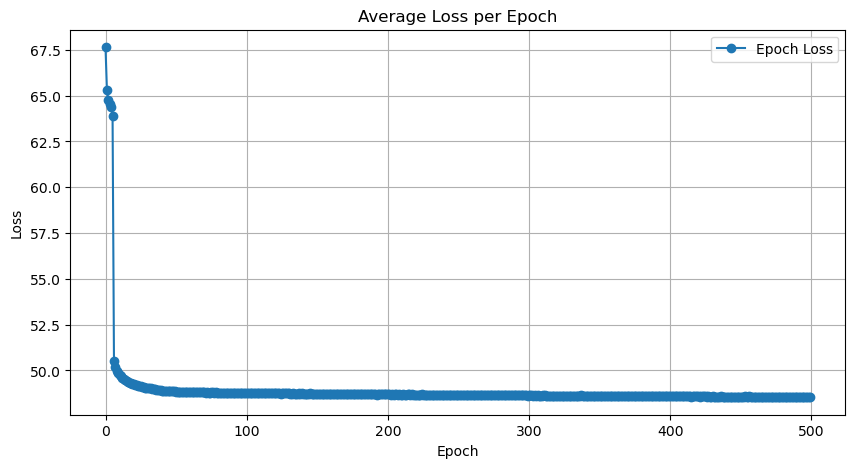

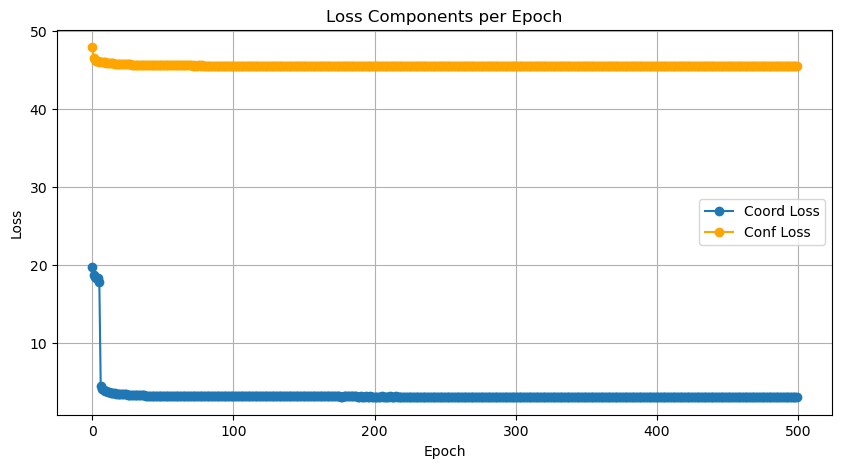

In [5]:
import matplotlib.pyplot as plt

epoch_losses = [record['epoch_loss'] for record in loss_records]
coord_losses = [record['coord_loss'] for record in loss_records]
conf_losses = [record['conf_loss'] for record in loss_records]

plt.figure(figsize=(10, 5))
plt.plot(epoch_losses, label='Epoch Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(coord_losses, label='Coord Loss', marker='o')
plt.plot(conf_losses, label='Conf Loss', marker='o', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Components per Epoch')
plt.legend()
plt.grid(True)
plt.show()


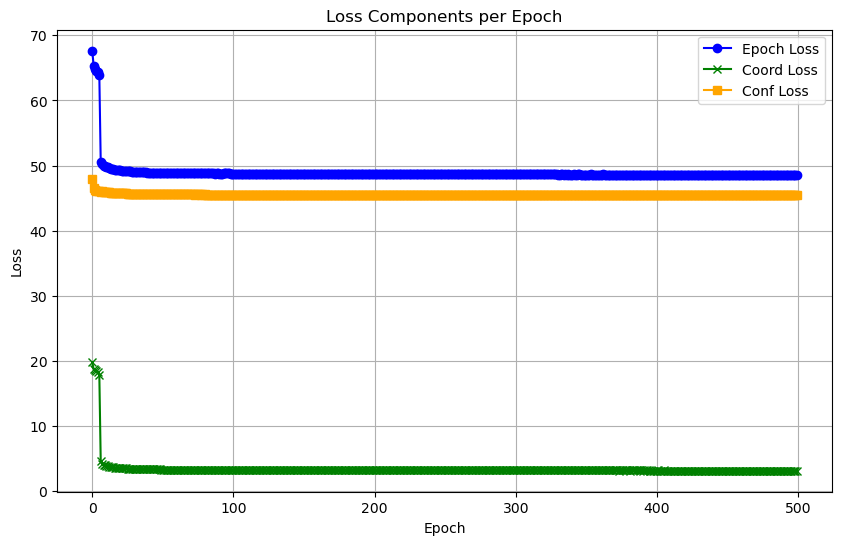

In [6]:
import matplotlib.pyplot as plt

epoch_losses = [record['epoch_loss'] for record in loss_records]
coord_losses = [record['coord_loss'] for record in loss_records]
conf_losses = [record['conf_loss'] for record in loss_records]

plt.figure(figsize=(10, 6))
plt.plot(epoch_losses, label='Epoch Loss', marker='o', color='blue')
plt.plot(coord_losses, label='Coord Loss', marker='x', color='green')
plt.plot(conf_losses, label='Conf Loss', marker='s', color='orange')

plt.title('Loss Components per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()  
plt.grid(True)
plt.show()


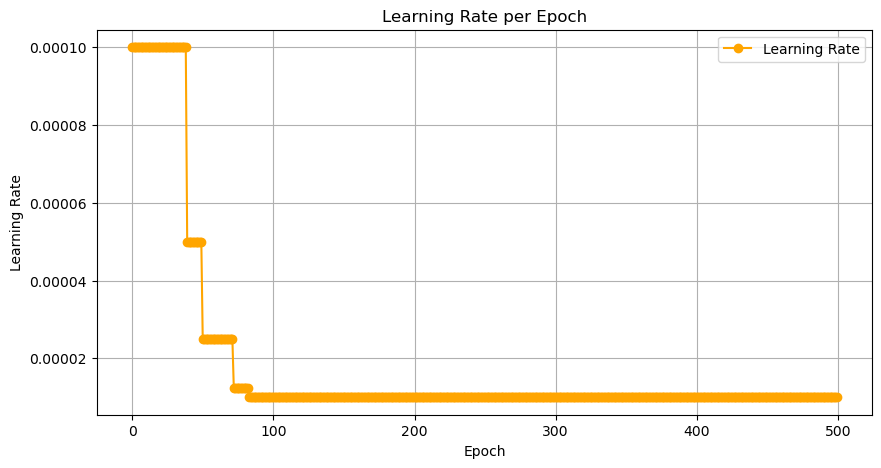

In [7]:
# 绘制学习率变化曲线
plt.figure(figsize=(10, 5))
plt.plot(lr_history, label='Learning Rate', marker='o', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate per Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Save the retrained model
torch.save(model.state_dict(), 'tinyyolo_person_only_500_epoch.pt')

# Step2: Batch norm inference optimization

In [10]:
print(model)

TinyYoloV2(
  (pad): ReflectionPad2d((0, 1, 0, 1))
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(256, 512, kernel_size=(3, 3), stride=

In [11]:
import torch
from torch.nn.utils import fuse_conv_bn_eval
from tinyyolov2 import TinyYoloV2

model = TinyYoloV2(num_classes=1)
model.load_state_dict(torch.load('tinyyolo_person_only_100_epoch.pt'))
model.eval()

print("--------------------Model before fusion--------------------")
print(model)

# Fusion of Convolutional Layer and BatchNorm Layer
def fuse_layers(model):
    model.conv1 = fuse_conv_bn_eval(model.conv1, model.bn1)
    del model.bn1

    model.conv2 = fuse_conv_bn_eval(model.conv2, model.bn2)
    del model.bn2

    model.conv3 = fuse_conv_bn_eval(model.conv3, model.bn3)
    del model.bn3

    model.conv4 = fuse_conv_bn_eval(model.conv4, model.bn4)
    del model.bn4

    model.conv5 = fuse_conv_bn_eval(model.conv5, model.bn5)
    del model.bn5

    model.conv6 = fuse_conv_bn_eval(model.conv6, model.bn6)
    del model.bn6

    model.conv7 = fuse_conv_bn_eval(model.conv7, model.bn7)
    del model.bn7

    model.conv8 = fuse_conv_bn_eval(model.conv8, model.bn8)
    del model.bn8

fuse_layers(model)

torch.save(model.state_dict(), 'tinyyolo_fused_bn.pt')
print("BatchNorm layers have been fused successfully!")

--------------------Model before fusion--------------------
TinyYoloV2(
  (pad): ReflectionPad2d((0, 1, 0, 1))
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

/var/folders/3p/yjsjgtxs5w75lv_wclnr3n0c0000gn/T/ipykernel_55296/3800765194.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('tinyyolo_pe

In [12]:
# Check if it correctly fused
print("--------------------Model after fusion--------------------")
print(model)

--------------------Model after fusion--------------------
TinyYoloV2(
  (pad): ReflectionPad2d((0, 1, 0, 1))
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(1024, 30, kernel_size=(1, 1), stride=(1, 1))
)


# Step3: Pruning

In [13]:
import torch
from tinyyolov2_fused import TinyYoloV2_Fused

# Load model after fusion
model = TinyYoloV2_Fused(num_classes=1)
model.load_state_dict(torch.load('tinyyolo_fused_bn.pt'))
# sd = torch.load("voc_pretrained.pt")
sd = torch.load("tinyyolo_person_only_500_epoch.pt")

model.eval()


/var/folders/3p/yjsjgtxs5w75lv_wclnr3n0c0000gn/T/ipykernel_55296/100862234.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('tinyyolo_fus

TinyYoloV2_Fused(
  (pad): ReflectionPad2d((0, 1, 0, 1))
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(1024, 30, kernel_size=(1, 1), stride=(1, 1))
)

In [14]:
from torch.nn.utils import prune

def prune_model(model, amount=0.2):
    """
    This is just logical pruning, which will generate weight_mask but will not change the number of channels.
    """
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            # L1 Pruning
            prune.ln_structured(module, name="weight", amount=amount, n=1, dim=0)
            print(f"Structurally pruned {name} by {amount*100}%")

prune_model(model, amount=0.2)
'''
Now each convolutional layer has a weight_orig + weight_mask; the shape remains the same, but some channels are set to 0.
'''

Structurally pruned conv1 by 20.0%
Structurally pruned conv2 by 20.0%
Structurally pruned conv3 by 20.0%
Structurally pruned conv4 by 20.0%
Structurally pruned conv5 by 20.0%
Structurally pruned conv6 by 20.0%
Structurally pruned conv7 by 20.0%
Structurally pruned conv8 by 20.0%
Structurally pruned conv9 by 20.0%


'\nNow each convolutional layer has a weight_orig + weight_mask; the shape remains the same, but some channels are set to 0.\n'

In [15]:
def get_unpruned_out_channels(module):
    """
    For Conv2d that has been structured pruned, return the retained out_channels index list
    """
    mask = module.weight_mask  # [out_ch, in_ch, k, k]
    # Sum each out_channel to see if the channel is all 0
    # If non-zero, it means it is retained
    per_channel_sum = mask.view(mask.size(0), -1).sum(dim=1)  # shape: [out_ch]
    idx_to_keep = (per_channel_sum != 0).nonzero(as_tuple=True)[0].tolist()
    return idx_to_keep


In [16]:
import torch.nn as nn

def create_pruned_conv2d(old_conv, in_idx, out_idx):
    """
    Construct a new Conv2d whose in/out channels only keep the specified index.
    old_conv: original Conv2d
    in_idx: input channel index to keep 
    out_idx: output channel index to keep
    """
    # Create a new Conv2d with the same convolution parameters as old_conv, but the in/out channels are changed to the reserved number.
    new_conv = nn.Conv2d(
        in_channels=len(in_idx),
        out_channels=len(out_idx),
        kernel_size=old_conv.kernel_size,
        stride=old_conv.stride,
        padding=old_conv.padding,
        dilation=old_conv.dilation,
        groups=1,  
        bias=(old_conv.bias is not None)
    )

    # Copy the weight
    # old_conv.weight.shape = [outC, inC, kH, kW]
    with torch.no_grad():
        # Filter out_idx first and then filter in_idx
        w = old_conv.weight.data[out_idx, :, :, :][:, in_idx, :, :].clone()
        new_conv.weight.data = w

        # Copy bias
        if old_conv.bias is not None:
            new_conv.bias.data = old_conv.bias.data[out_idx].clone()

    return new_conv


In [17]:
def build_pruned_tinyyolo(original_model: TinyYoloV2_Fused):
    """
    Based on the original_model (with weight_mask) that has been structured pruned, create and return a pruned_model with true channel reduction.
    """
    # 1) Construct a similar TinyYoloV2_Fused structure to carry the new model
    pruned_model = TinyYoloV2_Fused(num_classes=original_model.num_classes)
    # synchronize anchors
    pruned_model.anchors = original_model.anchors.clone()

    # 2) Name of all conv. layers
    conv_names = [f"conv{i}" for i in range(1, 10)]  # ["conv1", "conv2", ..., "conv9"]

    # 3) Prepare a current input channel index (inherited from the previous layer output)
    in_idx = [0, 1, 2]  # The first convolutional layer input is RGB (3 channels), corresponding to index = [0, 1, 2]

    for i, conv_name in enumerate(conv_names):
        old_conv = getattr(original_model, conv_name)
        
        # If it is conv9, don't prune its output channels, because it corresponds to the predicted output of YOLO
        if conv_name != "conv9":
            out_idx = get_unpruned_out_channels(old_conv)  
        else:
            out_idx = list(range(old_conv.out_channels))  

        # Create a new pruned Conv and set into pruned_model
        new_conv = create_pruned_conv2d(old_conv, in_idx, out_idx)
        setattr(pruned_model, conv_name, new_conv)

        # The input channel index of the next convolutional layer is the out_idx of the current layer.
        in_idx = out_idx

    return pruned_model


In [18]:
pruned_model = build_pruned_tinyyolo(model)

In [19]:
# Check parameters before pruning
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        print(f"After pruning {name}:")
        print(f"Weight shape: {module.weight.shape}")
        print()

print("--------------------------------------------------------------")

# Check parameters after pruning
for name, module in pruned_model.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        print(f"After pruning {name}:")
        print(f"Weight shape: {module.weight.shape}")
        print()


After pruning conv1:
Weight shape: torch.Size([16, 3, 3, 3])

After pruning conv2:
Weight shape: torch.Size([32, 16, 3, 3])

After pruning conv3:
Weight shape: torch.Size([64, 32, 3, 3])

After pruning conv4:
Weight shape: torch.Size([128, 64, 3, 3])

After pruning conv5:
Weight shape: torch.Size([256, 128, 3, 3])

After pruning conv6:
Weight shape: torch.Size([512, 256, 3, 3])

After pruning conv7:
Weight shape: torch.Size([1024, 512, 3, 3])

After pruning conv8:
Weight shape: torch.Size([1024, 1024, 3, 3])

After pruning conv9:
Weight shape: torch.Size([30, 1024, 1, 1])

--------------------------------------------------------------
After pruning conv1:
Weight shape: torch.Size([13, 3, 3, 3])

After pruning conv2:
Weight shape: torch.Size([26, 13, 3, 3])

After pruning conv3:
Weight shape: torch.Size([51, 26, 3, 3])

After pruning conv4:
Weight shape: torch.Size([102, 51, 3, 3])

After pruning conv5:
Weight shape: torch.Size([205, 102, 3, 3])

After pruning conv6:
Weight shape: torch

In [21]:
anchors_5=(
        (0.39765027, 0.5792138),
        (0.04936575, 0.09369813),
        (0.12444213, 0.25251988),
        (0.6931115,  0.72179604),
        (0.22943892, 0.44076216))



print(model)
print(model.anchors)
model.eval()

TinyYoloV2_Fused(
  (pad): ReflectionPad2d((0, 1, 0, 1))
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(1024, 30, kernel_size=(1, 1), stride=(1, 1))
)
tensor([[0.3977, 0.5792],
        [0.0494, 0.0937],
        [0.1244, 0.2525],
        [0.6931, 0.7218],
        [0.2294, 0.4408]])


TinyYoloV2_Fused(
  (pad): ReflectionPad2d((0, 1, 0, 1))
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(1024, 30, kernel_size=(1, 1), stride=(1, 1))
)

In [22]:
from utils.loss import YoloLoss
from torch.optim.lr_scheduler import StepLR
import tqdm
from utils.dataloader import VOCDataLoaderPerson

loader = VOCDataLoaderPerson(train=True, batch_size=32)

threshold = 0.3
lambda_noobj=0.5
lambda_obj=8.0

criterion = YoloLoss(anchors=model.anchors, threshold=threshold, lambda_noobj=lambda_noobj, lambda_obj=lambda_obj)
print(criterion.anchors)
optimizer = torch.optim.Adam(model.conv9.parameters(), lr=1e-4)
# scheduler = StepLR(optimizer, step_size=50, gamma=0.5) # Reduce the learning rate by 50% every 10 epochs
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',   # 'min'， if "loss" is to be minimized
    factor=0.5,   # reduce 50%
    patience=10,  # If the loss does not improve after 10 epochs, reduce lr
    threshold=0.005,
    cooldown=0,
    min_lr=1e-5
)

tensor([[0.3977, 0.5792],
        [0.0494, 0.0937],
        [0.1244, 0.2525],
        [0.6931, 0.7218],
        [0.2294, 0.4408]])


In [20]:
# Retrain the pruned_model
import tqdm
from utils.loss import YoloLoss
from torch.optim.lr_scheduler import StepLR
from utils.dataloader import VOCDataLoaderPerson

pruned_model.train()

for epoch in range(100):
    
    epoch_loss_sum = 0.0
    epoch_loss_count = 0

    coord_loss_epoch_sum = 0.0  
    conf_loss_epoch_sum = 0.0
    
    # for img, target in loader:
    for _, (img, target) in tqdm.tqdm(enumerate(loader), total=len(loader)):
        # img.shape is [batch_size, 3, 320, 320]
        # target.shape is torch.Size([1, 10, 6])
        # print(f'----------Target shape: {target.shape}----------')
        # print(target)
        optimizer.zero_grad()
        output = model(img)
        loss, (loss_coord, loss_conf, loss_cls) = criterion(output, target) # To check which part of loss dominate and maybe hinder the optimization.
        loss.backward()
        optimizer.step()
    scheduler.step()
    print(f"Coord Loss: {loss_coord}, Conf Loss: {loss_conf}, Class Loss: {loss_cls}")
    print(f"-------------------------------------------------------------------Epoch [{epoch+1}/100], Loss: {loss.item():.4f}-------------------------------------------------------------------")
    # break


  3%|█▎                                           | 61/2142 [00:05<02:58, 11.68it/s]


KeyboardInterrupt: 

In [ ]:
# Retrain the model
model.train()

# For visualization
loss_records = []
lr_history = []

count = 500
for epoch in range(count):
    
    epoch_loss_sum = 0.0
    epoch_loss_count = 0

    coord_loss_epoch_sum = 0.0  
    conf_loss_epoch_sum = 0.0  
    
    for _, (img, target) in tqdm.tqdm(enumerate(loader), total=len(loader)):
        optimizer.zero_grad()
        output = model(img)
        loss, (loss_coord, loss_conf, loss_cls) = criterion(output, target) # To check which part of loss dominate and maybe hinder the optimization.
        loss.backward()
        
        # To calculate the dynamic max norm
        with torch.no_grad():
            model.eval()
            total_norm = 0
            for param in model.parameters():
                if param.grad is not None:
                    param_norm = param.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** 0.5
            
        model.train() 

        dynamic_max_norm = total_norm * 0.8 
        torch.nn.utils.clip_grad_norm_(model.conv9.parameters(), max_norm=dynamic_max_norm)
        optimizer.step()

        epoch_loss_sum += loss.item()
        coord_loss_epoch_sum += loss_coord.item()
        conf_loss_epoch_sum += loss_conf.item()
        epoch_loss_count += 1
        
    if epoch_loss_count > 0:
        avg_epoch_loss = epoch_loss_sum / epoch_loss_count
        avg_coord_loss = coord_loss_epoch_sum / epoch_loss_count
        avg_conf_loss = conf_loss_epoch_sum / epoch_loss_count
    else:
        avg_epoch_loss = avg_coord_loss = avg_conf_loss = 0.0

    scheduler.step(avg_epoch_loss)

    loss_records.append({
        'epoch_loss': avg_epoch_loss,
        'coord_loss': avg_coord_loss,
        'conf_loss': avg_conf_loss,
    })
    lr_history.append(optimizer.param_groups[0]['lr'])
    
    
    print(f"Coord Loss: {loss_coord}, Conf Loss: {loss_conf}, Class Loss: {loss_cls}")
    print(f"Epoch [{epoch+1}/{count}], Avg Loss: {avg_epoch_loss:.4f}, Avg Coord Loss: {avg_coord_loss:.4f}, Avg Conf Loss: {avg_conf_loss:.4f}, Current LR: {optimizer.param_groups[0]['lr']:.6f}")
    print(f"-------------------------------------------------------------------Epoch [{epoch+1}/{count}], Loss: {loss.item():.4f}-------------------------------------------------------------------")

In [23]:
from utils.loss import YoloLoss
from torch.optim.lr_scheduler import StepLR
import tqdm
from utils.dataloader import VOCDataLoaderPerson

loader = VOCDataLoaderPerson(train=True, batch_size=32)

threshold = 0.3
lambda_noobj=0.5
lambda_obj=8.0

criterion = YoloLoss(anchors=model.anchors, threshold=threshold, lambda_noobj=lambda_noobj, lambda_obj=lambda_obj)
optimizer = torch.optim.Adam(pruned_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',   # 'min'， if "loss" is to be minimized
    factor=0.5,   # reduce 50%
    patience=10,  # If the loss does not improve after 10 epochs, reduce lr
    threshold=0.005,
    cooldown=0,
    min_lr=1e-5
)

In [26]:
# Retrain the pruned_model
pruned_model.train()

# For visualization
loss_records = []
lr_history = []

count = 100
for epoch in range(count):
    # for img, target in loader:
    for _, (img, target) in tqdm.tqdm(enumerate(loader), total=len(loader)):
        optimizer.zero_grad()
        output = model(img)
        loss, (loss_coord, loss_conf, loss_cls) = criterion(output, target) # To check which part of loss dominate and maybe hinder the optimization.
        loss.backward()
        
        # To calculate the dynamic max norm
        with torch.no_grad():
            model.eval()
            total_norm = 0
            for param in model.parameters():
                if param.grad is not None:
                    param_norm = param.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** 0.5
            
        pruned_model.train() 

        dynamic_max_norm = total_norm * 0.8 
        torch.nn.utils.clip_grad_norm_(model.conv9.parameters(), max_norm=dynamic_max_norm)
        optimizer.step()

        epoch_loss_sum += loss.item()
        coord_loss_epoch_sum += loss_coord.item()
        conf_loss_epoch_sum += loss_conf.item()
        epoch_loss_count += 1
        
    if epoch_loss_count > 0:
        avg_epoch_loss = epoch_loss_sum / epoch_loss_count
        avg_coord_loss = coord_loss_epoch_sum / epoch_loss_count
        avg_conf_loss = conf_loss_epoch_sum / epoch_loss_count
    else:
        avg_epoch_loss = avg_coord_loss = avg_conf_loss = 0.0

    scheduler.step(avg_epoch_loss)

    loss_records.append({
        'epoch_loss': avg_epoch_loss,
        'coord_loss': avg_coord_loss,
        'conf_loss': avg_conf_loss,
    })
    lr_history.append(optimizer.param_groups[0]['lr'])


    print(f"Coord Loss: {loss_coord}, Conf Loss: {loss_conf}, Class Loss: {loss_cls}")
    print(f"Epoch [{epoch+1}/{count}], Avg Loss: {avg_epoch_loss:.4f}, Avg Coord Loss: {avg_coord_loss:.4f}, Avg Conf Loss: {avg_conf_loss:.4f}, Current LR: {optimizer.param_groups[0]['lr']:.6f}")
    print(f"-------------------------------------------------------------------Epoch [{epoch+1}/{count}], Loss: {loss.item():.4f}-------------------------------------------------------------------")


100%|███████████████████████████████████████████████| 67/67 [02:18<00:00,  2.06s/it]


Coord Loss: 5.234657287597656, Conf Loss: 46.55559158325195, Class Loss: 0.0
Epoch [1/100], Avg Loss: 58.7373, Avg Coord Loss: 12.3458, Avg Conf Loss: 46.3916, Current LR: 0.000100
-------------------------------------------------------------------Epoch [1/100], Loss: 51.7902-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:15<00:00,  2.02s/it]


Coord Loss: 5.229690074920654, Conf Loss: 46.550052642822266, Class Loss: 0.0
Epoch [2/100], Avg Loss: 58.1272, Avg Coord Loss: 11.7276, Avg Conf Loss: 46.3996, Current LR: 0.000100
-------------------------------------------------------------------Epoch [2/100], Loss: 51.7797-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:17<00:00,  2.05s/it]


Coord Loss: 5.246947288513184, Conf Loss: 46.55378723144531, Class Loss: 0.0
Epoch [3/100], Avg Loss: 57.6118, Avg Coord Loss: 11.2052, Avg Conf Loss: 46.4066, Current LR: 0.000100
-------------------------------------------------------------------Epoch [3/100], Loss: 51.8007-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:17<00:00,  2.05s/it]


Coord Loss: 5.238656520843506, Conf Loss: 46.56467056274414, Class Loss: 0.0
Epoch [4/100], Avg Loss: 57.1707, Avg Coord Loss: 10.7582, Avg Conf Loss: 46.4125, Current LR: 0.000050
-------------------------------------------------------------------Epoch [4/100], Loss: 51.8033-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:14<00:00,  2.00s/it]


Coord Loss: 5.2352213859558105, Conf Loss: 46.55159378051758, Class Loss: 0.0
Epoch [5/100], Avg Loss: 56.7889, Avg Coord Loss: 10.3712, Avg Conf Loss: 46.4177, Current LR: 0.000050
-------------------------------------------------------------------Epoch [5/100], Loss: 51.7868-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:08<00:00,  1.92s/it]


Coord Loss: 5.2389607429504395, Conf Loss: 46.55356216430664, Class Loss: 0.0
Epoch [6/100], Avg Loss: 56.4550, Avg Coord Loss: 10.0329, Avg Conf Loss: 46.4221, Current LR: 0.000050
-------------------------------------------------------------------Epoch [6/100], Loss: 51.7925-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:09<00:00,  1.93s/it]


Coord Loss: 5.23155403137207, Conf Loss: 46.55549240112305, Class Loss: 0.0
Epoch [7/100], Avg Loss: 56.1609, Avg Coord Loss: 9.7348, Avg Conf Loss: 46.4260, Current LR: 0.000050
-------------------------------------------------------------------Epoch [7/100], Loss: 51.7870-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:09<00:00,  1.93s/it]


Coord Loss: 5.237034797668457, Conf Loss: 46.55976867675781, Class Loss: 0.0
Epoch [8/100], Avg Loss: 55.8997, Avg Coord Loss: 9.4701, Avg Conf Loss: 46.4296, Current LR: 0.000050
-------------------------------------------------------------------Epoch [8/100], Loss: 51.7968-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:09<00:00,  1.93s/it]


Coord Loss: 5.246121406555176, Conf Loss: 46.5621223449707, Class Loss: 0.0
Epoch [9/100], Avg Loss: 55.6660, Avg Coord Loss: 9.2333, Avg Conf Loss: 46.4327, Current LR: 0.000050
-------------------------------------------------------------------Epoch [9/100], Loss: 51.8082-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:09<00:00,  1.93s/it]


Coord Loss: 5.226829528808594, Conf Loss: 46.564395904541016, Class Loss: 0.0
Epoch [10/100], Avg Loss: 55.4558, Avg Coord Loss: 9.0203, Avg Conf Loss: 46.4356, Current LR: 0.000050
-------------------------------------------------------------------Epoch [10/100], Loss: 51.7912-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:09<00:00,  1.93s/it]


Coord Loss: 5.234177589416504, Conf Loss: 46.54179763793945, Class Loss: 0.0
Epoch [11/100], Avg Loss: 55.2658, Avg Coord Loss: 8.8277, Avg Conf Loss: 46.4381, Current LR: 0.000050
-------------------------------------------------------------------Epoch [11/100], Loss: 51.7760-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:09<00:00,  1.93s/it]


Coord Loss: 5.237141132354736, Conf Loss: 46.54924392700195, Class Loss: 0.0
Epoch [12/100], Avg Loss: 55.0931, Avg Coord Loss: 8.6527, Avg Conf Loss: 46.4405, Current LR: 0.000050
-------------------------------------------------------------------Epoch [12/100], Loss: 51.7864-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:09<00:00,  1.93s/it]


Coord Loss: 5.215527534484863, Conf Loss: 46.56102752685547, Class Loss: 0.0
Epoch [13/100], Avg Loss: 54.9357, Avg Coord Loss: 8.4931, Avg Conf Loss: 46.4427, Current LR: 0.000050
-------------------------------------------------------------------Epoch [13/100], Loss: 51.7766-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:09<00:00,  1.93s/it]


Coord Loss: 5.21666145324707, Conf Loss: 46.5618782043457, Class Loss: 0.0
Epoch [14/100], Avg Loss: 54.7914, Avg Coord Loss: 8.3468, Avg Conf Loss: 46.4447, Current LR: 0.000050
-------------------------------------------------------------------Epoch [14/100], Loss: 51.7785-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:09<00:00,  1.93s/it]


Coord Loss: 5.237113952636719, Conf Loss: 46.558372497558594, Class Loss: 0.0
Epoch [15/100], Avg Loss: 54.6587, Avg Coord Loss: 8.2122, Avg Conf Loss: 46.4464, Current LR: 0.000050
-------------------------------------------------------------------Epoch [15/100], Loss: 51.7955-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:09<00:00,  1.93s/it]


Coord Loss: 5.240753173828125, Conf Loss: 46.56956100463867, Class Loss: 0.0
Epoch [16/100], Avg Loss: 54.5362, Avg Coord Loss: 8.0881, Avg Conf Loss: 46.4481, Current LR: 0.000050
-------------------------------------------------------------------Epoch [16/100], Loss: 51.8103-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:09<00:00,  1.93s/it]


Coord Loss: 5.222991466522217, Conf Loss: 46.54854965209961, Class Loss: 0.0
Epoch [17/100], Avg Loss: 54.4229, Avg Coord Loss: 7.9733, Avg Conf Loss: 46.4496, Current LR: 0.000050
-------------------------------------------------------------------Epoch [17/100], Loss: 51.7715-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:10<00:00,  1.94s/it]


Coord Loss: 5.240664958953857, Conf Loss: 46.54989242553711, Class Loss: 0.0
Epoch [18/100], Avg Loss: 54.3175, Avg Coord Loss: 7.8666, Avg Conf Loss: 46.4510, Current LR: 0.000050
-------------------------------------------------------------------Epoch [18/100], Loss: 51.7906-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:17<00:00,  2.05s/it]


Coord Loss: 5.227629661560059, Conf Loss: 46.558040618896484, Class Loss: 0.0
Epoch [19/100], Avg Loss: 54.2195, Avg Coord Loss: 7.7672, Avg Conf Loss: 46.4523, Current LR: 0.000050
-------------------------------------------------------------------Epoch [19/100], Loss: 51.7857-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:21<00:00,  2.11s/it]


Coord Loss: 5.236656665802002, Conf Loss: 46.553016662597656, Class Loss: 0.0
Epoch [20/100], Avg Loss: 54.1280, Avg Coord Loss: 7.6745, Avg Conf Loss: 46.4534, Current LR: 0.000050
-------------------------------------------------------------------Epoch [20/100], Loss: 51.7897-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:16<00:00,  2.04s/it]


Coord Loss: 5.237637996673584, Conf Loss: 46.5443115234375, Class Loss: 0.0
Epoch [21/100], Avg Loss: 54.0425, Avg Coord Loss: 7.5879, Avg Conf Loss: 46.4546, Current LR: 0.000050
-------------------------------------------------------------------Epoch [21/100], Loss: 51.7819-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:14<00:00,  2.00s/it]


Coord Loss: 5.216122150421143, Conf Loss: 46.5710334777832, Class Loss: 0.0
Epoch [22/100], Avg Loss: 53.9624, Avg Coord Loss: 7.5067, Avg Conf Loss: 46.4557, Current LR: 0.000050
-------------------------------------------------------------------Epoch [22/100], Loss: 51.7872-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:14<00:00,  2.00s/it]


Coord Loss: 5.222188472747803, Conf Loss: 46.5523681640625, Class Loss: 0.0
Epoch [23/100], Avg Loss: 53.8871, Avg Coord Loss: 7.4304, Avg Conf Loss: 46.4567, Current LR: 0.000050
-------------------------------------------------------------------Epoch [23/100], Loss: 51.7746-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:13<00:00,  1.99s/it]


Coord Loss: 5.251158714294434, Conf Loss: 46.55329513549805, Class Loss: 0.0
Epoch [24/100], Avg Loss: 53.8163, Avg Coord Loss: 7.3587, Avg Conf Loss: 46.4576, Current LR: 0.000050
-------------------------------------------------------------------Epoch [24/100], Loss: 51.8045-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:24<00:00,  2.16s/it]


Coord Loss: 5.239656448364258, Conf Loss: 46.55445098876953, Class Loss: 0.0
Epoch [25/100], Avg Loss: 53.7496, Avg Coord Loss: 7.2911, Avg Conf Loss: 46.4585, Current LR: 0.000050
-------------------------------------------------------------------Epoch [25/100], Loss: 51.7941-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:12<00:00,  1.98s/it]


Coord Loss: 5.2350969314575195, Conf Loss: 46.56415939331055, Class Loss: 0.0
Epoch [26/100], Avg Loss: 53.6865, Avg Coord Loss: 7.2272, Avg Conf Loss: 46.4593, Current LR: 0.000050
-------------------------------------------------------------------Epoch [26/100], Loss: 51.7993-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:17<00:00,  2.05s/it]


Coord Loss: 5.22967004776001, Conf Loss: 46.55768966674805, Class Loss: 0.0
Epoch [27/100], Avg Loss: 53.6269, Avg Coord Loss: 7.1668, Avg Conf Loss: 46.4601, Current LR: 0.000050
-------------------------------------------------------------------Epoch [27/100], Loss: 51.7874-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:18<00:00,  2.07s/it]


Coord Loss: 5.230222225189209, Conf Loss: 46.559165954589844, Class Loss: 0.0
Epoch [28/100], Avg Loss: 53.5705, Avg Coord Loss: 7.1096, Avg Conf Loss: 46.4609, Current LR: 0.000050
-------------------------------------------------------------------Epoch [28/100], Loss: 51.7894-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:12<00:00,  1.98s/it]


Coord Loss: 5.249626159667969, Conf Loss: 46.54838562011719, Class Loss: 0.0
Epoch [29/100], Avg Loss: 53.5169, Avg Coord Loss: 7.0553, Avg Conf Loss: 46.4616, Current LR: 0.000050
-------------------------------------------------------------------Epoch [29/100], Loss: 51.7980-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:10<00:00,  1.95s/it]


Coord Loss: 5.237630367279053, Conf Loss: 46.550838470458984, Class Loss: 0.0
Epoch [30/100], Avg Loss: 53.4660, Avg Coord Loss: 7.0038, Avg Conf Loss: 46.4623, Current LR: 0.000050
-------------------------------------------------------------------Epoch [30/100], Loss: 51.7885-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:11<00:00,  1.96s/it]


Coord Loss: 5.238351345062256, Conf Loss: 46.563316345214844, Class Loss: 0.0
Epoch [31/100], Avg Loss: 53.4176, Avg Coord Loss: 6.9547, Avg Conf Loss: 46.4629, Current LR: 0.000050
-------------------------------------------------------------------Epoch [31/100], Loss: 51.8017-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:11<00:00,  1.96s/it]


Coord Loss: 5.221693515777588, Conf Loss: 46.55904769897461, Class Loss: 0.0
Epoch [32/100], Avg Loss: 53.3716, Avg Coord Loss: 6.9081, Avg Conf Loss: 46.4635, Current LR: 0.000050
-------------------------------------------------------------------Epoch [32/100], Loss: 51.7807-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:11<00:00,  1.96s/it]


Coord Loss: 5.246552467346191, Conf Loss: 46.553466796875, Class Loss: 0.0
Epoch [33/100], Avg Loss: 53.3276, Avg Coord Loss: 6.8636, Avg Conf Loss: 46.4641, Current LR: 0.000050
-------------------------------------------------------------------Epoch [33/100], Loss: 51.8000-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:14<00:00,  2.01s/it]


Coord Loss: 5.2102274894714355, Conf Loss: 46.541099548339844, Class Loss: 0.0
Epoch [34/100], Avg Loss: 53.2858, Avg Coord Loss: 6.8211, Avg Conf Loss: 46.4647, Current LR: 0.000050
-------------------------------------------------------------------Epoch [34/100], Loss: 51.7513-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:16<00:00,  2.03s/it]


Coord Loss: 5.261784553527832, Conf Loss: 46.546287536621094, Class Loss: 0.0
Epoch [35/100], Avg Loss: 53.2457, Avg Coord Loss: 6.7805, Avg Conf Loss: 46.4652, Current LR: 0.000050
-------------------------------------------------------------------Epoch [35/100], Loss: 51.8081-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:15<00:00,  2.02s/it]


Coord Loss: 5.228748798370361, Conf Loss: 46.55598068237305, Class Loss: 0.0
Epoch [36/100], Avg Loss: 53.2074, Avg Coord Loss: 6.7417, Avg Conf Loss: 46.4657, Current LR: 0.000050
-------------------------------------------------------------------Epoch [36/100], Loss: 51.7847-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:15<00:00,  2.03s/it]


Coord Loss: 5.256100654602051, Conf Loss: 46.54020309448242, Class Loss: 0.0
Epoch [37/100], Avg Loss: 53.1708, Avg Coord Loss: 6.7046, Avg Conf Loss: 46.4662, Current LR: 0.000050
-------------------------------------------------------------------Epoch [37/100], Loss: 51.7963-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:15<00:00,  2.03s/it]


Coord Loss: 5.219217777252197, Conf Loss: 46.54956817626953, Class Loss: 0.0
Epoch [38/100], Avg Loss: 53.1356, Avg Coord Loss: 6.6689, Avg Conf Loss: 46.4667, Current LR: 0.000050
-------------------------------------------------------------------Epoch [38/100], Loss: 51.7688-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:15<00:00,  2.03s/it]


Coord Loss: 5.220304012298584, Conf Loss: 46.554786682128906, Class Loss: 0.0
Epoch [39/100], Avg Loss: 53.1019, Avg Coord Loss: 6.6347, Avg Conf Loss: 46.4671, Current LR: 0.000050
-------------------------------------------------------------------Epoch [39/100], Loss: 51.7751-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:16<00:00,  2.03s/it]


Coord Loss: 5.248650074005127, Conf Loss: 46.5667839050293, Class Loss: 0.0
Epoch [40/100], Avg Loss: 53.0696, Avg Coord Loss: 6.6020, Avg Conf Loss: 46.4676, Current LR: 0.000050
-------------------------------------------------------------------Epoch [40/100], Loss: 51.8154-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:16<00:00,  2.03s/it]


Coord Loss: 5.238008499145508, Conf Loss: 46.54255294799805, Class Loss: 0.0
Epoch [41/100], Avg Loss: 53.0385, Avg Coord Loss: 6.5705, Avg Conf Loss: 46.4680, Current LR: 0.000050
-------------------------------------------------------------------Epoch [41/100], Loss: 51.7806-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:16<00:00,  2.04s/it]


Coord Loss: 5.231914043426514, Conf Loss: 46.5634880065918, Class Loss: 0.0
Epoch [42/100], Avg Loss: 53.0087, Avg Coord Loss: 6.5403, Avg Conf Loss: 46.4684, Current LR: 0.000050
-------------------------------------------------------------------Epoch [42/100], Loss: 51.7954-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:16<00:00,  2.04s/it]


Coord Loss: 5.238075256347656, Conf Loss: 46.55664825439453, Class Loss: 0.0
Epoch [43/100], Avg Loss: 52.9800, Avg Coord Loss: 6.5112, Avg Conf Loss: 46.4688, Current LR: 0.000050
-------------------------------------------------------------------Epoch [43/100], Loss: 51.7947-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:16<00:00,  2.04s/it]


Coord Loss: 5.249108791351318, Conf Loss: 46.56144332885742, Class Loss: 0.0
Epoch [44/100], Avg Loss: 52.9524, Avg Coord Loss: 6.4832, Avg Conf Loss: 46.4692, Current LR: 0.000050
-------------------------------------------------------------------Epoch [44/100], Loss: 51.8106-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:16<00:00,  2.04s/it]


Coord Loss: 5.24595832824707, Conf Loss: 46.55997848510742, Class Loss: 0.0
Epoch [45/100], Avg Loss: 52.9257, Avg Coord Loss: 6.4561, Avg Conf Loss: 46.4695, Current LR: 0.000050
-------------------------------------------------------------------Epoch [45/100], Loss: 51.8059-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:16<00:00,  2.04s/it]


Coord Loss: 5.229877948760986, Conf Loss: 46.56880187988281, Class Loss: 0.0
Epoch [46/100], Avg Loss: 52.9000, Avg Coord Loss: 6.4301, Avg Conf Loss: 46.4699, Current LR: 0.000050
-------------------------------------------------------------------Epoch [46/100], Loss: 51.7987-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:16<00:00,  2.04s/it]


Coord Loss: 5.221177101135254, Conf Loss: 46.54141616821289, Class Loss: 0.0
Epoch [47/100], Avg Loss: 52.8752, Avg Coord Loss: 6.4049, Avg Conf Loss: 46.4703, Current LR: 0.000050
-------------------------------------------------------------------Epoch [47/100], Loss: 51.7626-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:16<00:00,  2.04s/it]


Coord Loss: 5.237637996673584, Conf Loss: 46.57796859741211, Class Loss: 0.0
Epoch [48/100], Avg Loss: 52.8512, Avg Coord Loss: 6.3807, Avg Conf Loss: 46.4706, Current LR: 0.000050
-------------------------------------------------------------------Epoch [48/100], Loss: 51.8156-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:16<00:00,  2.04s/it]


Coord Loss: 5.24006986618042, Conf Loss: 46.557373046875, Class Loss: 0.0
Epoch [49/100], Avg Loss: 52.8281, Avg Coord Loss: 6.3572, Avg Conf Loss: 46.4709, Current LR: 0.000050
-------------------------------------------------------------------Epoch [49/100], Loss: 51.7974-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:16<00:00,  2.04s/it]


Coord Loss: 5.245530128479004, Conf Loss: 46.53944778442383, Class Loss: 0.0
Epoch [50/100], Avg Loss: 52.8058, Avg Coord Loss: 6.3346, Avg Conf Loss: 46.4712, Current LR: 0.000050
-------------------------------------------------------------------Epoch [50/100], Loss: 51.7850-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:16<00:00,  2.04s/it]


Coord Loss: 5.231740474700928, Conf Loss: 46.553077697753906, Class Loss: 0.0
Epoch [51/100], Avg Loss: 52.7842, Avg Coord Loss: 6.3127, Avg Conf Loss: 46.4715, Current LR: 0.000050
-------------------------------------------------------------------Epoch [51/100], Loss: 51.7848-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:16<00:00,  2.03s/it]


Coord Loss: 5.2313971519470215, Conf Loss: 46.54951477050781, Class Loss: 0.0
Epoch [52/100], Avg Loss: 52.7632, Avg Coord Loss: 6.2915, Avg Conf Loss: 46.4718, Current LR: 0.000050
-------------------------------------------------------------------Epoch [52/100], Loss: 51.7809-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:16<00:00,  2.04s/it]


Coord Loss: 5.225525856018066, Conf Loss: 46.55797576904297, Class Loss: 0.0
Epoch [53/100], Avg Loss: 52.7430, Avg Coord Loss: 6.2709, Avg Conf Loss: 46.4720, Current LR: 0.000050
-------------------------------------------------------------------Epoch [53/100], Loss: 51.7835-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:16<00:00,  2.03s/it]


Coord Loss: 5.25285530090332, Conf Loss: 46.56553268432617, Class Loss: 0.0
Epoch [54/100], Avg Loss: 52.7233, Avg Coord Loss: 6.2510, Avg Conf Loss: 46.4723, Current LR: 0.000050
-------------------------------------------------------------------Epoch [54/100], Loss: 51.8184-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:16<00:00,  2.04s/it]


Coord Loss: 5.2317352294921875, Conf Loss: 46.55960464477539, Class Loss: 0.0
Epoch [55/100], Avg Loss: 52.7042, Avg Coord Loss: 6.2317, Avg Conf Loss: 46.4725, Current LR: 0.000050
-------------------------------------------------------------------Epoch [55/100], Loss: 51.7913-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:16<00:00,  2.04s/it]


Coord Loss: 5.243524074554443, Conf Loss: 46.556217193603516, Class Loss: 0.0
Epoch [56/100], Avg Loss: 52.6858, Avg Coord Loss: 6.2130, Avg Conf Loss: 46.4728, Current LR: 0.000050
-------------------------------------------------------------------Epoch [56/100], Loss: 51.7997-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:16<00:00,  2.04s/it]


Coord Loss: 5.2445068359375, Conf Loss: 46.5544319152832, Class Loss: 0.0
Epoch [57/100], Avg Loss: 52.6678, Avg Coord Loss: 6.1948, Avg Conf Loss: 46.4730, Current LR: 0.000025
-------------------------------------------------------------------Epoch [57/100], Loss: 51.7989-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:20<00:00,  2.10s/it]


Coord Loss: 5.224940776824951, Conf Loss: 46.5659294128418, Class Loss: 0.0
Epoch [58/100], Avg Loss: 52.6505, Avg Coord Loss: 6.1772, Avg Conf Loss: 46.4732, Current LR: 0.000025
-------------------------------------------------------------------Epoch [58/100], Loss: 51.7909-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:16<00:00,  2.04s/it]


Coord Loss: 5.237715721130371, Conf Loss: 46.54090881347656, Class Loss: 0.0
Epoch [59/100], Avg Loss: 52.6336, Avg Coord Loss: 6.1601, Avg Conf Loss: 46.4735, Current LR: 0.000025
-------------------------------------------------------------------Epoch [59/100], Loss: 51.7786-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:16<00:00,  2.03s/it]


Coord Loss: 5.206424236297607, Conf Loss: 46.561363220214844, Class Loss: 0.0
Epoch [60/100], Avg Loss: 52.6172, Avg Coord Loss: 6.1435, Avg Conf Loss: 46.4737, Current LR: 0.000025
-------------------------------------------------------------------Epoch [60/100], Loss: 51.7678-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:16<00:00,  2.04s/it]


Coord Loss: 5.241963863372803, Conf Loss: 46.54328155517578, Class Loss: 0.0
Epoch [61/100], Avg Loss: 52.6012, Avg Coord Loss: 6.1273, Avg Conf Loss: 46.4739, Current LR: 0.000025
-------------------------------------------------------------------Epoch [61/100], Loss: 51.7852-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:16<00:00,  2.03s/it]


Coord Loss: 5.225563049316406, Conf Loss: 46.55808639526367, Class Loss: 0.0
Epoch [62/100], Avg Loss: 52.5857, Avg Coord Loss: 6.1116, Avg Conf Loss: 46.4741, Current LR: 0.000025
-------------------------------------------------------------------Epoch [62/100], Loss: 51.7836-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:15<00:00,  2.03s/it]


Coord Loss: 5.217434883117676, Conf Loss: 46.547237396240234, Class Loss: 0.0
Epoch [63/100], Avg Loss: 52.5707, Avg Coord Loss: 6.0964, Avg Conf Loss: 46.4743, Current LR: 0.000025
-------------------------------------------------------------------Epoch [63/100], Loss: 51.7647-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:17<00:00,  2.06s/it]


Coord Loss: 5.211050510406494, Conf Loss: 46.55655288696289, Class Loss: 0.0
Epoch [64/100], Avg Loss: 52.5560, Avg Coord Loss: 6.0815, Avg Conf Loss: 46.4745, Current LR: 0.000025
-------------------------------------------------------------------Epoch [64/100], Loss: 51.7676-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:15<00:00,  2.03s/it]


Coord Loss: 5.2265543937683105, Conf Loss: 46.54848098754883, Class Loss: 0.0
Epoch [65/100], Avg Loss: 52.5418, Avg Coord Loss: 6.0671, Avg Conf Loss: 46.4747, Current LR: 0.000025
-------------------------------------------------------------------Epoch [65/100], Loss: 51.7750-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:15<00:00,  2.03s/it]


Coord Loss: 5.235250473022461, Conf Loss: 46.564842224121094, Class Loss: 0.0
Epoch [66/100], Avg Loss: 52.5279, Avg Coord Loss: 6.0530, Avg Conf Loss: 46.4749, Current LR: 0.000025
-------------------------------------------------------------------Epoch [66/100], Loss: 51.8001-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:15<00:00,  2.03s/it]


Coord Loss: 5.231348514556885, Conf Loss: 46.54233169555664, Class Loss: 0.0
Epoch [67/100], Avg Loss: 52.5143, Avg Coord Loss: 6.0393, Avg Conf Loss: 46.4751, Current LR: 0.000025
-------------------------------------------------------------------Epoch [67/100], Loss: 51.7737-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:16<00:00,  2.03s/it]


Coord Loss: 5.250864505767822, Conf Loss: 46.56694030761719, Class Loss: 0.0
Epoch [68/100], Avg Loss: 52.5012, Avg Coord Loss: 6.0259, Avg Conf Loss: 46.4753, Current LR: 0.000025
-------------------------------------------------------------------Epoch [68/100], Loss: 51.8178-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:15<00:00,  2.03s/it]


Coord Loss: 5.2446513175964355, Conf Loss: 46.544960021972656, Class Loss: 0.0
Epoch [69/100], Avg Loss: 52.4884, Avg Coord Loss: 6.0129, Avg Conf Loss: 46.4754, Current LR: 0.000025
-------------------------------------------------------------------Epoch [69/100], Loss: 51.7896-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:15<00:00,  2.03s/it]


Coord Loss: 5.231396675109863, Conf Loss: 46.5576057434082, Class Loss: 0.0
Epoch [70/100], Avg Loss: 52.4759, Avg Coord Loss: 6.0003, Avg Conf Loss: 46.4756, Current LR: 0.000013
-------------------------------------------------------------------Epoch [70/100], Loss: 51.7890-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:18<00:00,  2.07s/it]


Coord Loss: 5.230235576629639, Conf Loss: 46.544979095458984, Class Loss: 0.0
Epoch [71/100], Avg Loss: 52.4637, Avg Coord Loss: 5.9879, Avg Conf Loss: 46.4758, Current LR: 0.000013
-------------------------------------------------------------------Epoch [71/100], Loss: 51.7752-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:10<00:00,  1.95s/it]


Coord Loss: 5.229525566101074, Conf Loss: 46.57523727416992, Class Loss: 0.0
Epoch [72/100], Avg Loss: 52.4517, Avg Coord Loss: 5.9758, Avg Conf Loss: 46.4759, Current LR: 0.000013
-------------------------------------------------------------------Epoch [72/100], Loss: 51.8048-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:09<00:00,  1.94s/it]


Coord Loss: 5.229466915130615, Conf Loss: 46.560909271240234, Class Loss: 0.0
Epoch [73/100], Avg Loss: 52.4401, Avg Coord Loss: 5.9640, Avg Conf Loss: 46.4761, Current LR: 0.000013
-------------------------------------------------------------------Epoch [73/100], Loss: 51.7904-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:09<00:00,  1.93s/it]


Coord Loss: 5.2242350578308105, Conf Loss: 46.54682159423828, Class Loss: 0.0
Epoch [74/100], Avg Loss: 52.4288, Avg Coord Loss: 5.9525, Avg Conf Loss: 46.4762, Current LR: 0.000013
-------------------------------------------------------------------Epoch [74/100], Loss: 51.7711-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:09<00:00,  1.94s/it]


Coord Loss: 5.238893985748291, Conf Loss: 46.56092071533203, Class Loss: 0.0
Epoch [75/100], Avg Loss: 52.4177, Avg Coord Loss: 5.9413, Avg Conf Loss: 46.4764, Current LR: 0.000013
-------------------------------------------------------------------Epoch [75/100], Loss: 51.7998-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:09<00:00,  1.93s/it]


Coord Loss: 5.222696781158447, Conf Loss: 46.567604064941406, Class Loss: 0.0
Epoch [76/100], Avg Loss: 52.4069, Avg Coord Loss: 5.9303, Avg Conf Loss: 46.4765, Current LR: 0.000013
-------------------------------------------------------------------Epoch [76/100], Loss: 51.7903-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:09<00:00,  1.93s/it]


Coord Loss: 5.223412036895752, Conf Loss: 46.55665588378906, Class Loss: 0.0
Epoch [77/100], Avg Loss: 52.3963, Avg Coord Loss: 5.9196, Avg Conf Loss: 46.4767, Current LR: 0.000013
-------------------------------------------------------------------Epoch [77/100], Loss: 51.7801-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:09<00:00,  1.94s/it]


Coord Loss: 5.232471942901611, Conf Loss: 46.55675506591797, Class Loss: 0.0
Epoch [78/100], Avg Loss: 52.3860, Avg Coord Loss: 5.9092, Avg Conf Loss: 46.4768, Current LR: 0.000013
-------------------------------------------------------------------Epoch [78/100], Loss: 51.7892-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:09<00:00,  1.93s/it]


Coord Loss: 5.232842922210693, Conf Loss: 46.545833587646484, Class Loss: 0.0
Epoch [79/100], Avg Loss: 52.3759, Avg Coord Loss: 5.8989, Avg Conf Loss: 46.4769, Current LR: 0.000013
-------------------------------------------------------------------Epoch [79/100], Loss: 51.7787-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:09<00:00,  1.93s/it]


Coord Loss: 5.212887763977051, Conf Loss: 46.550601959228516, Class Loss: 0.0
Epoch [80/100], Avg Loss: 52.3660, Avg Coord Loss: 5.8889, Avg Conf Loss: 46.4771, Current LR: 0.000013
-------------------------------------------------------------------Epoch [80/100], Loss: 51.7635-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:09<00:00,  1.93s/it]


Coord Loss: 5.244217872619629, Conf Loss: 46.54899597167969, Class Loss: 0.0
Epoch [81/100], Avg Loss: 52.3563, Avg Coord Loss: 5.8791, Avg Conf Loss: 46.4772, Current LR: 0.000013
-------------------------------------------------------------------Epoch [81/100], Loss: 51.7932-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:09<00:00,  1.93s/it]


Coord Loss: 5.235293865203857, Conf Loss: 46.54927062988281, Class Loss: 0.0
Epoch [82/100], Avg Loss: 52.3469, Avg Coord Loss: 5.8696, Avg Conf Loss: 46.4773, Current LR: 0.000013
-------------------------------------------------------------------Epoch [82/100], Loss: 51.7846-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:09<00:00,  1.93s/it]


Coord Loss: 5.2250518798828125, Conf Loss: 46.5460319519043, Class Loss: 0.0
Epoch [83/100], Avg Loss: 52.3377, Avg Coord Loss: 5.8602, Avg Conf Loss: 46.4775, Current LR: 0.000013
-------------------------------------------------------------------Epoch [83/100], Loss: 51.7711-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:09<00:00,  1.93s/it]


Coord Loss: 5.217702388763428, Conf Loss: 46.55101776123047, Class Loss: 0.0
Epoch [84/100], Avg Loss: 52.3286, Avg Coord Loss: 5.8510, Avg Conf Loss: 46.4776, Current LR: 0.000013
-------------------------------------------------------------------Epoch [84/100], Loss: 51.7687-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:09<00:00,  1.93s/it]


Coord Loss: 5.237386703491211, Conf Loss: 46.55172348022461, Class Loss: 0.0
Epoch [85/100], Avg Loss: 52.3197, Avg Coord Loss: 5.8420, Avg Conf Loss: 46.4777, Current LR: 0.000013
-------------------------------------------------------------------Epoch [85/100], Loss: 51.7891-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:10<00:00,  1.95s/it]


Coord Loss: 5.221235275268555, Conf Loss: 46.55717849731445, Class Loss: 0.0
Epoch [86/100], Avg Loss: 52.3111, Avg Coord Loss: 5.8332, Avg Conf Loss: 46.4778, Current LR: 0.000013
-------------------------------------------------------------------Epoch [86/100], Loss: 51.7784-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:19<00:00,  2.08s/it]


Coord Loss: 5.229395389556885, Conf Loss: 46.55031204223633, Class Loss: 0.0
Epoch [87/100], Avg Loss: 52.3025, Avg Coord Loss: 5.8246, Avg Conf Loss: 46.4779, Current LR: 0.000013
-------------------------------------------------------------------Epoch [87/100], Loss: 51.7797-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:13<00:00,  1.99s/it]


Coord Loss: 5.229448318481445, Conf Loss: 46.556339263916016, Class Loss: 0.0
Epoch [88/100], Avg Loss: 52.2942, Avg Coord Loss: 5.8162, Avg Conf Loss: 46.4780, Current LR: 0.000013
-------------------------------------------------------------------Epoch [88/100], Loss: 51.7858-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:13<00:00,  1.99s/it]


Coord Loss: 5.2067036628723145, Conf Loss: 46.56441116333008, Class Loss: 0.0
Epoch [89/100], Avg Loss: 52.2861, Avg Coord Loss: 5.8079, Avg Conf Loss: 46.4781, Current LR: 0.000013
-------------------------------------------------------------------Epoch [89/100], Loss: 51.7711-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:13<00:00,  2.00s/it]


Coord Loss: 5.240232467651367, Conf Loss: 46.541996002197266, Class Loss: 0.0
Epoch [90/100], Avg Loss: 52.2781, Avg Coord Loss: 5.7998, Avg Conf Loss: 46.4783, Current LR: 0.000013
-------------------------------------------------------------------Epoch [90/100], Loss: 51.7822-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:13<00:00,  1.99s/it]


Coord Loss: 5.246029376983643, Conf Loss: 46.54681396484375, Class Loss: 0.0
Epoch [91/100], Avg Loss: 52.2703, Avg Coord Loss: 5.7919, Avg Conf Loss: 46.4784, Current LR: 0.000010
-------------------------------------------------------------------Epoch [91/100], Loss: 51.7928-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:13<00:00,  1.99s/it]


Coord Loss: 5.237532615661621, Conf Loss: 46.55731201171875, Class Loss: 0.0
Epoch [92/100], Avg Loss: 52.2626, Avg Coord Loss: 5.7841, Avg Conf Loss: 46.4785, Current LR: 0.000010
-------------------------------------------------------------------Epoch [92/100], Loss: 51.7948-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:13<00:00,  1.99s/it]


Coord Loss: 5.235206127166748, Conf Loss: 46.54248046875, Class Loss: 0.0
Epoch [93/100], Avg Loss: 52.2551, Avg Coord Loss: 5.7765, Avg Conf Loss: 46.4786, Current LR: 0.000010
-------------------------------------------------------------------Epoch [93/100], Loss: 51.7777-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:12<00:00,  1.98s/it]


Coord Loss: 5.244680881500244, Conf Loss: 46.55317306518555, Class Loss: 0.0
Epoch [94/100], Avg Loss: 52.2477, Avg Coord Loss: 5.7690, Avg Conf Loss: 46.4787, Current LR: 0.000010
-------------------------------------------------------------------Epoch [94/100], Loss: 51.7979-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:13<00:00,  1.99s/it]


Coord Loss: 5.2444610595703125, Conf Loss: 46.55513000488281, Class Loss: 0.0
Epoch [95/100], Avg Loss: 52.2405, Avg Coord Loss: 5.7617, Avg Conf Loss: 46.4788, Current LR: 0.000010
-------------------------------------------------------------------Epoch [95/100], Loss: 51.7996-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:12<00:00,  1.99s/it]


Coord Loss: 5.22609806060791, Conf Loss: 46.555809020996094, Class Loss: 0.0
Epoch [96/100], Avg Loss: 52.2334, Avg Coord Loss: 5.7545, Avg Conf Loss: 46.4789, Current LR: 0.000010
-------------------------------------------------------------------Epoch [96/100], Loss: 51.7819-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:13<00:00,  1.99s/it]


Coord Loss: 5.252844333648682, Conf Loss: 46.55925369262695, Class Loss: 0.0
Epoch [97/100], Avg Loss: 52.2264, Avg Coord Loss: 5.7475, Avg Conf Loss: 46.4789, Current LR: 0.000010
-------------------------------------------------------------------Epoch [97/100], Loss: 51.8121-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:13<00:00,  1.99s/it]


Coord Loss: 5.229581356048584, Conf Loss: 46.554931640625, Class Loss: 0.0
Epoch [98/100], Avg Loss: 52.2196, Avg Coord Loss: 5.7406, Avg Conf Loss: 46.4790, Current LR: 0.000010
-------------------------------------------------------------------Epoch [98/100], Loss: 51.7845-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:13<00:00,  1.99s/it]


Coord Loss: 5.214900493621826, Conf Loss: 46.56566619873047, Class Loss: 0.0
Epoch [99/100], Avg Loss: 52.2129, Avg Coord Loss: 5.7338, Avg Conf Loss: 46.4791, Current LR: 0.000010
-------------------------------------------------------------------Epoch [99/100], Loss: 51.7806-------------------------------------------------------------------


100%|███████████████████████████████████████████████| 67/67 [02:11<00:00,  1.96s/it]

Coord Loss: 5.236308574676514, Conf Loss: 46.54935836791992, Class Loss: 0.0
Epoch [100/100], Avg Loss: 52.2063, Avg Coord Loss: 5.7271, Avg Conf Loss: 46.4792, Current LR: 0.000010
-------------------------------------------------------------------Epoch [100/100], Loss: 51.7857-------------------------------------------------------------------


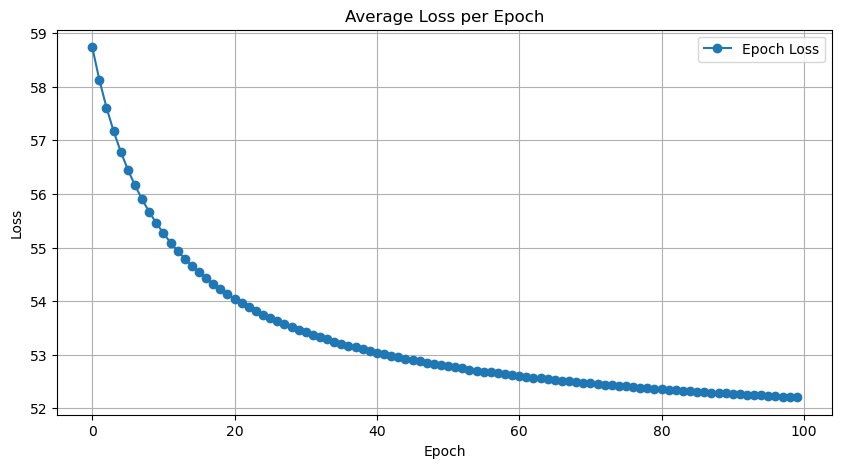

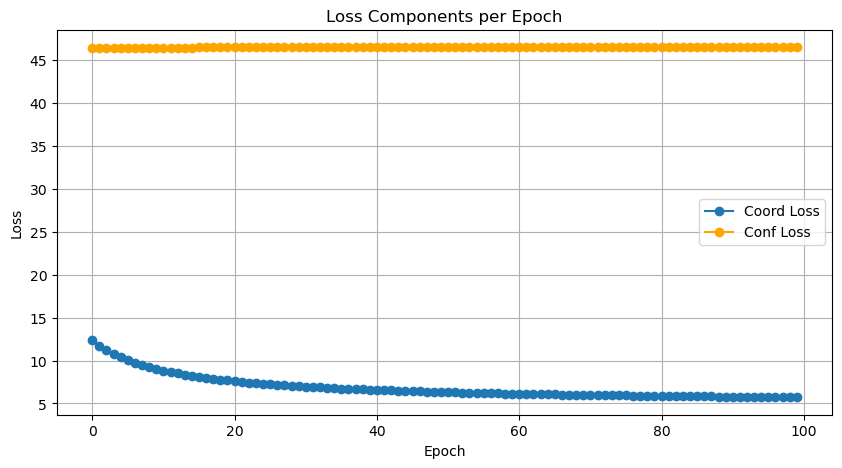

In [27]:
import matplotlib.pyplot as plt

epoch_losses = [record['epoch_loss'] for record in loss_records]
coord_losses = [record['coord_loss'] for record in loss_records]
conf_losses = [record['conf_loss'] for record in loss_records]

plt.figure(figsize=(10, 5))
plt.plot(epoch_losses, label='Epoch Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(coord_losses, label='Coord Loss', marker='o')
plt.plot(conf_losses, label='Conf Loss', marker='o', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Components per Epoch')
plt.legend()
plt.grid(True)
plt.show()


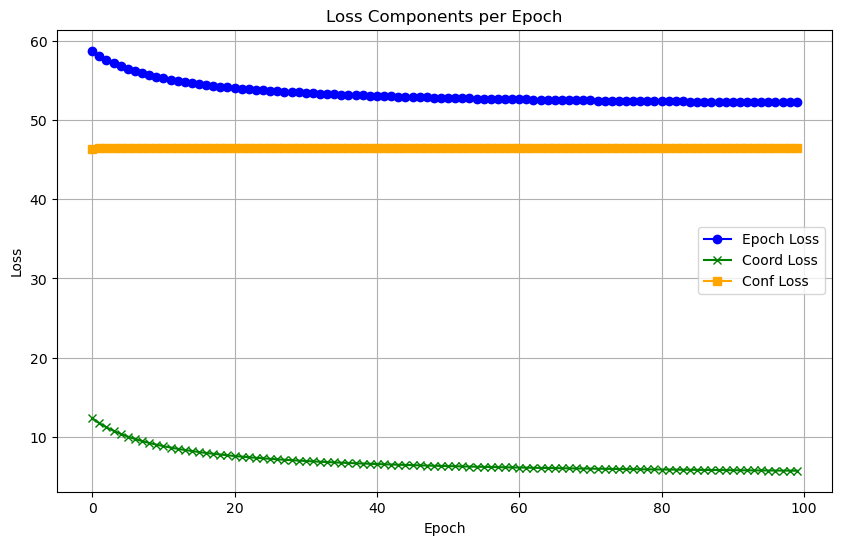

In [28]:
import matplotlib.pyplot as plt

epoch_losses = [record['epoch_loss'] for record in loss_records]
coord_losses = [record['coord_loss'] for record in loss_records]
conf_losses = [record['conf_loss'] for record in loss_records]

plt.figure(figsize=(10, 6))
plt.plot(epoch_losses, label='Epoch Loss', marker='o', color='blue')
plt.plot(coord_losses, label='Coord Loss', marker='x', color='green')
plt.plot(conf_losses, label='Conf Loss', marker='s', color='orange')

plt.title('Loss Components per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()  
plt.grid(True)
plt.show()


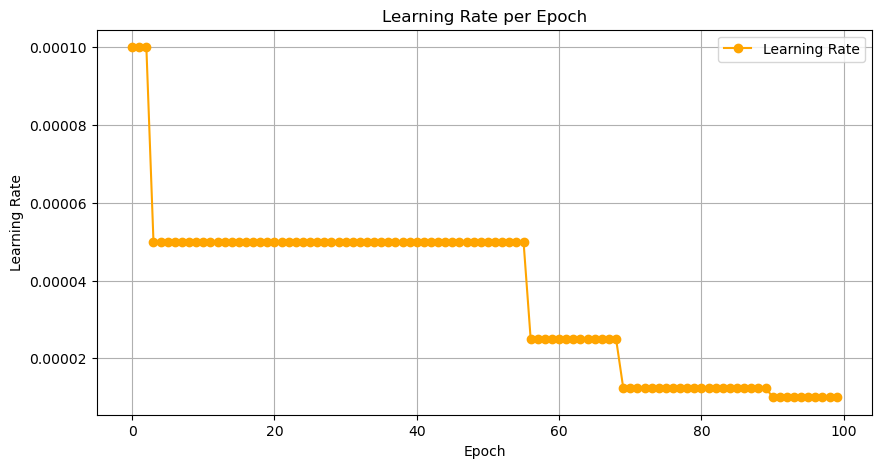

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(lr_history, label='Learning Rate', marker='o', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate per Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
torch.save(pruned_model.state_dict(), 'tinyyolo_pruned_100_epoches.pt')
# torch.save(pruned_model.state_dict(), 'tinyyolo_pruned_10_epoches.pt')
print("Pruned model saved.")

Pruned model saved.


In [31]:
print(pruned_model)

TinyYoloV2_Fused(
  (pad): ReflectionPad2d((0, 1, 0, 1))
  (conv1): Conv2d(3, 13, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(13, 26, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(26, 51, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(51, 102, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(102, 205, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(205, 410, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(410, 819, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(819, 819, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(819, 30, kernel_size=(1, 1), stride=(1, 1))
)


In [32]:
sd = torch.load('tinyyolo_pruned_100_epoches.pt')

for k in sd:
    print(k)
    print(sd[k].shape)
    print()

anchors
torch.Size([5, 2])

conv1.weight
torch.Size([13, 3, 3, 3])

conv1.bias
torch.Size([13])

conv2.weight
torch.Size([26, 13, 3, 3])

conv2.bias
torch.Size([26])

conv3.weight
torch.Size([51, 26, 3, 3])

conv3.bias
torch.Size([51])

conv4.weight
torch.Size([102, 51, 3, 3])

conv4.bias
torch.Size([102])

conv5.weight
torch.Size([205, 102, 3, 3])

conv5.bias
torch.Size([205])

conv6.weight
torch.Size([410, 205, 3, 3])

conv6.bias
torch.Size([410])

conv7.weight
torch.Size([819, 410, 3, 3])

conv7.bias
torch.Size([819])

conv8.weight
torch.Size([819, 819, 3, 3])

conv8.bias
torch.Size([819])

conv9.weight
torch.Size([30, 819, 1, 1])

conv9.bias
torch.Size([30])



/var/folders/3p/yjsjgtxs5w75lv_wclnr3n0c0000gn/T/ipykernel_55296/3234556343.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load('tinyyolo_pruned_100_epoches.

### Test inference speed after the pruning

In [33]:
import os
print(f"Model size: {os.path.getsize('tinyyolo_fused_bn.pt') / 1e6:.2f} MB")
# print(f"Model size: {os.path.getsize('tinyyolo_pruned_10_epoches.pt') / 1e6:.2f} MB")
print(f"Model size: {os.path.getsize('tinyyolo_pruned_100_epoches.pt') / 1e6:.2f} MB")
# print(f"Model size: {os.path.getsize('tinyyolo_pruned_100_epoches_right.pt') / 1e6:.2f} MB")

Model size: 63.05 MB
Model size: 40.38 MB


In [34]:
import time
from tinyyolov2_fused import TinyYoloV2_Fused
import torch

print("----------------------Before pruning----------------------")
model = TinyYoloV2_Fused(num_classes=1)
model.load_state_dict(torch.load('tinyyolo_fused_bn.pt'))
model.eval()

with torch.no_grad():
    start = time.time()
    for img, _ in loader:
        _ = model(img)
    end = time.time()

print(f"Average inference time: {(end - start) / len(loader):.4f} seconds per image before pruning")
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        print(f"{name} weight shape: {module.weight.shape}")


----------------------Before pruning----------------------


/var/folders/3p/yjsjgtxs5w75lv_wclnr3n0c0000gn/T/ipykernel_55296/2539941706.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('tinyyolo_fu

Average inference time: 0.7774 seconds per image before pruning
conv1 weight shape: torch.Size([16, 3, 3, 3])
conv2 weight shape: torch.Size([32, 16, 3, 3])
conv3 weight shape: torch.Size([64, 32, 3, 3])
conv4 weight shape: torch.Size([128, 64, 3, 3])
conv5 weight shape: torch.Size([256, 128, 3, 3])
conv6 weight shape: torch.Size([512, 256, 3, 3])
conv7 weight shape: torch.Size([1024, 512, 3, 3])
conv8 weight shape: torch.Size([1024, 1024, 3, 3])
conv9 weight shape: torch.Size([30, 1024, 1, 1])


In [35]:
import torch

def parse_pruned_conv_shapes(state_dict, num_convs=9):
    """
    Parse the shape information of each convolutional layer from the pruned state_dict.
    returned conv_shapes is a list：
      conv_shapes[i] = {
         'name': f'conv{i+1}',
         'out_channels': ...,
         'in_channels': ...,
         'kernel_size': (kH, kW),
         'stride': (sH, sW),
         'padding': (pH, pW),
         'has_bias': True/False
      }
    """
    conv_shapes = []
    for i in range(1, num_convs+1):
        w_key = f'conv{i}.weight'   # e.g. "conv1.weight"
        b_key = f'conv{i}.bias'     # e.g. "conv1.bias"
        if w_key not in state_dict:
            raise KeyError(f"{w_key} not found in state_dict!")
        
        w = state_dict[w_key]
        out_ch, in_ch, kH, kW = w.shape
        
        has_bias = (b_key in state_dict)
        
        if (kH, kW) == (3, 3):
            kernel_size = (3, 3)
            stride = (1, 1)
            padding = (1, 1)
        else:
            # conv9
            kernel_size = (1, 1)
            stride = (1, 1)
            padding = (0, 0)
        
        conv_shapes.append({
            'name': f'conv{i}',
            'out_channels': out_ch,
            'in_channels':  in_ch,
            'kernel_size': kernel_size,
            'stride': stride,
            'padding': padding,
            'has_bias': has_bias
        })
    return conv_shapes


In [36]:
def load_pruned_tinyyolo(weights_path, num_classes=1, anchors=None):
    """
    Given the path to the pruned + trained weights file, dynamically parse the shapes of each layer, create a "thin" model, and then load_state_dict returns it.
    """
    state_dict = torch.load(weights_path, map_location='cpu')
    conv_shapes = parse_pruned_conv_shapes(state_dict, num_convs=9)

    pruned_model = TinyYoloV2_Pruned(conv_shapes, num_classes=num_classes, anchors=anchors)

    pruned_model.load_state_dict(state_dict)

    pruned_model.eval()
    return pruned_model


In [39]:
from tinyyolov2_pruned import TinyYoloV2_Pruned
print("----------------------After pruning----------------------")
pruned_model = load_pruned_tinyyolo('tinyyolo_pruned_100_epoches.pt', num_classes=1)

with torch.no_grad():
    start = time.time()
    for img, _ in loader:
        _ = pruned_model(img)
    end = time.time()

print(f"Average inference time: {(end - start) / len(loader):.4f} seconds per image after Pruning")

for name, module in model.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        print(f"{name} weight shape: {module.weight.shape}")


----------------------After pruning----------------------


/var/folders/3p/yjsjgtxs5w75lv_wclnr3n0c0000gn/T/ipykernel_55296/958833540.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path, map_loca

Average inference time: 0.6371 seconds per image after Pruning
conv1 weight shape: torch.Size([16, 3, 3, 3])
conv2 weight shape: torch.Size([32, 16, 3, 3])
conv3 weight shape: torch.Size([64, 32, 3, 3])
conv4 weight shape: torch.Size([128, 64, 3, 3])
conv5 weight shape: torch.Size([256, 128, 3, 3])
conv6 weight shape: torch.Size([512, 256, 3, 3])
conv7 weight shape: torch.Size([1024, 512, 3, 3])
conv8 weight shape: torch.Size([1024, 1024, 3, 3])
conv9 weight shape: torch.Size([30, 1024, 1, 1])


In [40]:
# TODO
# Use pruned model to do inference and calculate mAP

In [47]:
from torchvision import transforms
from utils.dataloader import VOCDataLoaderPerson
from tinyyolov2_pruned import TinyYoloV2_Pruned
from utils.yolo import nms, filter_boxes
from utils.viz import display_result

# Define transformations
# transform = transforms.Compose([
#     transforms.Resize((320, 320)),  # Resize to 320x320
#     transforms.ToTensor(),         # Convert PIL Image to PyTorch Tensor
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
# ])

# Update the dataloader to use the transformations
loader_test = VOCDataLoaderPerson(train=False, batch_size=1)

# Load pruned model
net = load_pruned_tinyyolo('tinyyolo_pruned_100_epoches.pt', num_classes=1)
print("Model state dict keys:", net.state_dict().keys())

print(net.anchors)

Model state dict keys: odict_keys(['anchors', 'conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'conv4.weight', 'conv4.bias', 'conv5.weight', 'conv5.bias', 'conv6.weight', 'conv6.bias', 'conv7.weight', 'conv7.bias', 'conv8.weight', 'conv8.bias', 'conv9.weight', 'conv9.bias'])
tensor([[0.3977, 0.5792],
        [0.0494, 0.0937],
        [0.1244, 0.2525],
        [0.6931, 0.7218],
        [0.2294, 0.4408]])


/var/folders/3p/yjsjgtxs5w75lv_wclnr3n0c0000gn/T/ipykernel_55296/958833540.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path, map_loca

In [48]:


#put network in evaluation mode
net.eval()

def hook_fn(module, input, output):
    print(f"Layer: {module}")
    print(f"Output min: {output.min()}, max: {output.max()}\n")
    if torch.isnan(output).any():
        print(f"NaN detected in layer: {module}\n")

for name, module in net.named_modules():
    module.register_forward_hook(hook_fn)


print("------------Checking paramters in checkpoints---------------")
for name, param in net.named_parameters():
    if torch.isnan(param).any():
        print(f"NaN detected in parameter: {name}")
    if torch.isinf(param).any():
        print(f"Inf detected in parameter: {name}")
    print(f"{name}: mean={param.mean().item()}, std={param.std().item()}")


print("-----------Checking if the keys match to the current structure----------------")
net.load_state_dict(torch.load('tinyyolo_pruned_100_epoches.pt'), strict=True)



------------Checking paramters in checkpoints---------------
conv1.weight: mean=-0.13415509462356567, std=5.341840744018555
conv1.bias: mean=0.10303882509469986, std=2.3831543922424316
conv2.weight: mean=-0.011420976370573044, std=0.08963838219642639
conv2.bias: mean=1.0813380479812622, std=1.0412657260894775
conv3.weight: mean=-0.007898838259279728, std=0.08902809023857117
conv3.bias: mean=0.8375135064125061, std=2.3958752155303955
conv4.weight: mean=-0.003808063454926014, std=0.046569738537073135
conv4.bias: mean=-0.08635693043470383, std=1.9290924072265625
conv5.weight: mean=-0.0035270790103822947, std=0.034426141530275345
conv5.bias: mean=-0.35362768173217773, std=1.1637412309646606
conv6.weight: mean=-0.0026016717310994864, std=0.02613326907157898
conv6.bias: mean=-1.0609089136123657, std=0.7155032753944397
conv7.weight: mean=-0.004243265371769667, std=0.07429885119199753
conv7.bias: mean=-1.5011744499206543, std=1.2742561101913452
conv8.weight: mean=-0.00013417689478956163, std=0

/var/folders/3p/yjsjgtxs5w75lv_wclnr3n0c0000gn/T/ipykernel_55296/3062451474.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('tinyyolo_pru

<All keys matched successfully>

  0%|                                                      | 0/2232 [00:00<?, ?it/s]

Input tensor shape: torch.Size([1, 3, 320, 320])
Input tensor min: 0.0, max: 1.0


Target.shape: torch.Size([1, 10, 6])
Layer: Conv2d(3, 13, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Output min: -67.43122100830078, max: 65.28141021728516

Layer: Conv2d(13, 26, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Output min: -71.33064270019531, max: 25.4158878326416

Layer: Conv2d(26, 51, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Output min: -26.366294860839844, max: 21.43665885925293

Layer: Conv2d(51, 102, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Output min: -27.40709114074707, max: 17.307247161865234

Layer: Conv2d(102, 205, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Output min: -21.518815994262695, max: 12.229140281677246

Layer: Conv2d(205, 410, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Output min: -12.011468887329102, max: 5.794302940368652

Layer: ReflectionPad2d((0, 1, 0, 1))
Output min: -12.011468887329102, max: 5.794302940368652

Laye

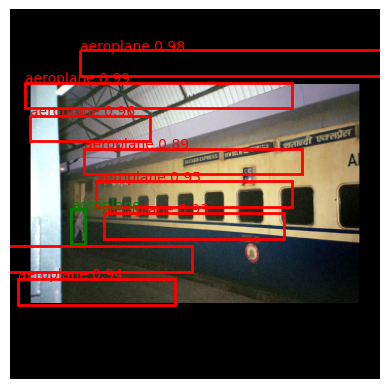

  0%|                                              | 1/2232 [00:00<06:18,  5.89it/s]

Input tensor shape: torch.Size([1, 3, 320, 320])
Input tensor min: 0.0, max: 1.0


Target.shape: torch.Size([1, 10, 6])
Layer: Conv2d(3, 13, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Output min: -65.7358169555664, max: 63.831092834472656

Layer: Conv2d(13, 26, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Output min: -74.11234283447266, max: 21.05403709411621

Layer: Conv2d(26, 51, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Output min: -34.942867279052734, max: 20.915897369384766

Layer: Conv2d(51, 102, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Output min: -24.365371704101562, max: 18.5519962310791

Layer: Conv2d(102, 205, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Output min: -20.517183303833008, max: 12.630949974060059

Layer: Conv2d(205, 410, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Output min: -12.557453155517578, max: 6.837223529815674

Layer: ReflectionPad2d((0, 1, 0, 1))
Output min: -12.557453155517578, max: 6.837223529815674

Lay

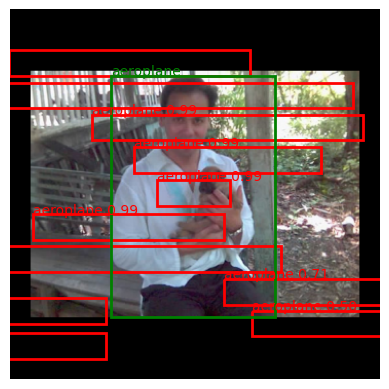

  0%|                                              | 2/2232 [00:00<05:48,  6.41it/s]

Input tensor shape: torch.Size([1, 3, 320, 320])
Input tensor min: 0.0, max: 1.0


Target.shape: torch.Size([1, 10, 6])
Layer: Conv2d(3, 13, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Output min: -57.644874572753906, max: 52.78614807128906

Layer: Conv2d(13, 26, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Output min: -56.26670837402344, max: 29.278244018554688

Layer: Conv2d(26, 51, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Output min: -28.825862884521484, max: 26.983102798461914

Layer: Conv2d(51, 102, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Output min: -24.15852928161621, max: 26.62885284423828

Layer: Conv2d(102, 205, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Output min: -23.748126983642578, max: 14.53442096710205

Layer: Conv2d(205, 410, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Output min: -12.283334732055664, max: 4.995329856872559

Layer: ReflectionPad2d((0, 1, 0, 1))
Output min: -12.283334732055664, max: 4.995329856872559

La

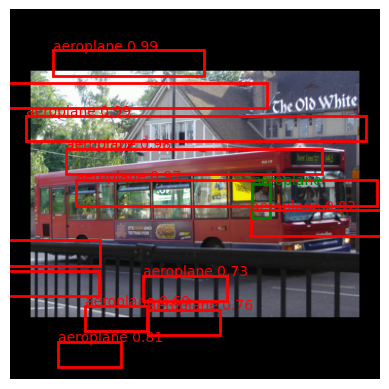

  0%|                                              | 2/2232 [00:00<09:45,  3.81it/s]


In [49]:
import tqdm
from utils.viz import display_result

its = 3

for idx, (input, target) in tqdm.tqdm(enumerate(loader_test), total=len(loader_test)):

    print(f"Input tensor shape: {input.shape}")
    print(f"Input tensor min: {input.min()}, max: {input.max()}")
    print("\n")

    print(f'Target.shape: {target.shape}')

    
    #input is a 1 x 3 x 320 x 320 image
    output = net(input)
    "output is of a tensor of size 32 x 125 x 10 x 10"
    #output is a 32 x 125 x 10 x 10 tensor

    print(f'output.shape: {output.shape}')
    
    print(f'----------------------Output before flter_boxes: {output.shape}------------------------')
    #filter boxes based on confidence score (class_score*confidence)
    output = filter_boxes(output, 0.4)
    print(f'----------------------Output after flter_boxes: {output[0].shape}------------------------')
    print(f'----------------------Output after flter_boxes: {type(output)}------------------------')
    print(f'----------------------Output after flter_boxes: {len(output)}------------------------')

    #print(output[0].data)
    
    #filter boxes based on overlap
    output = nms(output, 0)
    print(f'----------------------Output after nms: {output[0].shape}------------------------')
    print(f'----------------------Output after nms: {type(output)}------------------------')
    print(f'----------------------Output after nms: {len(output)}------------------------')

    print([o.shape for o in output])
    print(type(output))
    print("GT class index:", target[0,idx,5])
    # display_result(input, output, target, file_path='yolo_prediction.png')
    display_result(input, output, target)

    its = its - 1

    if its <= 0:
        break